# the script implemented in a notebook to look at whats happening

In [86]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks


def load_data(pth):
    hdst = []

    for i in tqdm(range(1,8)):
        print(f"LDC {i}", flush = True)
        flder_pth = pth + 'ldc' + str(i) + '/'
        hdst.append(load_data_fast(flder_pth))

    hdst = pd.concat(hdst)
    return hdst



def main(RUN_NUMBER, 
         TIMESTAMP, 
         CITY,
         FOM_TS):
    
    print('=' * 20, flush = True)
    print(f'RUNS: {RUN_NUMBER}\nTIMESTAMPS: {TIMESTAMP}', flush = True)
    print('=' * 20, flush = True)




    # make directory
    pre_dir = '/scratch/halmazan/NEXT/PROCESSING/FOM/data/'
    folder_name = f'{pre_dir}/{FOM_TS}'
    folder_s = Path(f'{folder_name}')
    folder_s.mkdir(parents=True, exist_ok=True)


    # load
    hdst_local = []
    for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
        print(f'R{RN}: {TS}', flush = True)
        n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/{RN}/{TS}/'
        hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
        print(f'Loaded!', flush = True)
    hdst = pd.concat(hdst_local)
 

    # quick plot for sanity reasons.
    plt.hist(hdst.energy, bins = 100)
    plt.title(f"FULL DATASET ENERGY DISTRIBUTION")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Counts")
    plt.savefig(f'{folder_name}/hist_plot.pdf')
    plt.close()

    vars = 'energy'
    labels = '(MeV)'
    log_flag = False
    print('=' * 20, flush = True)
    print('data loaded', flush = True)

    # DEFINING ALL THE FUNCTIONS INSIDE CAUSE IM SCARED

    #def sig_func(x, ns, beta, m, loc, scale):
    #    '''
    #    signal function now defined by a crystal ball
    #    Args:
    #        x       : numpy.ndarray
    #                  Independent variable (e.g., energy values).
    #        ns      : float
    #                  Normalization factor for the signal component.
    #        B       : float
    #                  Background parameter  related to the exponential decay.
    #        M       : float
    #                  Mean value of the crystal ball distribution, representing the peak position.
    #    Returns:
    #        numpy.ndarray
    #        The evaluated signal function values for the given input parameters.
    #    '''

    #    return ns * (crystalball.pdf(x, beta, m, loc = loc, scale = scale))

    def sig_func(x, ns, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            ns      : float
                      Normalization factor for the signal component.
            
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return ns * (norm.pdf(x, loc = loc, scale = scale))


    def sig_func_no_N(x, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            B       : float
                      Background parameter  related to the exponential decay.
            M       : float
                      Mean value of the crystal ball distribution, representing the peak position.
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return (norm.pdf(x, loc = loc, scale = scale))



#    def sig_func_no_N(x, B, M, loc, scale):
#        '''
#        signal function now defined by a crystal ball
#        Args:
#            x       : numpy.ndarray
#                      Independent variable (e.g., energy values).
#            B       : float
#                      Background parameter  related to the exponential decay.
#            M       : float
#                      Mean value of the crystal ball distribution, representing the peak position.
#        Returns:
#            numpy.ndarray
#            The evaluated signal function values for the given input parameters.
#        '''
#
#        return (crystalball.pdf(x, B, M, loc = loc, scale = scale))

#    def sig_bck_func(x, ns, nb, B, M, tau, loc, scale):
#        return (sig_func(x, ns, B, M, loc, scale) + FOM_func.bck_func(x, nb, tau))

    def sig_bck_func(x, ns, nb, tau, loc, scale):
        return (sig_func(x, ns, loc, scale) + FOM_func.bck_func(x, nb, tau))



    def add_element(dict, key, value):
        if key not in dict:
            dict[key] = value
            
    def gaussian_fit_stupid(data, binning=80, plot=False):
        '''
        Function that fits using curve_fit the data with the respected binning,
        including an exponential component for the background.
        '''
        blob_np = data['energy'].to_numpy()
        # Create histogram
        heights, bins = np.histogram(blob_np, bins=binning)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Define Gaussian + Exponential function
        def gaussian_exponential(x, a, mu, sigma, b, tau):
            gaussian = a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
            exponential = b * np.exp(-tau * x)
            return gaussian + exponential

        # Initial guess for curve_fit
        initial_guess = [heights.max(), bin_centers[np.argmax(heights)], np.std(blob_np), heights.max() * 0.1, 0.1]

        # Fit the histogram data
        try:
            popt, pcov = curve_fit(gaussian_exponential, bin_centers, heights, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None

        if plot:
            # Plot the histogram and the fitted Gaussian + Exponential
            plt.hist(blob_np, bins=binning, alpha=0.6, label="Data")
            x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
            plt.plot(x_fit, gaussian_exponential(x_fit, *popt), label="Gaussian + Exponential Fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.show()

        # Return the mean (mu) and standard deviation (sigma) of the Gaussian
        return popt[1], popt[2]
    
    def gaussian_fit(data, binning = 80, plot = False):
        '''
        Fit gaussian to the data
        '''
        blob_np = data['energy'].to_numpy()

        # produce gaussian fit
        lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
        vals_g = [len(blob_np), 1.59, 0.004]
        nm_g = ['Ng', 'mu', 'sigma']

        m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                    limit_mu=(1.58, 1.60), limit_Ng=(0,None), limit_sigma=(0,5))
        m_g.print_level = 1  # Set verbosity level to show progress during minimization
        print("Starting minimization with migrad...", flush = True)
        # minimise it
        m_g.migrad()


        if (plot == True):
            # plot output
            try:
                plt.clf()
            except Exception as e:
                print(f'Couldnt clear plot:\n{e}')
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_g.show(parts=True)
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
        mu = fit_params['mu']
        sigma = fit_params['sigma']


        return (mu, sigma)

    def sb_fit(data, mu, sigma, fit_bins, plot = False, folder_input = ''):
        '''
        Fit signal and background to data
        '''
        blob_np = data['energy'].to_numpy()
        # create signal background pdf
        pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

        lh_sb = probfit.BinnedLH(pdf_sb, blob_np, bins = len(fit_bins)-1, extended = True)

        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)

        # give it rough starting spots
        ###vals_sb = [len(blob_np)/2, len(blob_np)/2, 1, 1.1, 0.9, mu, sigma]
        ###nm_sb = ['Ns', 'Nb', 'B', 'M', 'tau', 'loc', 'scale']

        vals_sb = [len(blob_np)/2, len(blob_np)/2, 0.001, mu, sigma]
        nm_sb = ['Ns', 'Nb', 'tau', 'loc', 'scale']


        print('Initial guess:', flush = True)
        FOM_func.print_parameters(vals_sb, list(np.diag(np.zeros_like(vals_sb))), nm_sb)
        #FOM_func.plot_fit(sig_bck_func, np.linspace(data['energy'].min(), data['energy'].max(), 1000), vals_sb, nm_sb, output=True)


        #m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
        #              limit_B = (0, 2),
        #              limit_M = (1, None),
        #              fix_loc = True,
        #              fix_scale = True,
        #              limit_tau=(0.1,None),
        #              print_level = 2)
        m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
                      #fix_loc = True,
                      #fix_scale = True,
                      limit_loc = (1.57, 1.62),
                      #limit_tau=(0.0000001,None),
                      print_level = 2)

        print('Scan and then fit', flush = True)
        # minimise that mfer

        m_sb.migrad()

        if (plot == True):
            # plot output
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_sb.show(parts=True)
            plt.savefig(f'{folder_input}')
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

        return (fit_params['Ns'], fit_params['Nb'])


    def sb_fit_curve_fit(data, mu, sigma, fit_bins, plot=False, folder_input=''):
        '''
        Fit signal and background to data using curve_fit, with fixed mu and sigma.
        '''
        blob_np = data['energy'].to_numpy()
        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)
        
        # Define the combined signal and background function
        def combined_func(x, ns, nb, tau):
            signal = ns * norm.pdf(x, loc=mu, scale=sigma)  # Fix mu and sigma
            background = nb * np.exp(-tau * x)
            return signal + background
        
        # Initial guess for the parameters (excluding fixed ones)
        initial_guess = [len(blob_np) / 2, len(blob_np) / 2, 0.001]
        
        try:
            # Perform the curve fitting
            popt, pcov = curve_fit(combined_func, x, y, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None
        
        # Print the optimized parameters and their covariance matrix
        param_names = ['ns', 'nb', 'tau']
        print("Optimized parameters (popt):")
        for name, value in zip(param_names, popt):
            print(f"{name}: {value}")
        
        print("\nCovariance matrix (pcov):")
        for i, row in enumerate(pcov):
            print(f"{param_names[i]}: {row}")

        
        if plot:
            # Plot the histogram and the fitted function
            plt.hist(blob_np, bins=fit_bins, alpha=0.6, label="data")
            x_fit = np.linspace(x.min(), x.max(), 1000)
            plt.plot(x_fit, combined_func(x_fit, *popt), label="fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.savefig(f'{folder_input}')
            plt.show()
        
        # Extract the fitted parameters
        ns, nb, tau = popt
        
        # Calculate the area under the signal function
        signal_area, _ = quad(lambda x: ns * norm.pdf(x, loc=mu, scale=sigma), fit_bins[0], fit_bins[-1])
        # Calculate the area under the background function
        background_area, _ = quad(lambda x: nb * np.exp(-tau * x), fit_bins[0], fit_bins[-1])
        
        # Divide the areas by the bin width
        bin_width = fit_bins[1] - fit_bins[0]
        signal_area /= bin_width
        background_area /= bin_width
        
        return signal_area, background_area
    

    def sb_fit_curve_fit_unfixed(data, mu, sigma, fit_bins, plot=False, folder_input=''):
        '''
        Fit signal and background to data using curve_fit, with fixed mu and sigma.
        '''
        blob_np = data['energy'].to_numpy()
        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)
        
        # Define the combined signal and background function
        def combined_func(x, ns, nb, tau, loc, scale):
            signal = ns * norm.pdf(x, loc, scale)  # Fix mu and sigma
            background = nb * np.exp(-tau * x)
            return signal + background
        
        # Initial guess for the parameters (excluding fixed ones)
        initial_guess = [len(blob_np) / 2, len(blob_np) / 2, 0.001, mu, sigma]
        
        try:
            # Perform the curve fitting
            popt, pcov = curve_fit(combined_func, x, y, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None
        
        # Print the optimized parameters and their covariance matrix
        param_names = ['ns', 'nb', 'tau', 'mu', 'sigma']
        print("Optimized parameters (popt):")
        for name, value in zip(param_names, popt):
            print(f"{name}: {value}")
        
        print("\nCovariance matrix (pcov):")
        for i, row in enumerate(pcov):
            print(f"{param_names[i]}: {row}")

        
        if plot:
            # Plot the histogram and the fitted function
            plt.hist(blob_np, bins=fit_bins, alpha=0.6, label="data")
            x_fit = np.linspace(x.min(), x.max(), 1000)
            plt.plot(x_fit, combined_func(x_fit, *popt), label="fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.savefig(f'{folder_input}')
            plt.show()
        
        # Extract the fitted parameters
        ns, nb, tau, loc, scale = popt
        
        # Calculate the area under the signal function
        signal_area, _ = quad(lambda x: ns * norm.pdf(x, loc=loc, scale=scale), fit_bins[0], fit_bins[-1])
        # Calculate the area under the background function
        background_area, _ = quad(lambda x: nb * np.exp(-tau * x), fit_bins[0], fit_bins[-1])
        
        # Divide the areas by the bin width
        bin_width = fit_bins[1] - fit_bins[0]
        signal_area /= bin_width
        background_area /= bin_width
        
        return signal_area, background_area


    
    binning = 150
    cut_list = np.linspace(0,0.5, 51) # normally 51 not 5
    fit_range = [hdst.energy.min(), hdst.energy.max()]



    # normalise and extend
    sig_norm = probfit.Normalized(sig_func_no_N, fit_range)
    sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

    bck_norm = probfit.Normalized(FOM_func.bck_func_no_N, fit_range)
    bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

    gauss_norm = probfit.Normalized(FOM_func.gauss_no_N, fit_range)
    gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []


    # print the blob separation for sanity reasons
    blob_title        = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_energies_post_cuts'
    #blob_2dhits_title = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_triangle_post_cuts'
    blob_2dhits_title = ''
    # make range full range of blob1 and blob2
    eblob_full = []
    eblob_full.append(hdst['eblob1'].to_numpy())
    eblob_full.append(hdst['eblob2'].to_numpy())

    minimum_e = np.min(eblob_full)
    maximum_e = np.max(eblob_full)

    func.plot_hist(hdst, column = 'eblob1', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
    func.plot_hist(hdst, column = 'eblob2', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
    plt.legend()
    plt.show()

    # blob 2dhist
    plt.hist2d(hdst['eblob1'], hdst['eblob2'], bins=(40, 40), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
    plt.colorbar(label='events')
    plt.xlabel("Blob-1 candidate energy (MeV)")
    plt.ylabel("Blob-2 candidate energy (MeV)")
    plt.title(f'{blob_2dhits_title}')
    plt.show()



    # apriori
    print('Starting the process...', flush = True)
    # [500, 1.65, 0.01]
    blob_data_fresh = hdst.copy(deep = True)
    func.plot_hist(blob_data_fresh, binning = binning, output = True, log = False)

    #gauss_hdst = func.energy_cuts(blob_data_fresh, 1.57, 1.615)
    func.plot_hist(blob_data_fresh, binning = binning, output = True, log = False, title = 'Gauss fit bins')
    # fit gaussian for mu and sigma    
    holder = gaussian_fit_stupid(blob_data_fresh)
    #holder = gaussian_fit(gauss_hdst, plot = True)
    mu = holder[0]
    # check for fix for weird first.
    sigma = abs(holder[1])

    print(f'Gaussian fixed at:\nmu: {mu}\nsigma: {sigma}', flush = True)


    for i in range(len(cut_list)):
        # generate data
        try:
            blob_data = blob_data_fresh[(blob_data_fresh['eblob2'] > cut_list[i])]
            print("", flush = True)
            print("", flush = True)
            print("====================================", flush = True)
            print("Blob cut: {} MeV".format(cut_list[i]), flush = True)
            print("====================================", flush = True)

            plt.hist(blob_data.energy, bins = 100)
            plt.show()

            fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
            #holder_sb = sb_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
            holder_sb = sb_fit_curve_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
            
            


            ns_l.append(holder_sb[0])
            nb_l.append(holder_sb[1])

            print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)), flush = True)

            # calculate the number of events by region selection
            #sig_reg = blob_data[(blob_data.energy < 1.625) & (blob_data.energy > 1.56)]
            #bck_reg = blob_data[(blob_data.energy > 1.625) | (blob_data.energy < 1.56)]
            #print(f'Signal events by selection: {sig_reg.event.nunique()}')
            #print(f'Background events by selection: {bck_reg.event.nunique()}')

            # efficiency and background rej
            e_check = ns_l[i]/ns_l[0]
            b_check = nb_l[i]/nb_l[0]
            fom_check = e_check/np.sqrt(b_check)

            e.append(e_check)
            b.append(b_check)
            fom.append(fom_check)

                # errors for fom
            e_err.append(FOM_func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
            b_err.append(FOM_func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
            fom_err.append(FOM_func.fom_error(e[i], b[i], e_err[i], b_err[i]))
            
            print(f'FOM: {fom}\nfom_err: {fom_err}', flush = True)
            print(f'ns_l: {ns_l}\nnb_l: {nb_l}', flush = True)
            del blob_data, holder_sb

            print("====================================", flush = True)

        except Exception as ex:
            print(f'Yo shit broke!\n{ex}', flush = True)
            print(traceback.format_exc())
            ns_l.append(-9999)
            nb_l.append(-9999)
            e.append(-9999)
            b.append(-9999)
            fom.append(-9999)
            e_err.append(-9999)
            b_err.append(-9999)
            fom_err.append(-9999)
            try:
                del blob_data, holder_sb
            except:
                print('Cant delete shit that doesnt exist i guess?', flush = True)


    print('=' * 20)
    print('LINEAR REGRESSION CHECK')
    print('=' * 20)
    m = 0.5
    c = 0.15
    
    # before trying that, lets try this linear reg cut
    linear_reg = hdst[hdst['eblob2'] > m * hdst['eblob1'] + c]
    fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
    #holder_sb = sb_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
    holder_sb = sb_fit_curve_fit(linear_reg, mu, sigma, fit_bins, plot = True)
    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(holder_sb[0], holder_sb[1], holder_sb[0] + holder_sb[1], len(linear_reg.index)), flush = True)
    # efficiency and background rej
    e_check = holder_sb[0]/ns_l[0]
    b_check = holder_sb[1]/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)
    print(f'FOM LINEAR REG: {fom_check}')


    print(f'FOM:\n{fom}', flush = True)
    print(f'FOM error:\n{fom_err}', flush = True)
    print(f'Cut list:\n{cut_list}', flush = True)

    # remove nans and set negatives to 0
    fom = [0 if (np.isnan(value) or value < 0) else value for value in fom]
    fom_err = [0 if fom[i] == 0 else fom_err[i] for i in range(len(fom))]

    print(f'Initial Signal events: {ns_l[0]}')
    print(f'Initial Background events: {nb_l[0]}')

    print(f'Maximum FOM: {np.max(fom)} +- {fom_err[np.argmax(fom)]}')
    print(f'Found at cut value: {cut_list[np.argmax(fom)]}')
    print(f'Signal events at peak: {ns_l[np.argmax(fom)]}')
    print(f'Background events at peak: {nb_l[np.argmax(fom)]}')

    try:
        plt.show()
    except Exception as e:
        print(e, flush = True)
    # Check if any value in fom_err is negative
    if any(value < 0 for value in fom_err):
        print(f'FOM error negative! Forcing positive, but expect weird results')
        fom_err = [abs(x) for x in fom_err]
    plt.errorbar(cut_list, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
    plt.legend()
    plt.title(f"FOM LPR R{FOM_TS[0]}")
    plt.xlabel("Blob-2 energy threshold (MeV)")
    plt.xlim([0,0.55])
    #plt.ylim([0,2])
    plt.ylabel("fom")
    plt.savefig(f'{folder_name}/FOM_plot.pdf')
    plt.show()
    plt.close()

    print('=' * 20)
    print('=' * 20)
    optimal_cut = cut_list[np.argmax(fom)]
    print(f'DISTRIBUTIONS AT CUT {optimal_cut}')
    print('=' * 20)
    print('=' * 20)
    # plot the two distributions at the best cut
    background_hdst = hdst[hdst.eblob2 < optimal_cut]
    signal_hdst     = hdst[hdst.eblob2 > optimal_cut]

    plt.hist(background_hdst.energy, bins = 100)
    plt.title('Background distribution')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Counts')
    plt.show()

    plt.hist(signal_hdst.energy, bins = 100)
    plt.title('Signal distribution')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Counts')
    plt.show()

    plt.hist(signal_hdst.energy, bins = 10)
    plt.title('Signal distribution ZOOMED')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Counts')
    plt.ylim([0, 800])
    plt.grid()
    plt.show()


    # save
    with open(f'{folder_name}/FOM.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(zip(cut_list, fom))
        writer.writerows(zip(cut_list, fom_err))
        writer.writerows(zip(ns_l, nb_l))
        writer.writerows(zip(e,e_err))
        writer.writerows(zip(b,b_err))







In [12]:
#[TS] * len(TIMESTAMP)







TIMESTAMP: 456018






RUNS: [250925]
TIMESTAMPS: ['456018']
R250925: 456018
Loaded!
data loaded


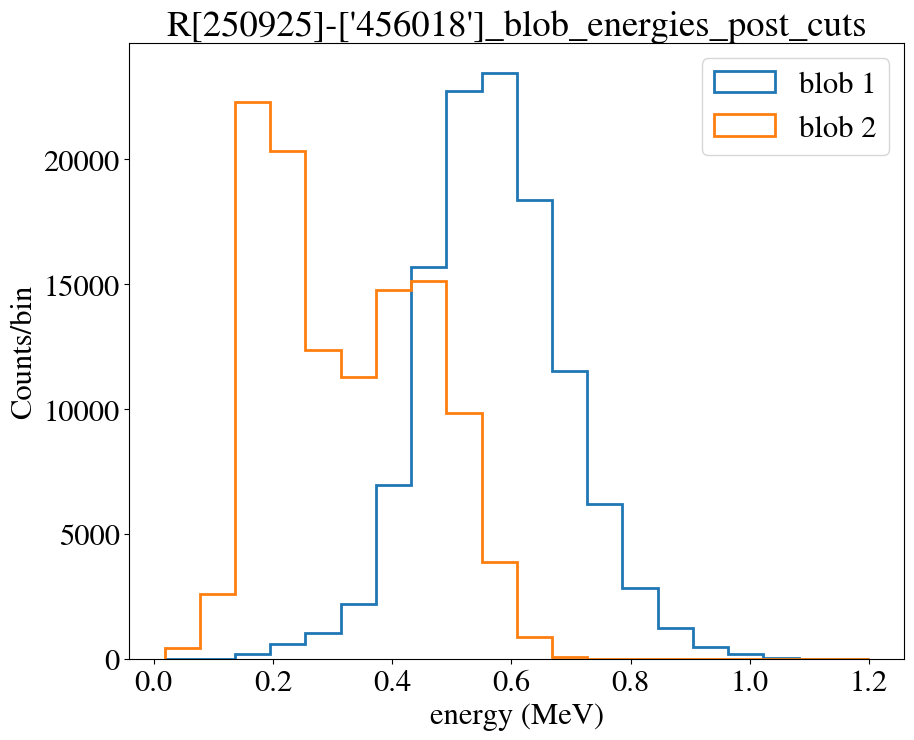

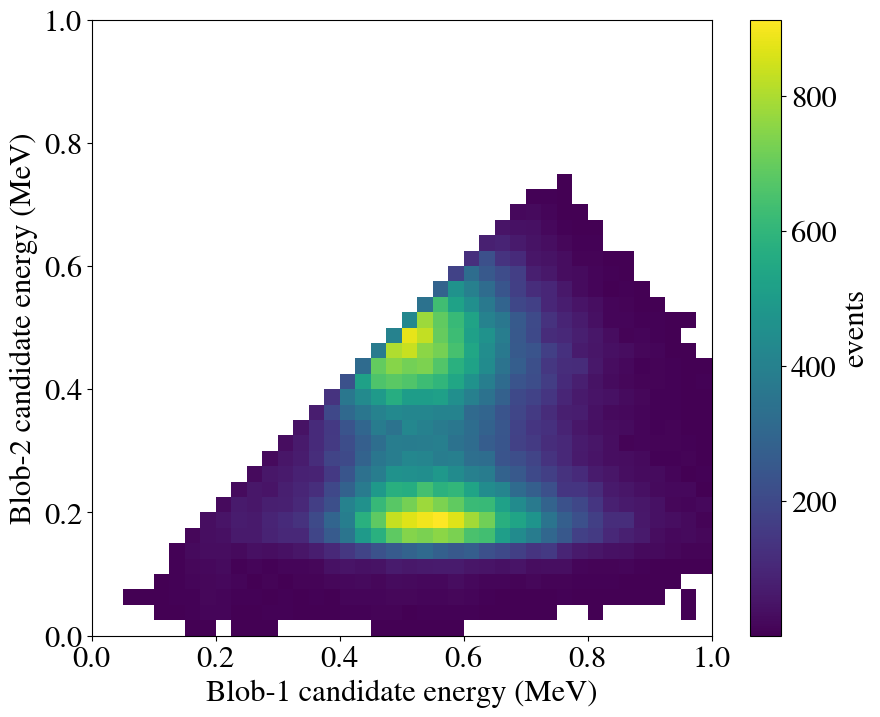

Starting the process...


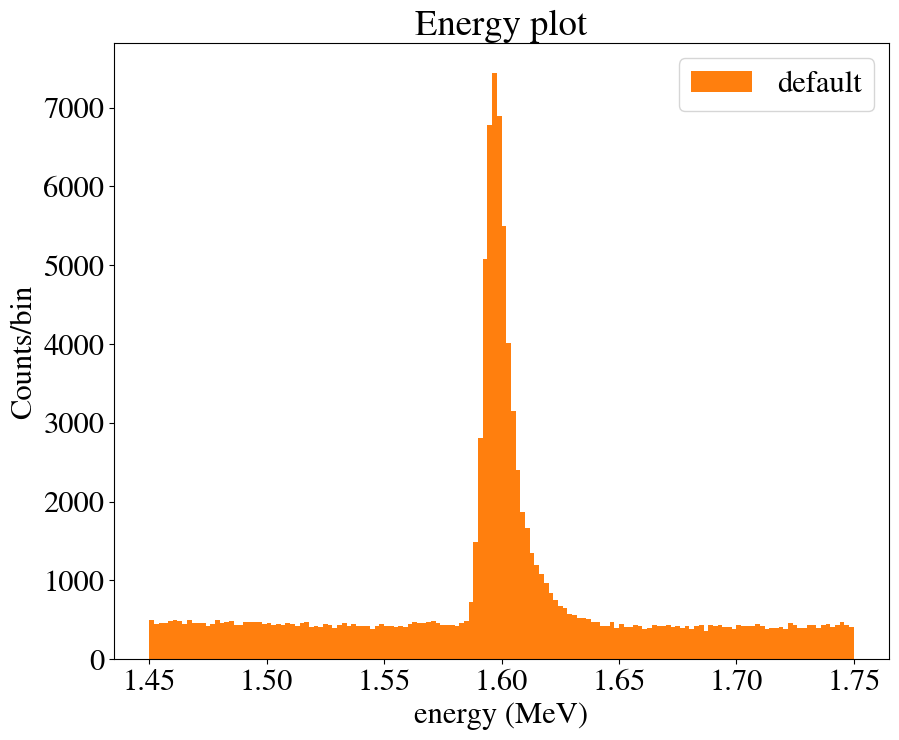

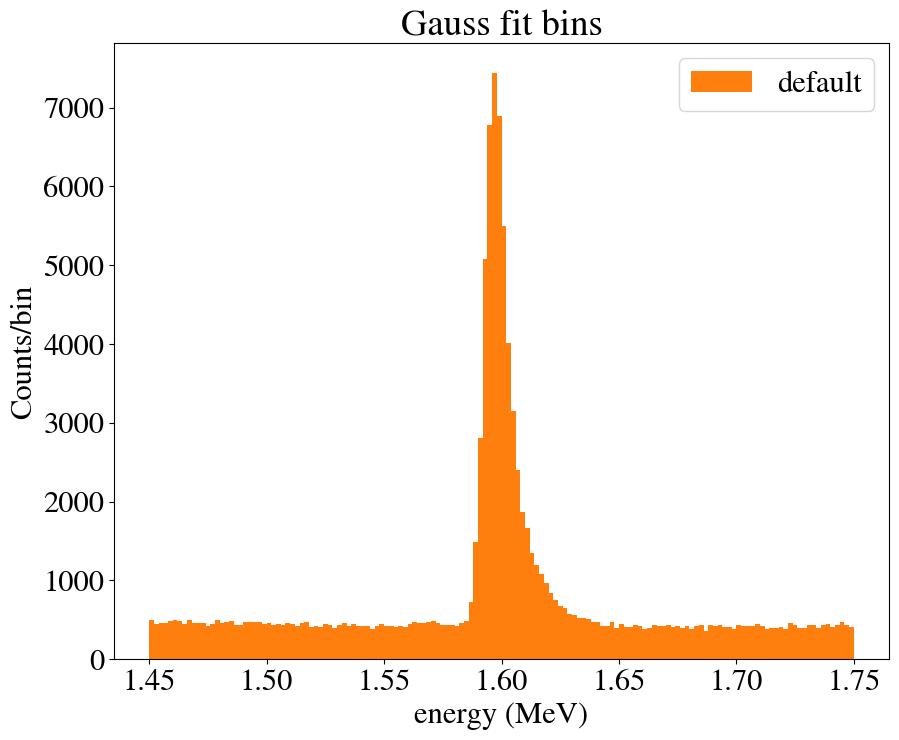

Gaussian fixed at:
mu: 1.597909742461709
sigma: 0.005254686726026739


Blob cut: 0.0 MeV


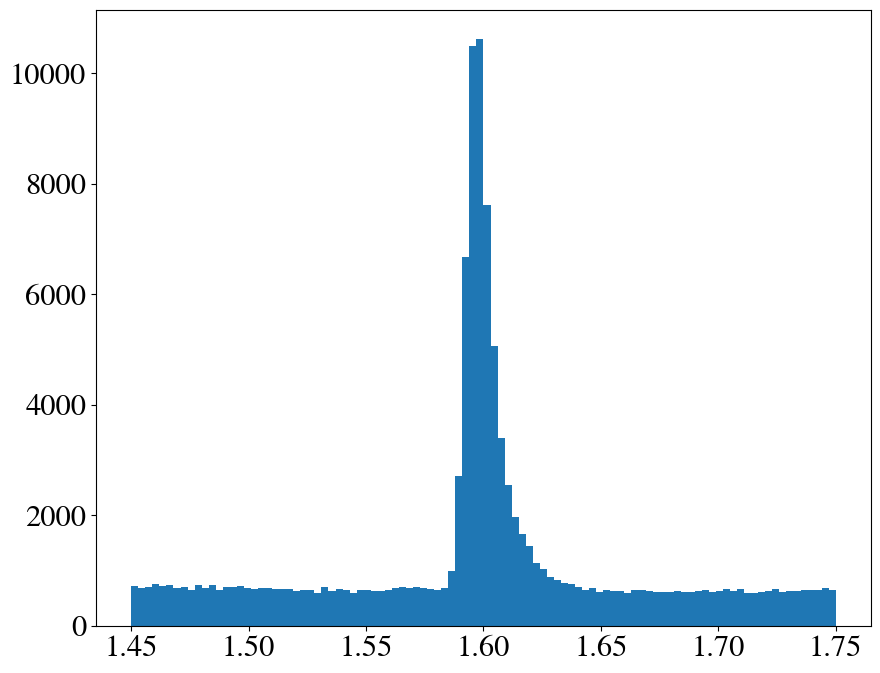

Optimized parameters (popt):
ns: 87.68975450297249
nb: 553.205340526708
tau: 0.10521337183328698

Covariance matrix (pcov):
ns: [ 1.61227968e+00 -7.05758155e+00 -7.89113702e-04]
nb: [-7.05758155e+00  1.29499315e+05  1.45996412e+02]
tau: [-7.89113702e-04  1.45996412e+02  1.65110083e-01]


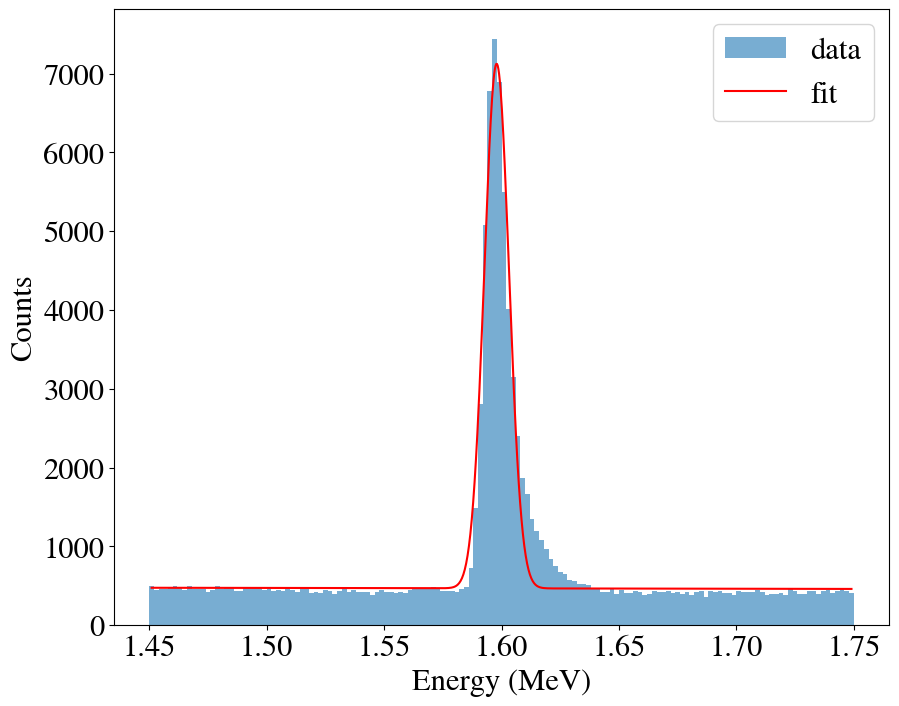

Signal events: 43846.05332831623
Background events: 70127.11302942775
Total Events by addition: 113973.16635774399
Total Events by row counting: 113973
FOM: [1.0]
fom_err: [0.007262509868846443]
ns_l: [43846.05332831623]
nb_l: [70127.11302942775]


Blob cut: 0.01 MeV


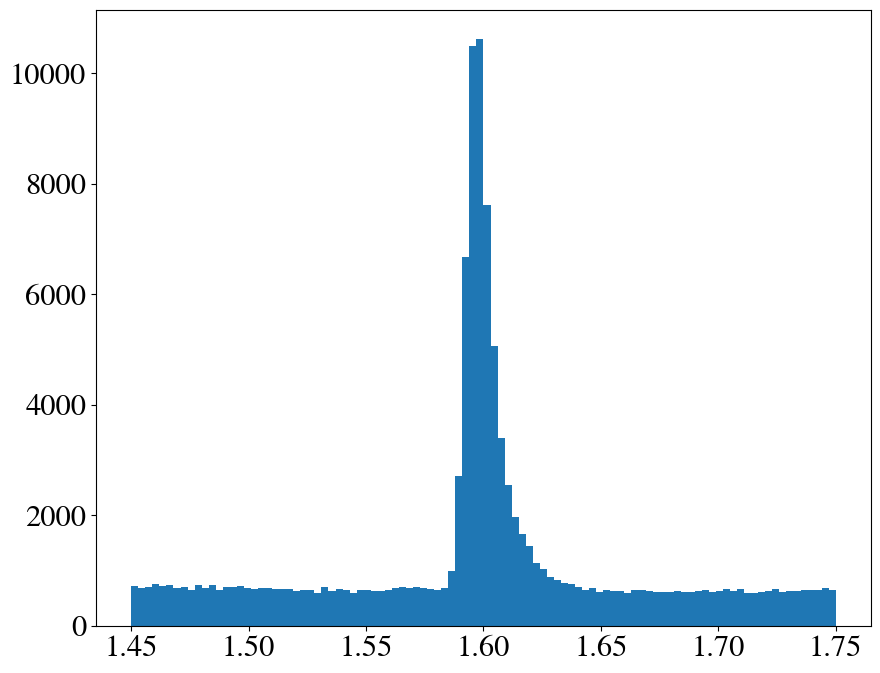

Optimized parameters (popt):
ns: 87.68975450297249
nb: 553.205340526708
tau: 0.10521337183328698

Covariance matrix (pcov):
ns: [ 1.61227968e+00 -7.05758155e+00 -7.89113702e-04]
nb: [-7.05758155e+00  1.29499315e+05  1.45996412e+02]
tau: [-7.89113702e-04  1.45996412e+02  1.65110083e-01]


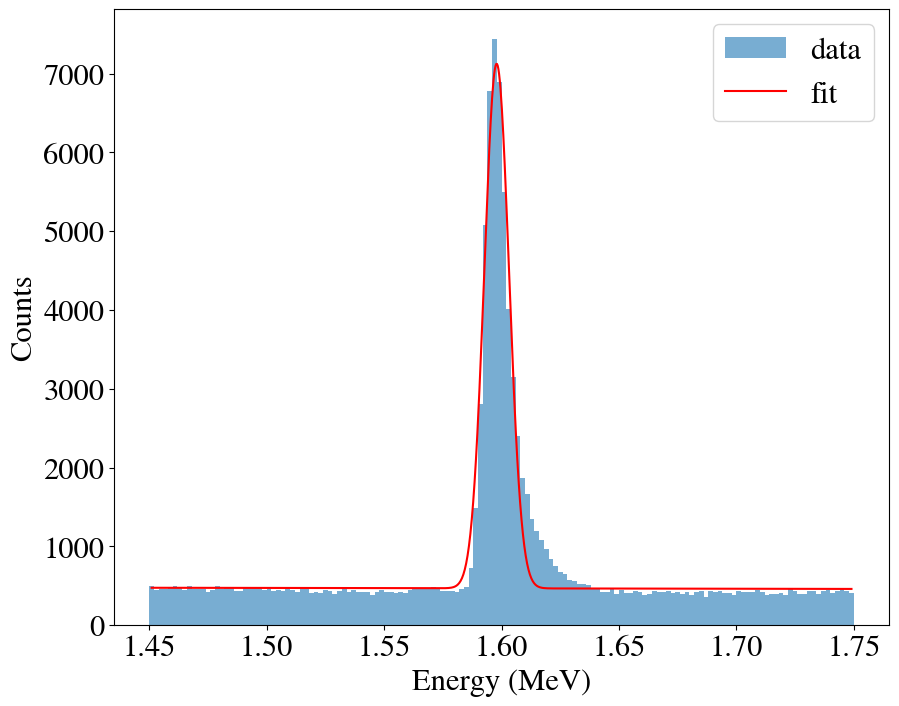

Signal events: 43846.05332831623
Background events: 70127.11302942775
Total Events by addition: 113973.16635774399
Total Events by row counting: 113973
FOM: [1.0, 1.0]
fom_err: [0.007262509868846443, 0.007262509868846443]
ns_l: [43846.05332831623, 43846.05332831623]
nb_l: [70127.11302942775, 70127.11302942775]


Blob cut: 0.02 MeV


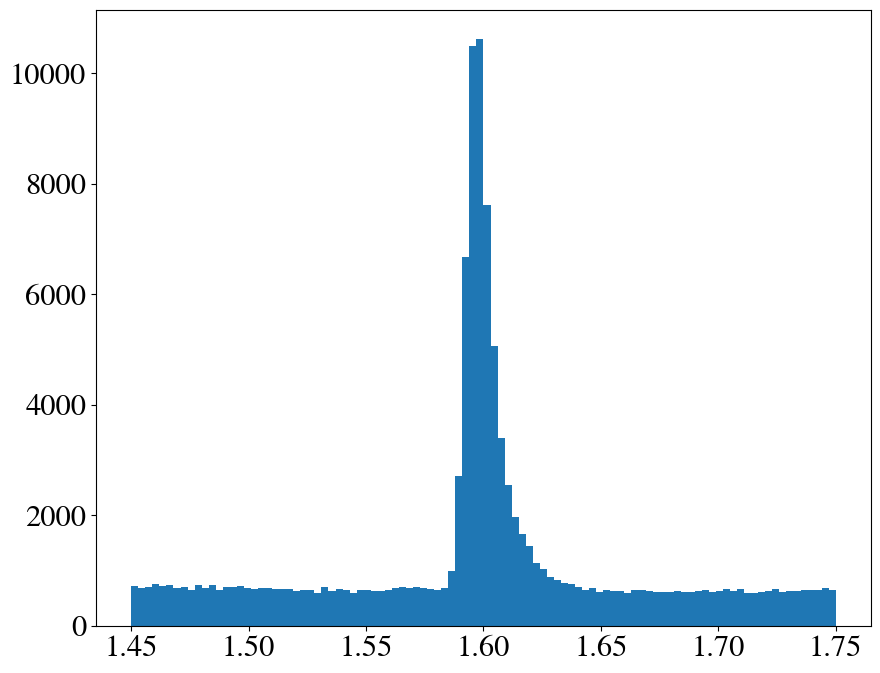

Optimized parameters (popt):
ns: 87.69015327960504
nb: 553.0742573048859
tau: 0.10509371745719898

Covariance matrix (pcov):
ns: [ 1.61233123e+00 -7.05849414e+00 -7.91481088e-04]
nb: [-7.05849414e+00  1.29454096e+05  1.45979894e+02]
tau: [-7.91481088e-04  1.45979894e+02  1.65130382e-01]


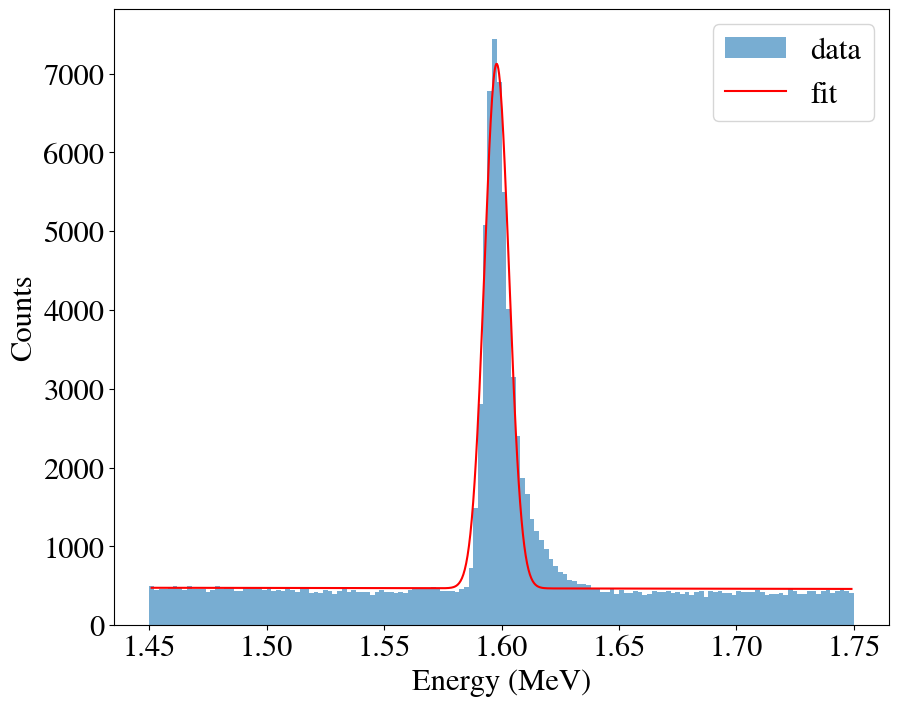

Signal events: 43846.25272198082
Background events: 70123.91335922861
Total Events by addition: 113970.16608120943
Total Events by row counting: 113970
FOM: [1.0, 1.0, 1.0000273618300308]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861]


Blob cut: 0.03 MeV


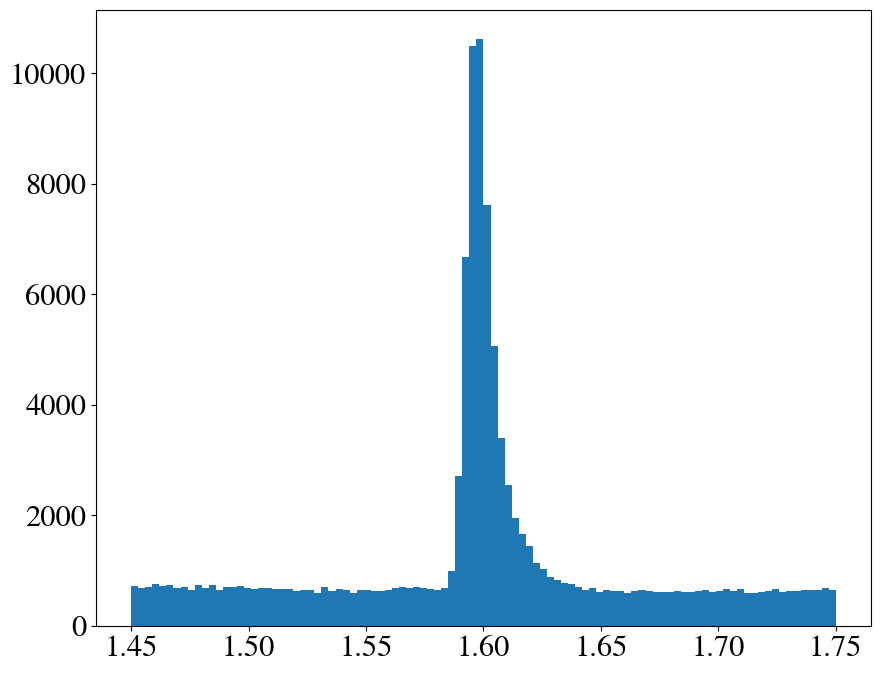

Optimized parameters (popt):
ns: 87.67471612484623
nb: 552.6782426480297
tau: 0.10484454731275615

Covariance matrix (pcov):
ns: [ 1.61019715e+00 -7.05170725e+00 -7.96724253e-04]
nb: [-7.05170725e+00  1.29181319e+05  1.45775766e+02]
tau: [-7.96724253e-04  1.45775766e+02  1.65016603e-01]


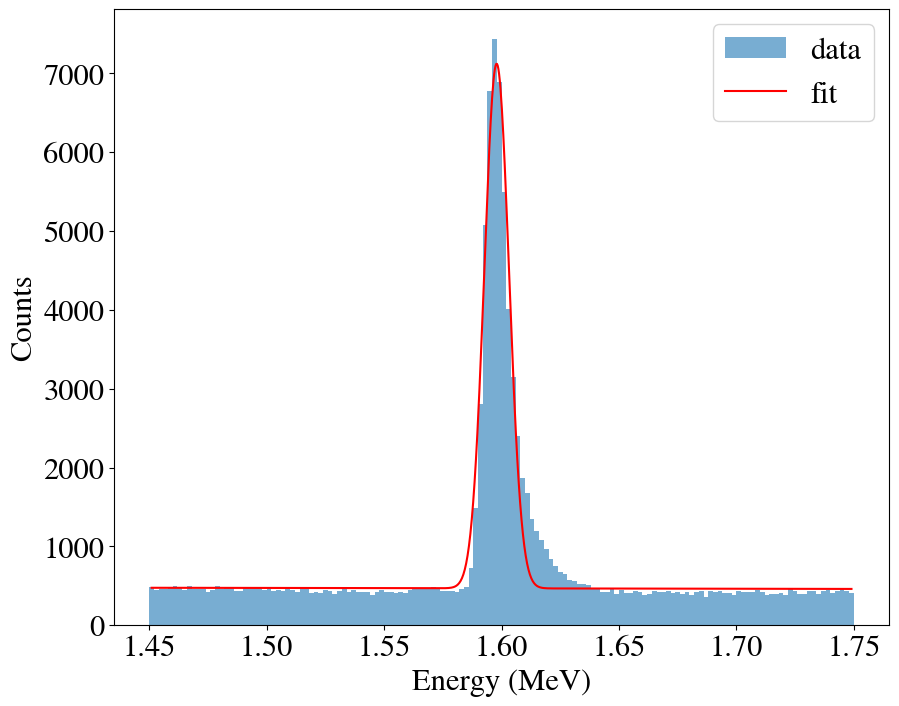

Signal events: 43838.53393756149
Background events: 70101.63116689787
Total Events by addition: 113940.16510445936
Total Events by row counting: 113940
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787]


Blob cut: 0.04 MeV


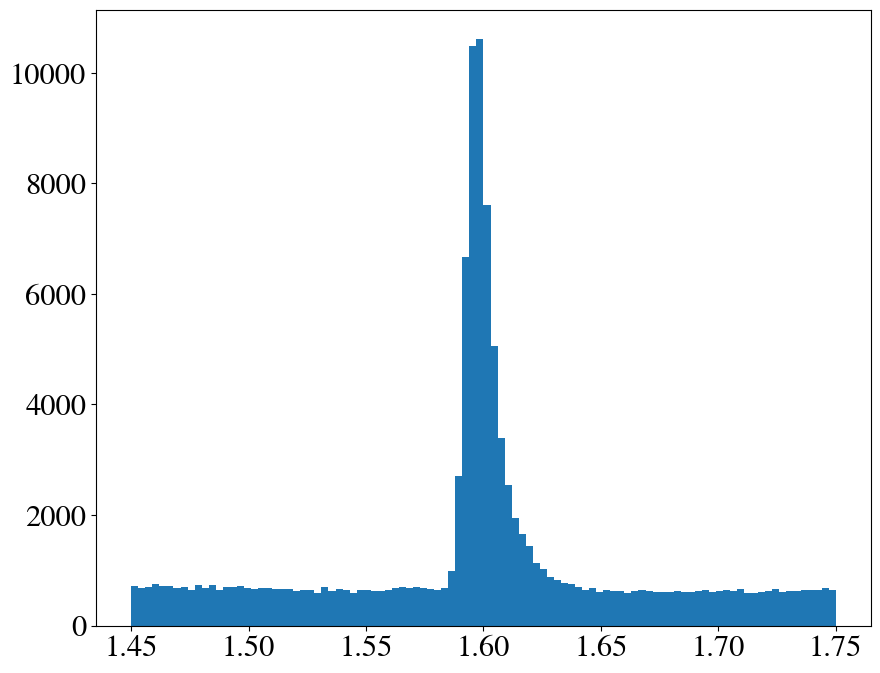

Optimized parameters (popt):
ns: 87.6389749816713
nb: 552.92847113044
tau: 0.10553918141190155

Covariance matrix (pcov):
ns: [ 1.60804676e+00 -7.03594059e+00 -7.80178778e-04]
nb: [-7.03594059e+00  1.29293209e+05  1.45837537e+02]
tau: [-7.80178778e-04  1.45837537e+02  1.65013559e-01]


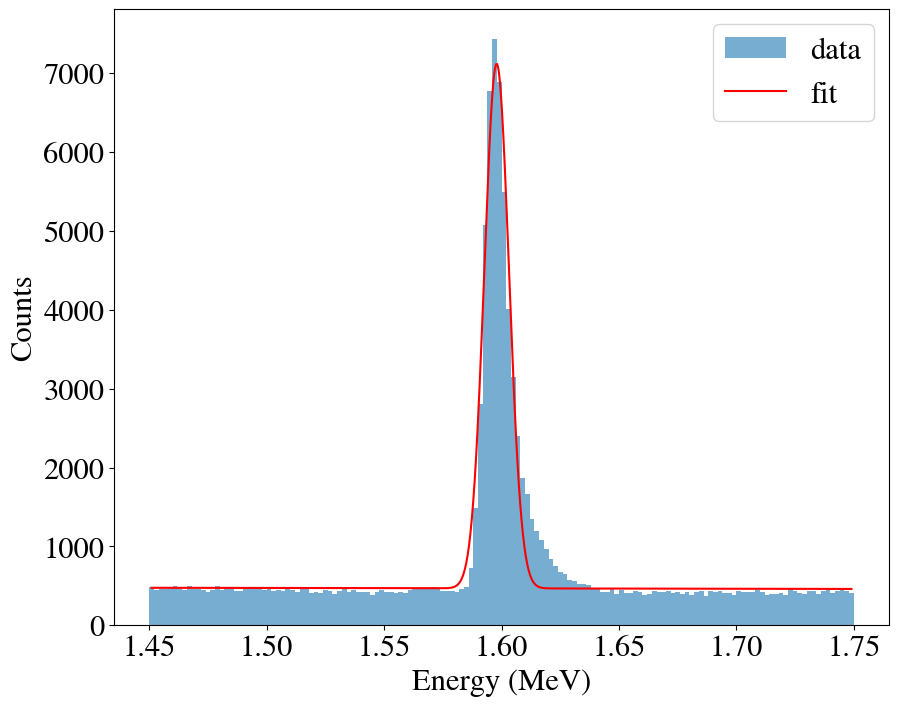

Signal events: 43820.66288662123
Background events: 70055.50460533923
Total Events by addition: 113876.16749196046
Total Events by row counting: 113876
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923]


Blob cut: 0.05 MeV


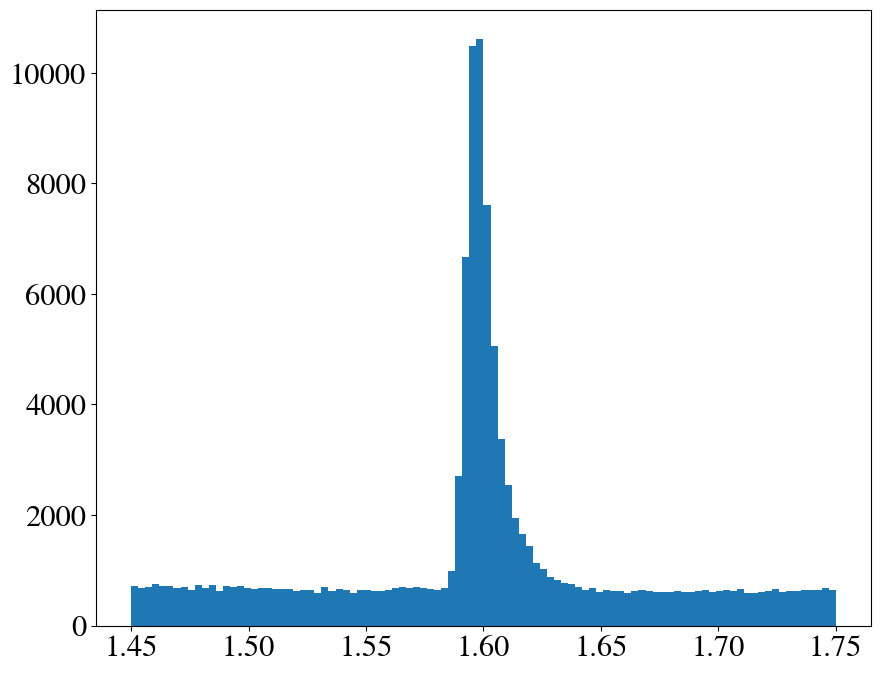

Optimized parameters (popt):
ns: 87.60936366079132
nb: 550.7580306244884
tau: 0.10339407543807413

Covariance matrix (pcov):
ns: [ 1.60720402e+00 -7.05160251e+00 -8.29492181e-04]
nb: [-7.05160251e+00  1.28346331e+05  1.45337145e+02]
tau: [-8.29492181e-04  1.45337145e+02  1.65092161e-01]


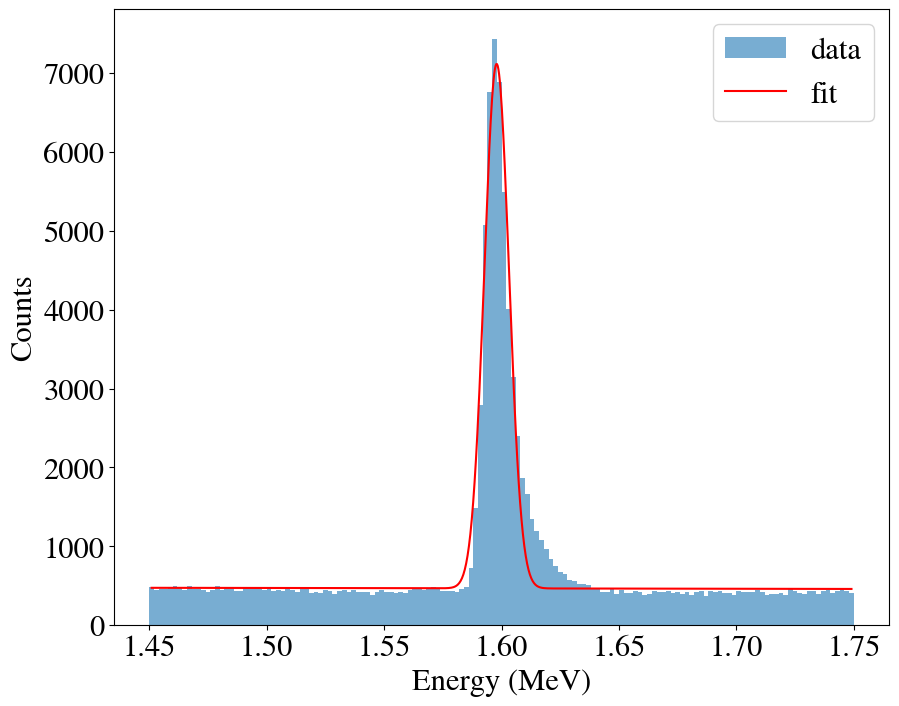

Signal events: 43805.85682904032
Background events: 70020.30406835832
Total Events by addition: 113826.16089739864
Total Events by row counting: 113826
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923, 70020.30406835832]


Blob cut: 0.06 MeV


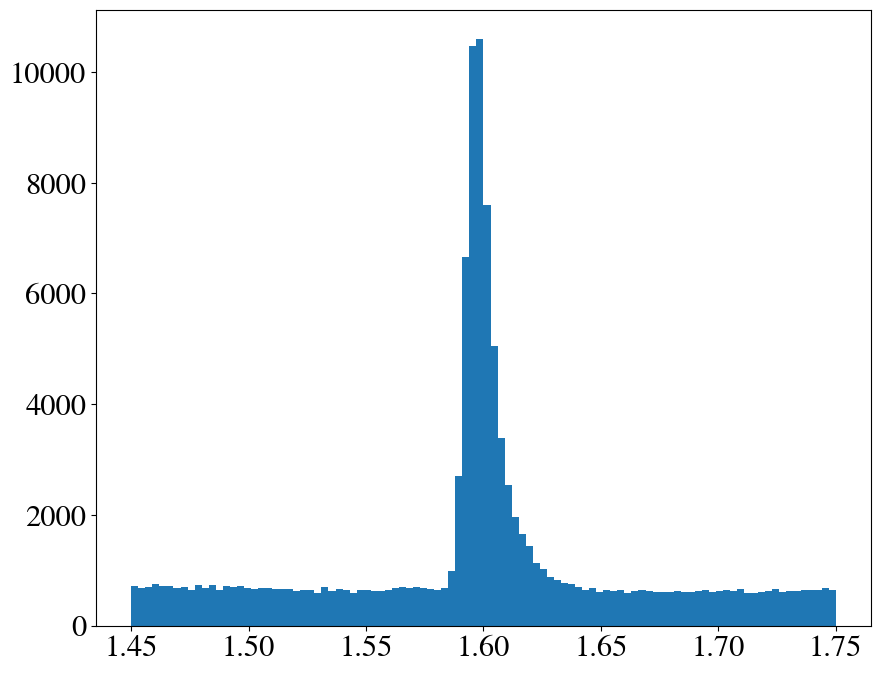

Optimized parameters (popt):
ns: 87.54697741853988
nb: 550.6803891699037
tau: 0.10376872383265437

Covariance matrix (pcov):
ns: [ 1.60383030e+00 -7.03338018e+00 -8.19672966e-04]
nb: [-7.03338018e+00  1.28230188e+05  1.45226329e+02]
tau: [-8.19672966e-04  1.45226329e+02  1.64989805e-01]


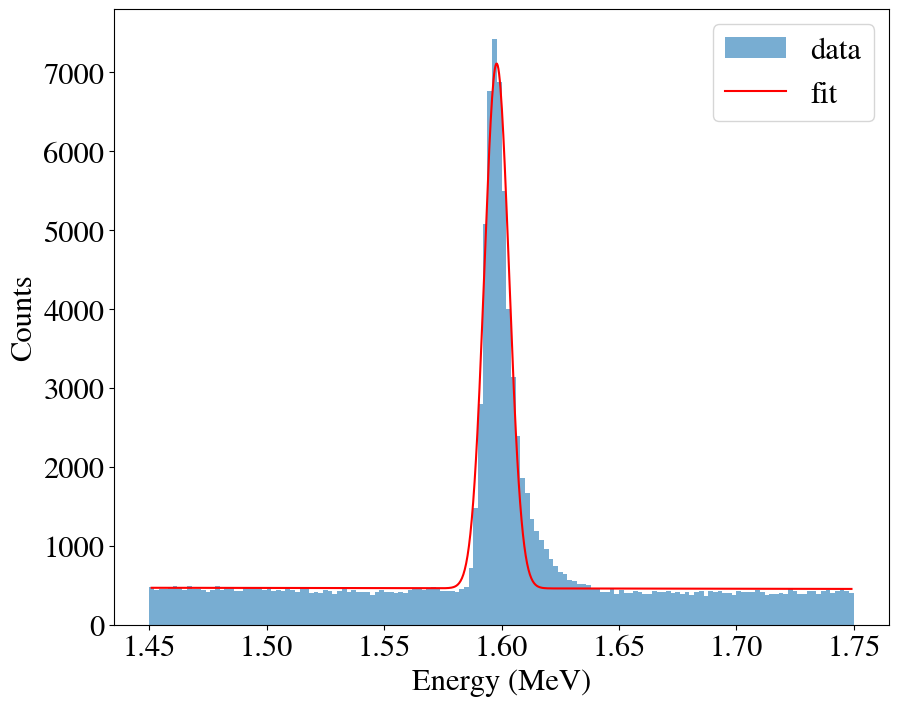

Signal events: 43774.66287120325
Background events: 69968.49925931466
Total Events by addition: 113743.16213051791
Total Events by row counting: 113743
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923, 70020.30406835832, 69968.49925931466]


Blob cut: 0.07 MeV


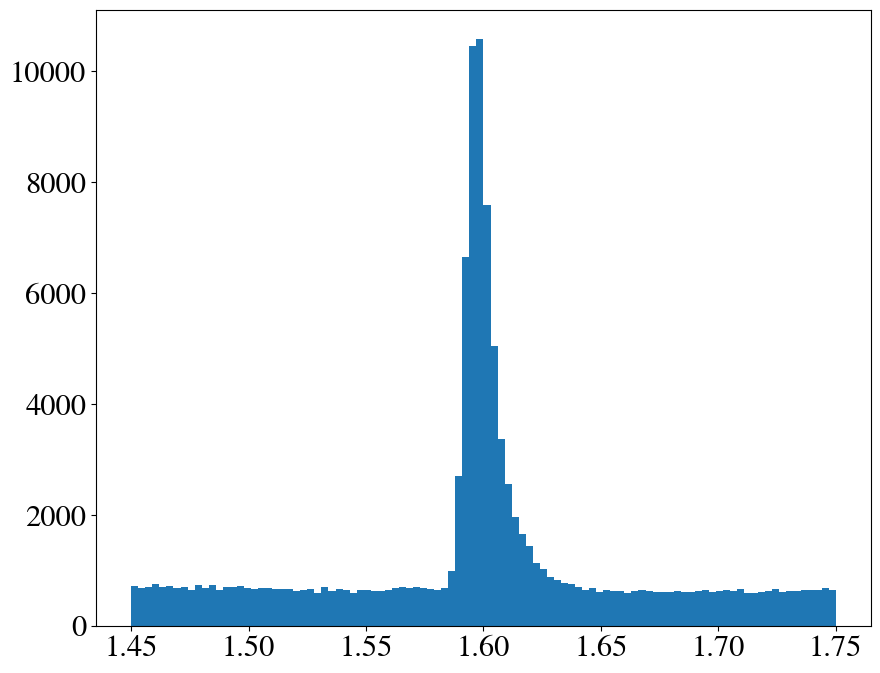

Optimized parameters (popt):
ns: 87.47065549933805
nb: 550.0768469193381
tau: 0.10377009118970913

Covariance matrix (pcov):
ns: [ 1.60051752e+00 -7.01869651e+00 -8.18670529e-04]
nb: [-7.01869651e+00  1.27966335e+05  1.45086267e+02]
tau: [-8.18670529e-04  1.45086267e+02  1.65011248e-01]


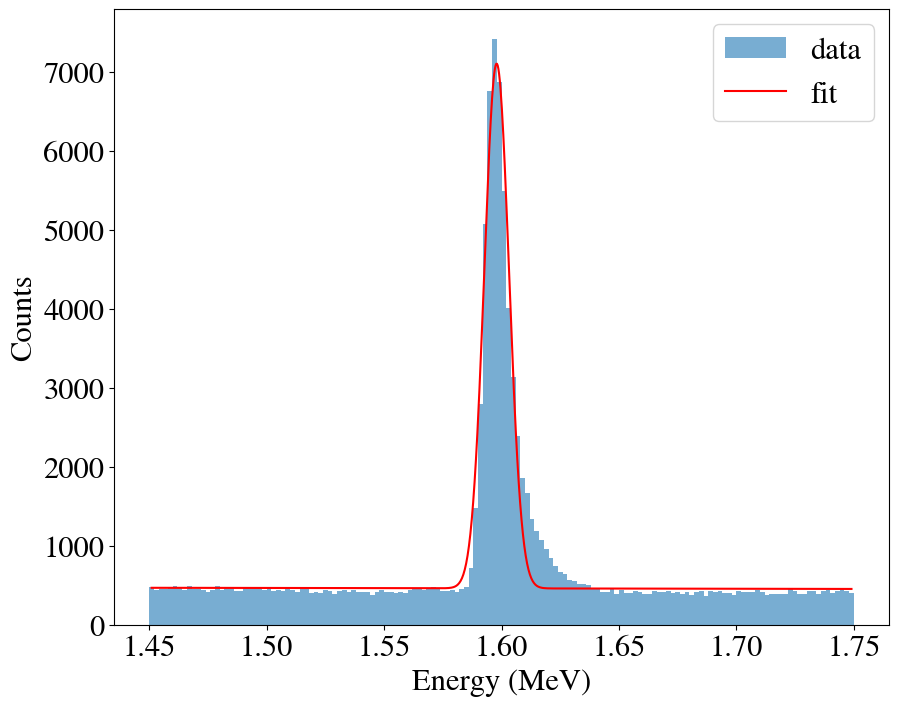

Signal events: 43736.50088798854
Background events: 69891.6613905721
Total Events by addition: 113628.16227856065
Total Events by row counting: 113628
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923, 70020.30406835832, 69968.49925931466, 69891.6613905721]


Blob cut: 0.08 MeV


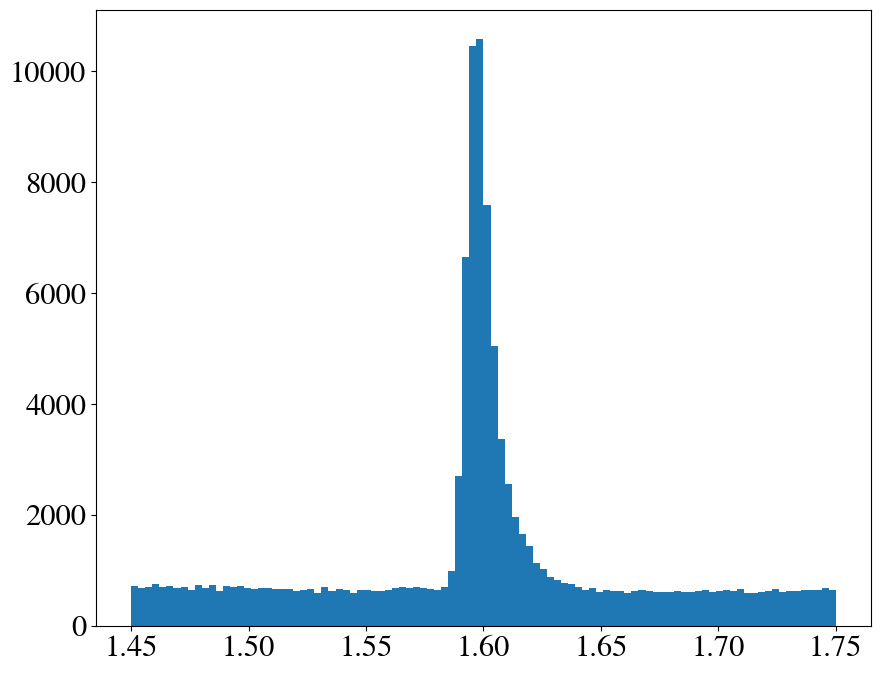

Optimized parameters (popt):
ns: 87.38943874535482
nb: 548.9757027292824
tau: 0.1033621731369789

Covariance matrix (pcov):
ns: [ 1.59614744e+00 -7.00350697e+00 -8.27283672e-04]
nb: [-7.00350697e+00  1.27450931e+05  1.44791473e+02]
tau: [-8.27283672e-04  1.44791473e+02  1.65005954e-01]


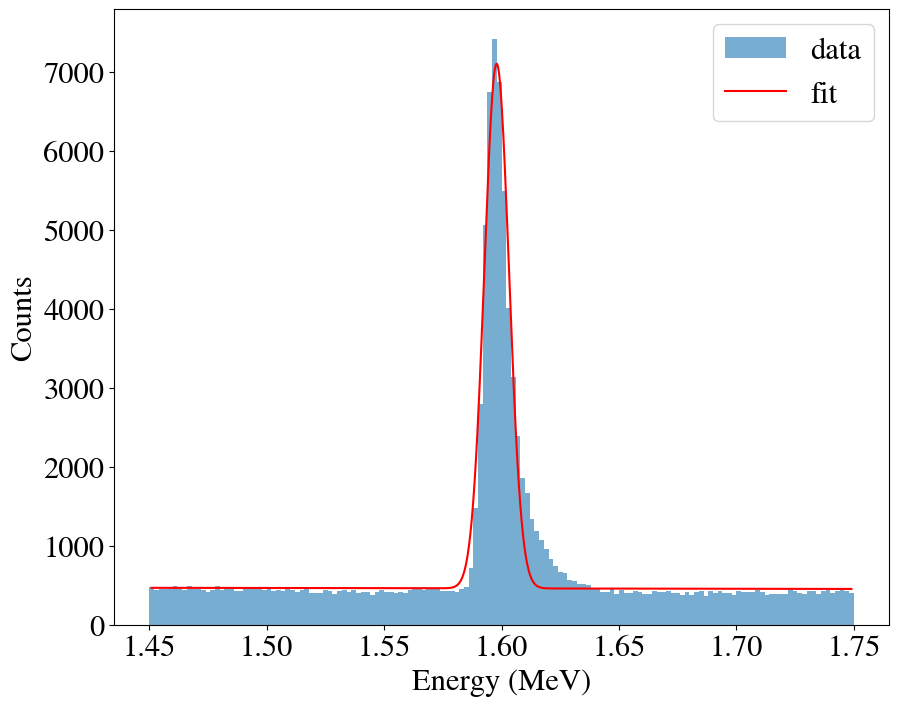

Signal events: 43695.89142173465
Background events: 69797.26973108388
Total Events by addition: 113493.16115281853
Total Events by row counting: 113493
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923, 70020.30406835832, 69968.49925931466, 69891.6613905721, 69797.26973108388]


Blob cut: 0.09 MeV


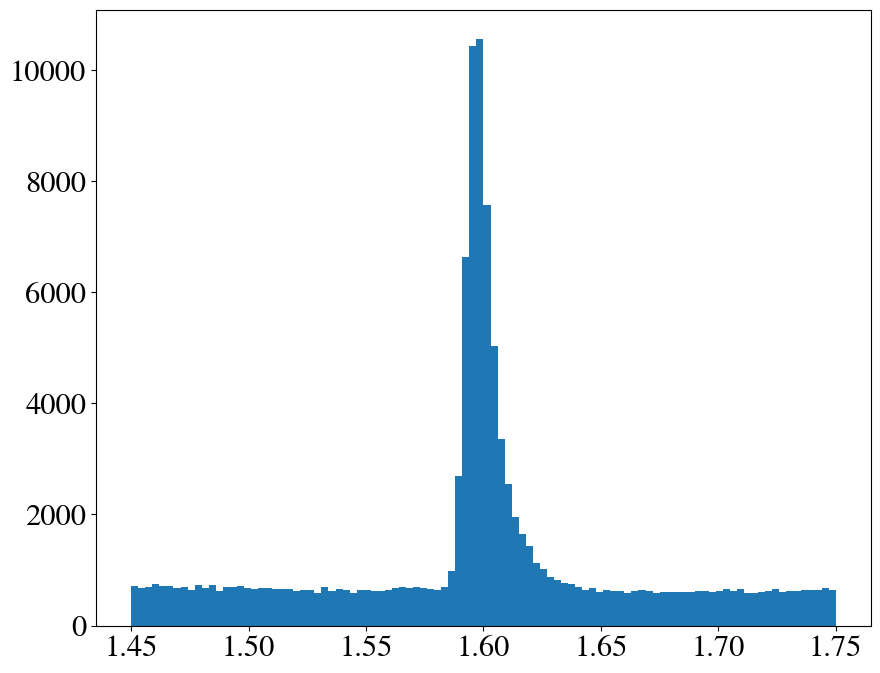

Optimized parameters (popt):
ns: 87.30719323059137
nb: 549.7908811651537
tau: 0.1054545766211705

Covariance matrix (pcov):
ns: [ 1.59613375e+00 -6.98474060e+00 -7.80878445e-04]
nb: [-6.98474060e+00  1.28299570e+05  1.45543215e+02]
tau: [-7.80878445e-04  1.45543215e+02  1.65621012e-01]


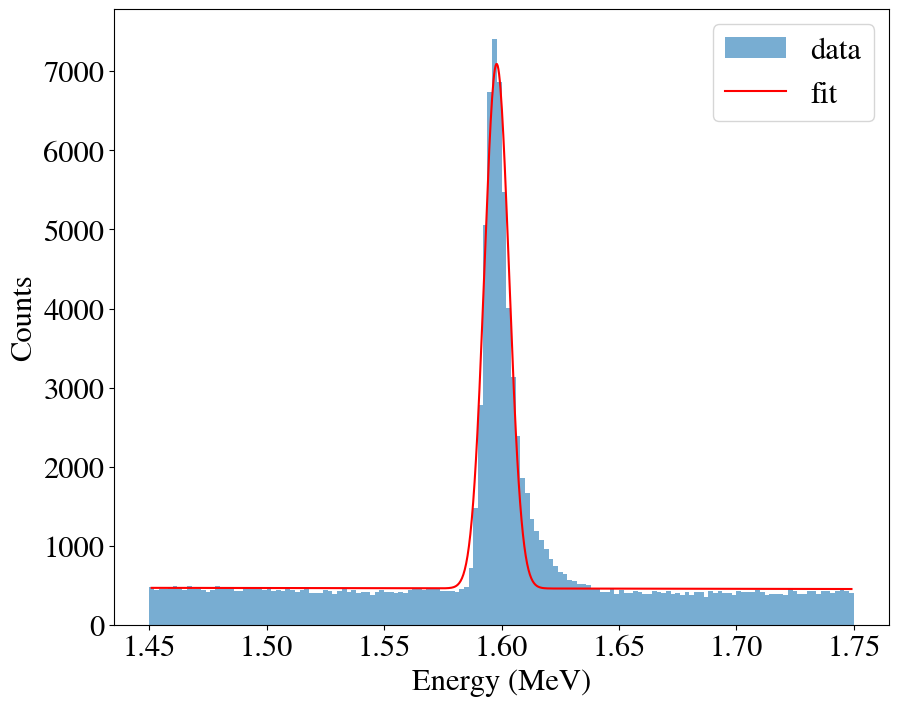

Signal events: 43654.7675612931
Background events: 69667.4003855286
Total Events by addition: 113322.16794682169
Total Events by row counting: 113322
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465, 43654.7675612931]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923, 70020.30406835832, 69968.49925931466, 69891.6613905721, 69797.26973108388, 69667.4003855286]


Blob cut: 0.1 MeV


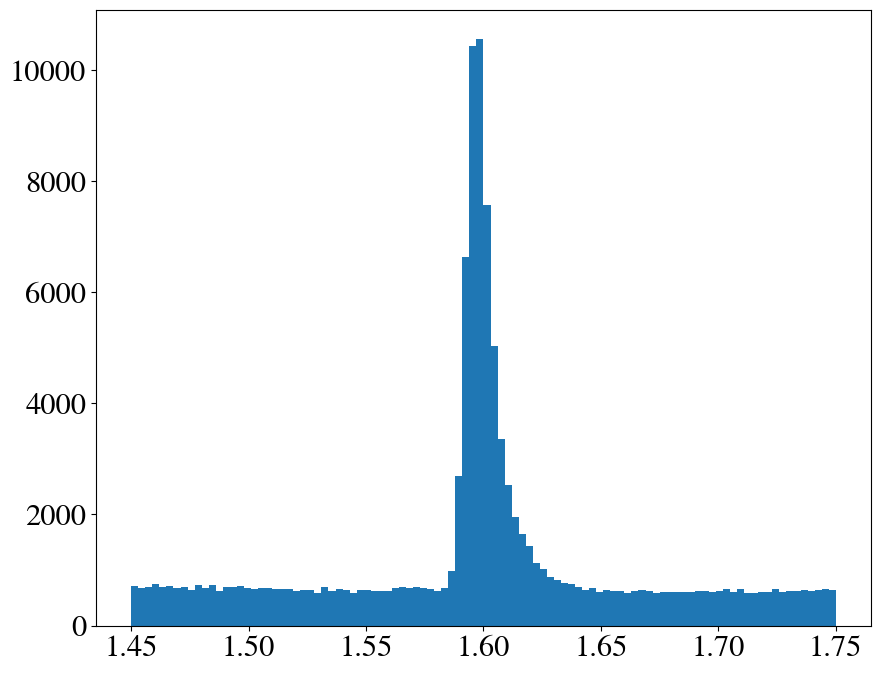

Optimized parameters (popt):
ns: 87.25485374739478
nb: 554.3675149974604
tau: 0.1122003979460308

Covariance matrix (pcov):
ns: [ 1.59673520e+00 -6.92634769e+00 -6.28799381e-04]
nb: [-6.92634769e+00  1.31130889e+05  1.47537269e+02]
tau: [-6.28799381e-04  1.47537269e+02  1.66515753e-01]


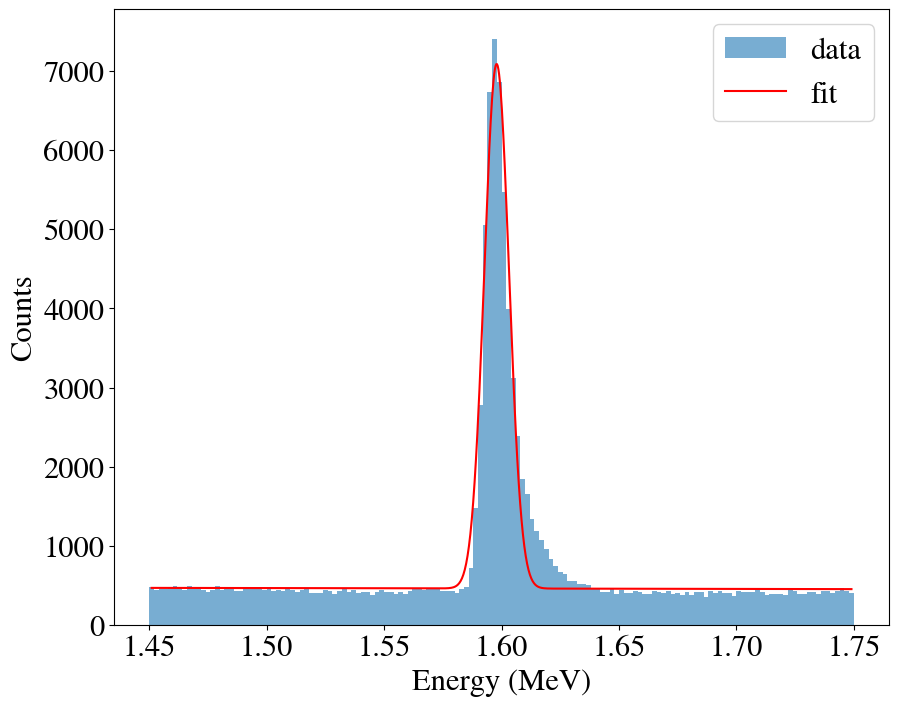

Signal events: 43628.5971177285
Background events: 69493.59257728313
Total Events by addition: 113122.18969501162
Total Events by row counting: 113122
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465, 43654.7675612931, 43628.5971177285]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923, 70020.30406835832, 69968.49925931466, 69891.6613905721, 69797.26973108388, 69667.400385

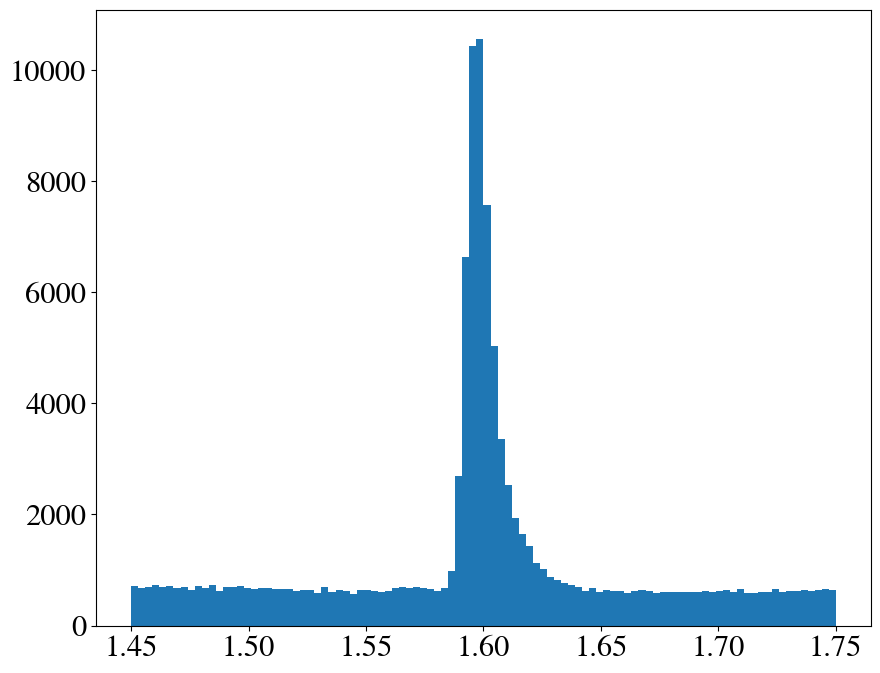

Optimized parameters (popt):
ns: 87.17563846852403
nb: 553.0701533206694
tau: 0.11265836848677233

Covariance matrix (pcov):
ns: [ 1.59572490e+00 -6.91733943e+00 -6.19379201e-04]
nb: [-6.91733943e+00  1.31238706e+05  1.48005776e+02]
tau: [-6.19379201e-04  1.48005776e+02  1.67437315e-01]


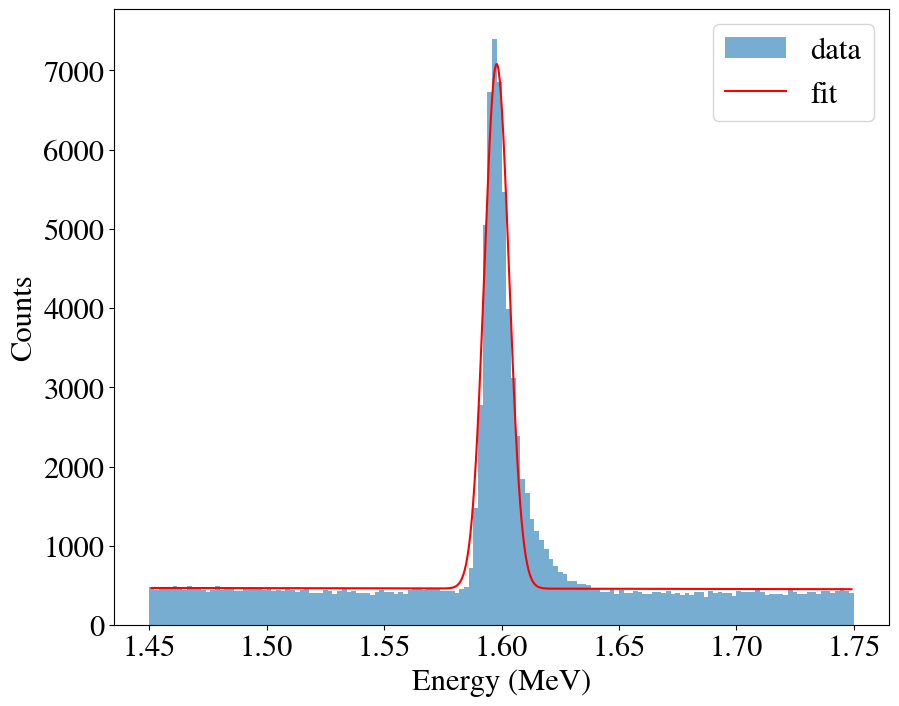

Signal events: 43588.988415874206
Background events: 69280.20274343378
Total Events by addition: 112869.19115930799
Total Events by row counting: 112869
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465, 43654.7675612931, 43628.5971177285, 43588.988415874206]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 70101.63116689787, 70055.50460533923, 70020.30406835832, 6996

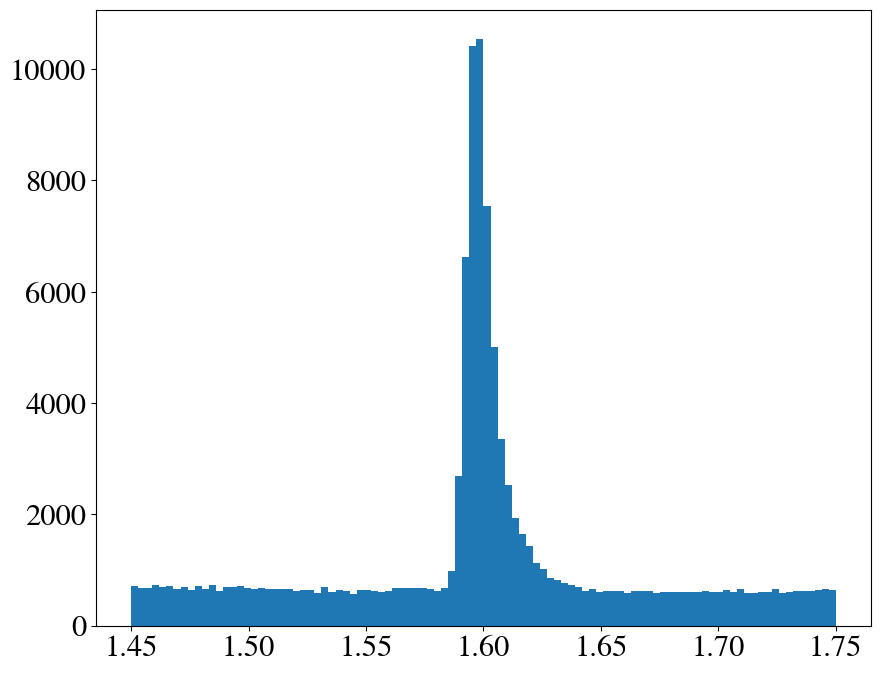

Optimized parameters (popt):
ns: 87.08719515826306
nb: 558.3605539234966
tau: 0.12197620267917497

Covariance matrix (pcov):
ns: [ 1.58775973e+00 -6.79509210e+00 -4.05668587e-04]
nb: [-6.79509210e+00  1.34509386e+05  1.50272260e+02]
tau: [-4.05668587e-04  1.50272260e+02  1.68407763e-01]


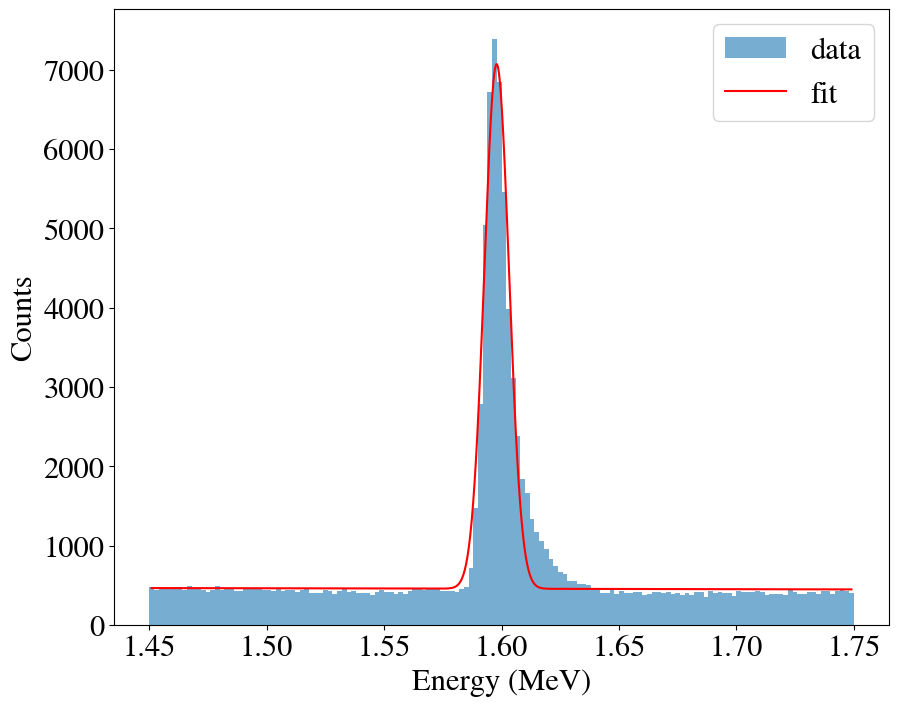

Signal events: 43544.765574560355
Background events: 68908.45734483926
Total Events by addition: 112453.22291939962
Total Events by row counting: 112453
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465, 43654.7675612931, 43628.5971177285, 43588.988415874206, 43544.765574560355]
nb_l: [70127.11302942775, 70127.11302942775, 70123.91335922861, 

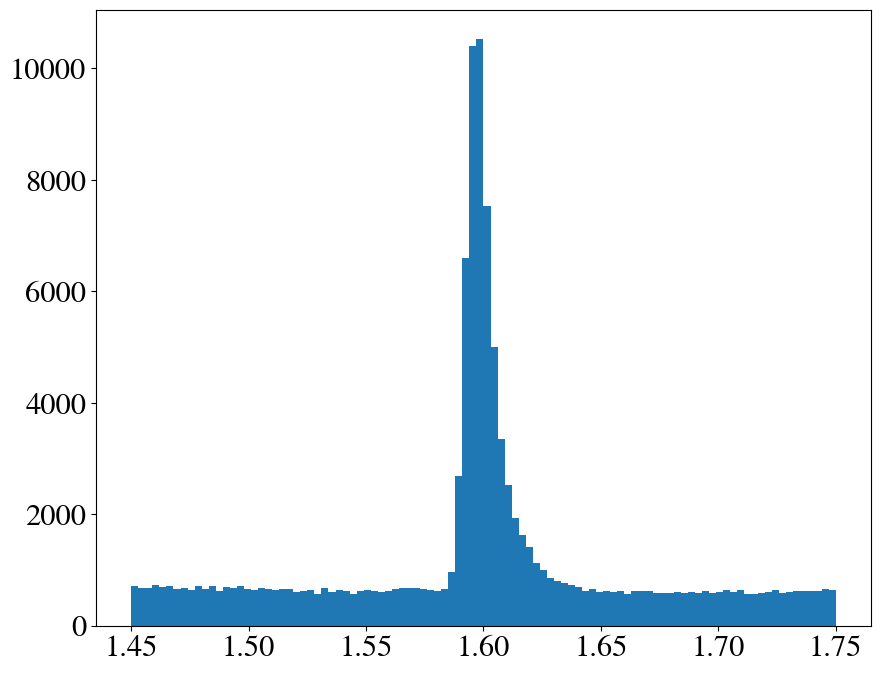

Optimized parameters (popt):
ns: 87.0205305965953
nb: 561.298925826418
tau: 0.13207153348973338

Covariance matrix (pcov):
ns: [ 1.58747644e+00 -6.69382432e+00 -1.75376211e-04]
nb: [-6.69382432e+00  1.38871407e+05  1.54350209e+02]
tau: [-1.75376211e-04  1.54350209e+02  1.72091289e-01]


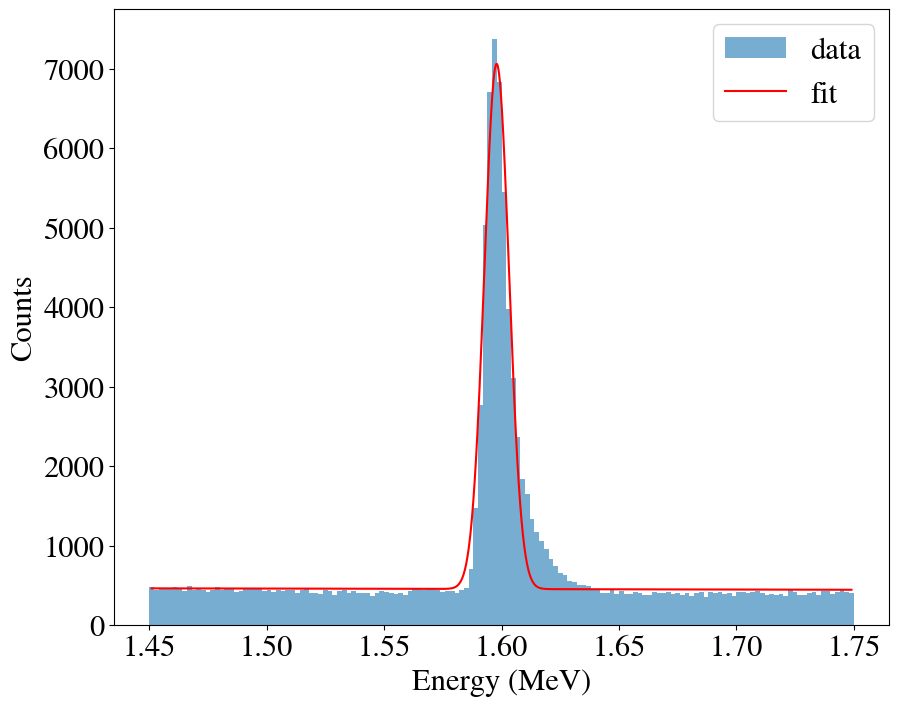

Signal events: 43511.432399635174
Background events: 68161.82909549026
Total Events by addition: 111673.26149512544
Total Events by row counting: 111673
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465, 43654.7675612931, 43628.5971177285, 43588.988415874206, 43544.765574560355, 43511.432399635174]
nb_l

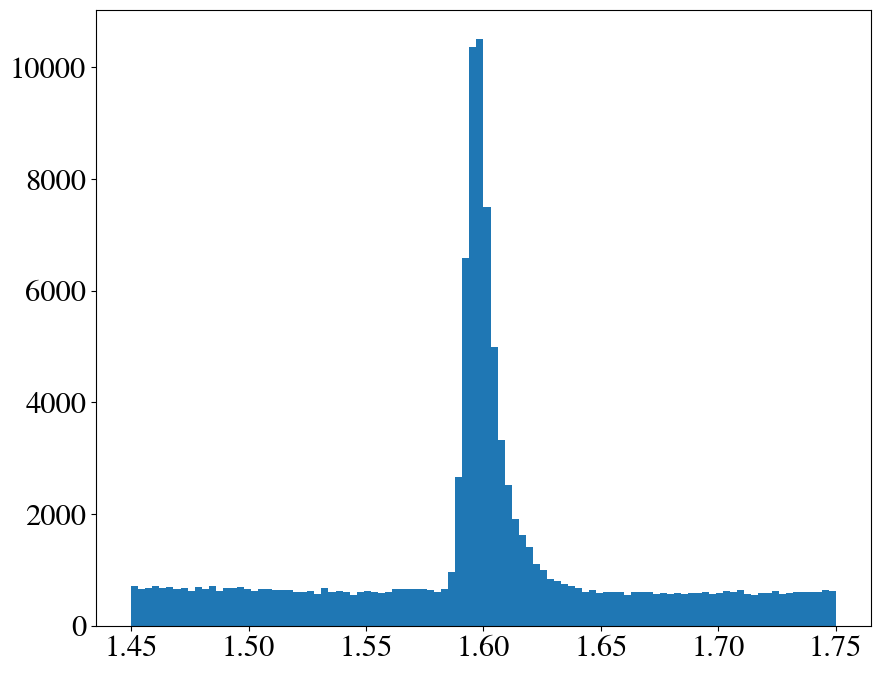

Optimized parameters (popt):
ns: 86.90915455133594
nb: 563.5712589035741
tau: 0.14604545524249155

Covariance matrix (pcov):
ns: [ 1.58544192e+00 -6.53864442e+00  1.51952394e-04]
nb: [-6.53864442e+00  1.44993143e+05  1.60529191e+02]
tau: [1.51952394e-04 1.60529191e+02 1.78286364e-01]


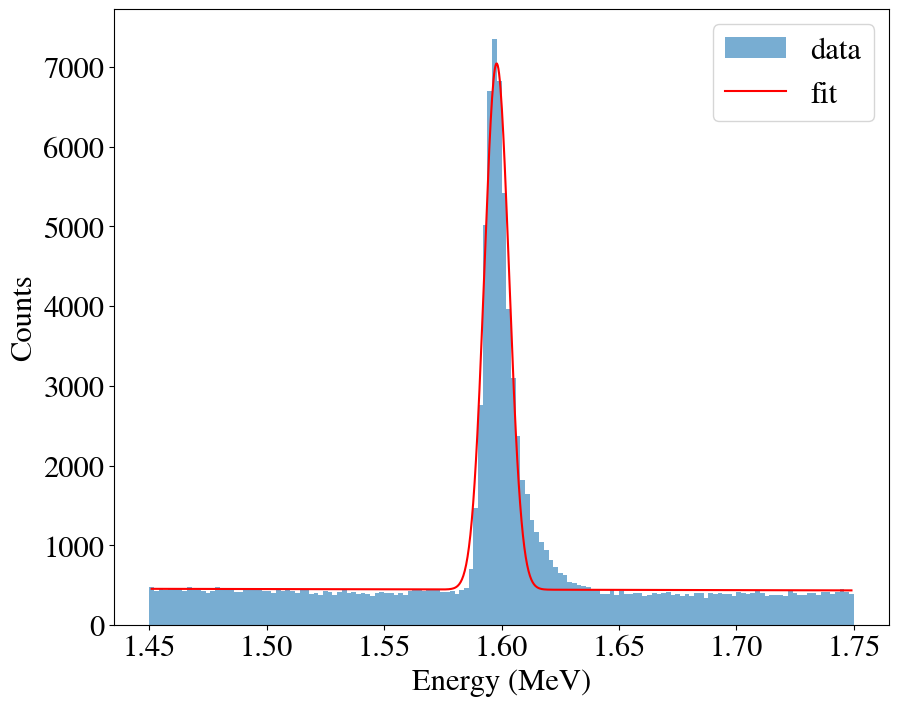

Signal events: 43455.74288325306
Background events: 66925.57662159172
Total Events by addition: 110381.31950484478
Total Events by row counting: 110381
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465, 43654.7675612931, 43628.5971177285, 43588.988415874206, 4354

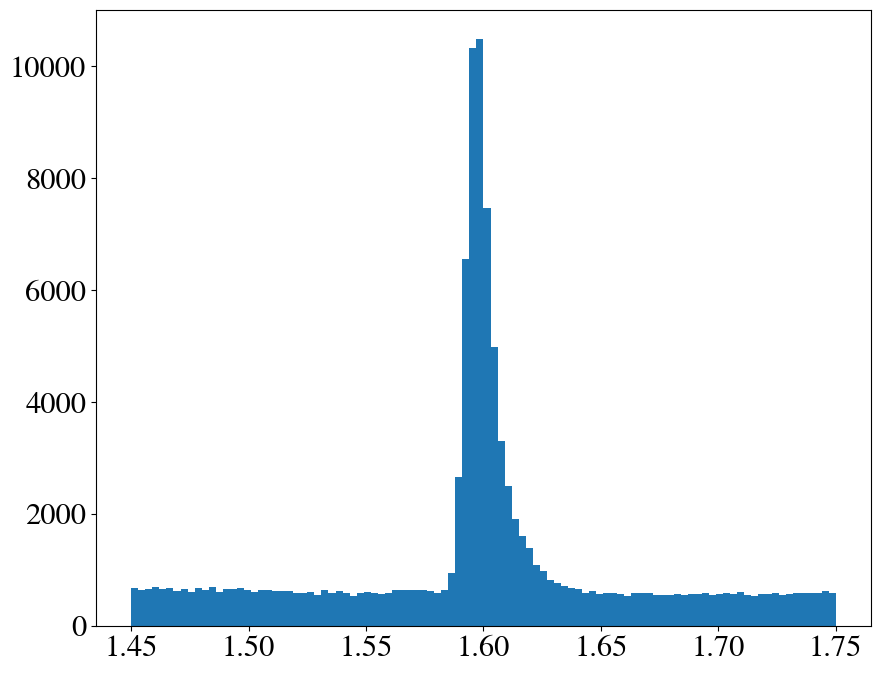

Optimized parameters (popt):
ns: 86.8131168777523
nb: 572.6145775494784
tau: 0.1765978518449814

Covariance matrix (pcov):
ns: [ 1.57949750e+00 -6.15965037e+00  9.00141766e-04]
nb: [-6.15965037e+00  1.59187335e+05  1.73516943e+02]
tau: [9.00141766e-04 1.73516943e+02 1.89728863e-01]


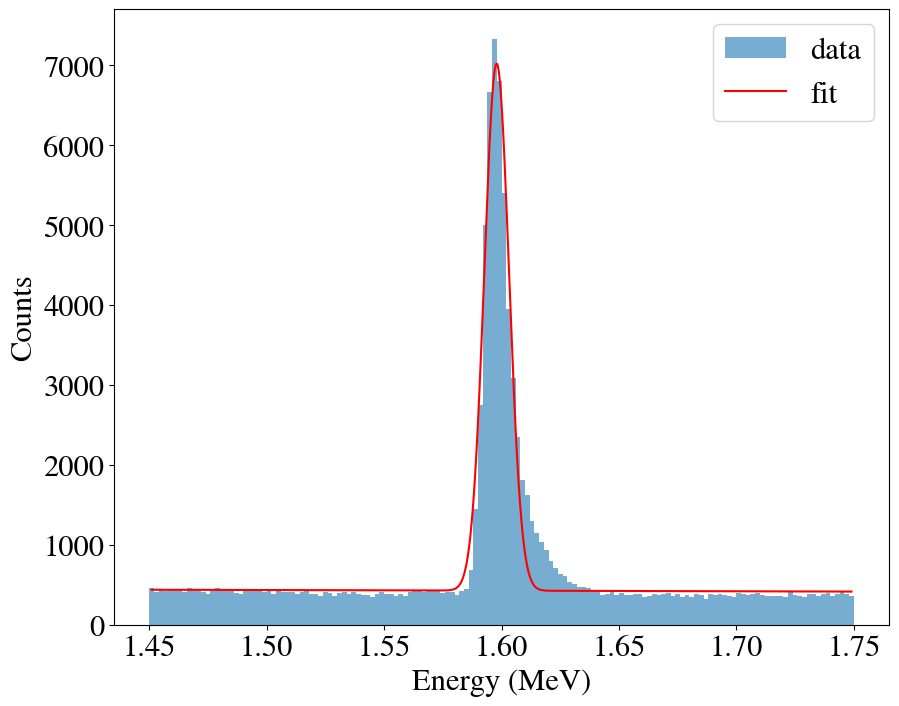

Signal events: 43407.722758423835
Background events: 64757.75316424782
Total Events by addition: 108165.47592267166
Total Events by row counting: 108165
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.50088798854, 43695.89142173465, 43654.7675612931,

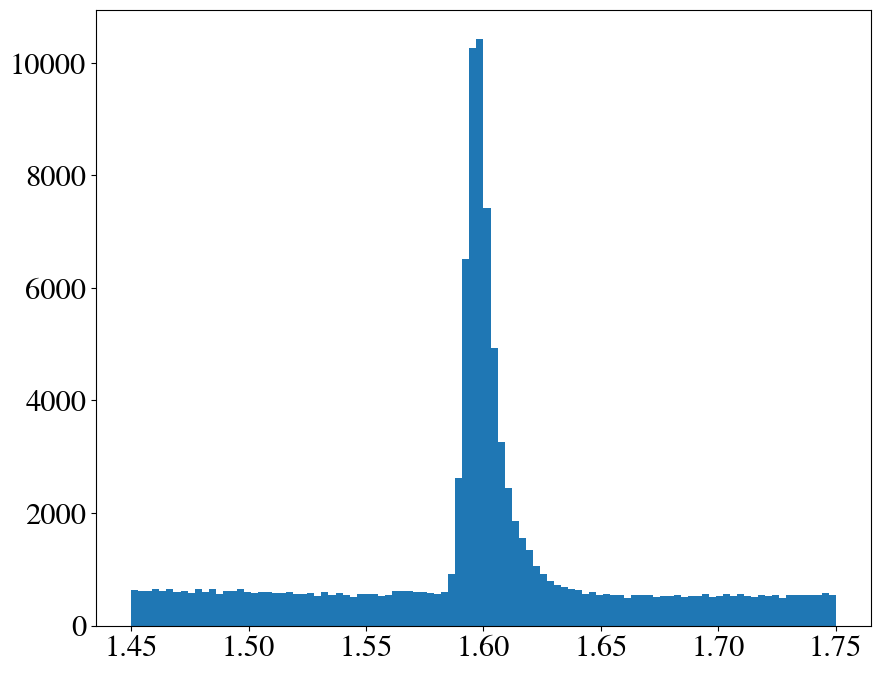

Optimized parameters (popt):
ns: 86.6177059189636
nb: 580.3631724778933
tau: 0.21714671681385828

Covariance matrix (pcov):
ns: [ 1.56386801e+00 -5.55328740e+00  1.96712789e-03]
nb: [-5.55328740e+00  1.79309462e+05  1.92921109e+02]
tau: [1.96712789e-03 1.92921109e+02 2.08216495e-01]


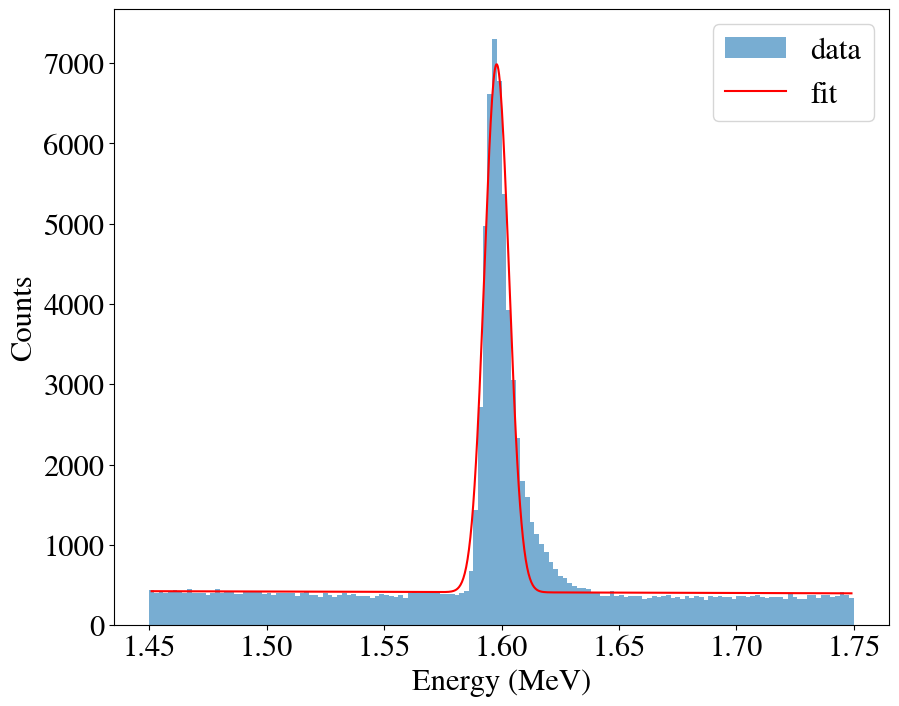

Signal events: 43310.01465821816
Background events: 61514.712532008125
Total Events by addition: 104824.72719022629
Total Events by row counting: 104824
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.85682904032, 43774.66287120325, 43736.5008879

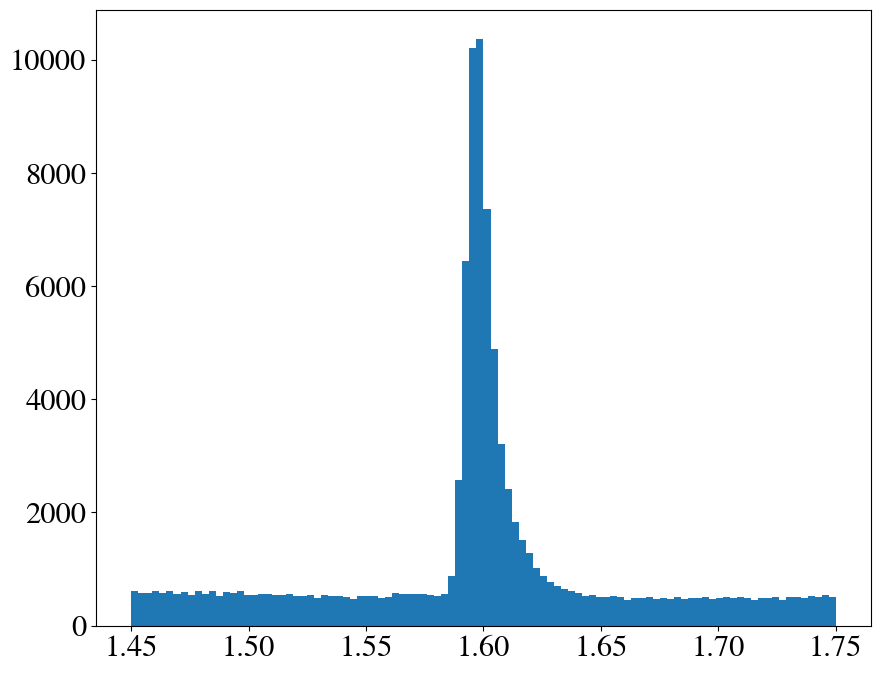

Optimized parameters (popt):
ns: 86.3866918031687
nb: 574.976181939688
tau: 0.2544611245999476

Covariance matrix (pcov):
ns: [ 1.54737174e+00 -4.91015373e+00  3.09020039e-03]
nb: [-4.91015373e+00  1.99796131e+05  2.17050135e+02]
tau: [3.09020039e-03 2.17050135e+02 2.36533379e-01]


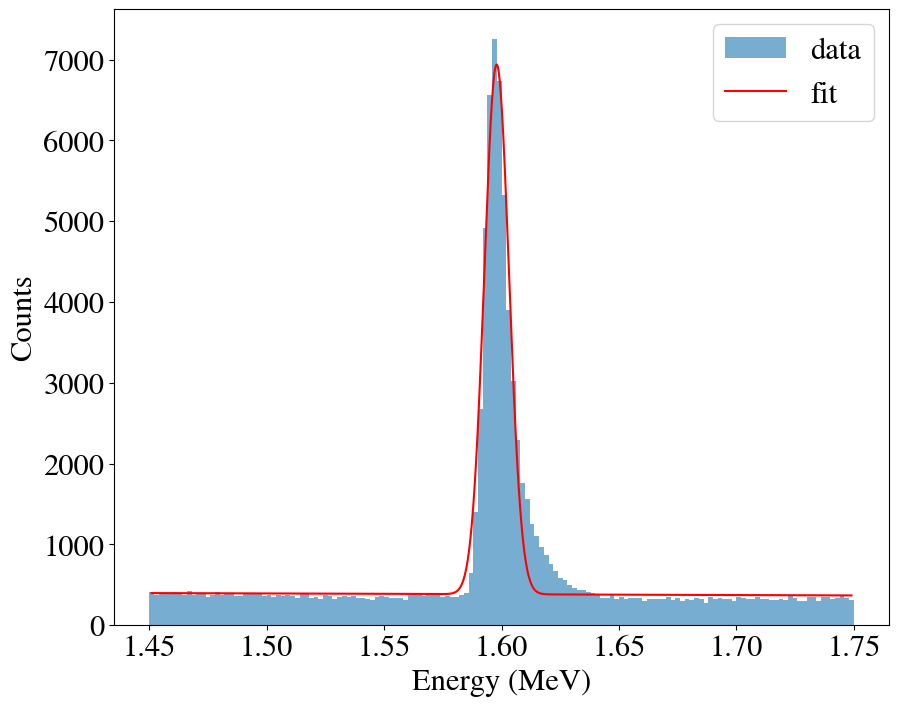

Signal events: 43194.50450200724
Background events: 57415.476623139184
Total Events by addition: 100609.98112514643
Total Events by row counting: 100609
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773, 0.007991523364243905]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.53393756149, 43820.66288662123, 43805.856

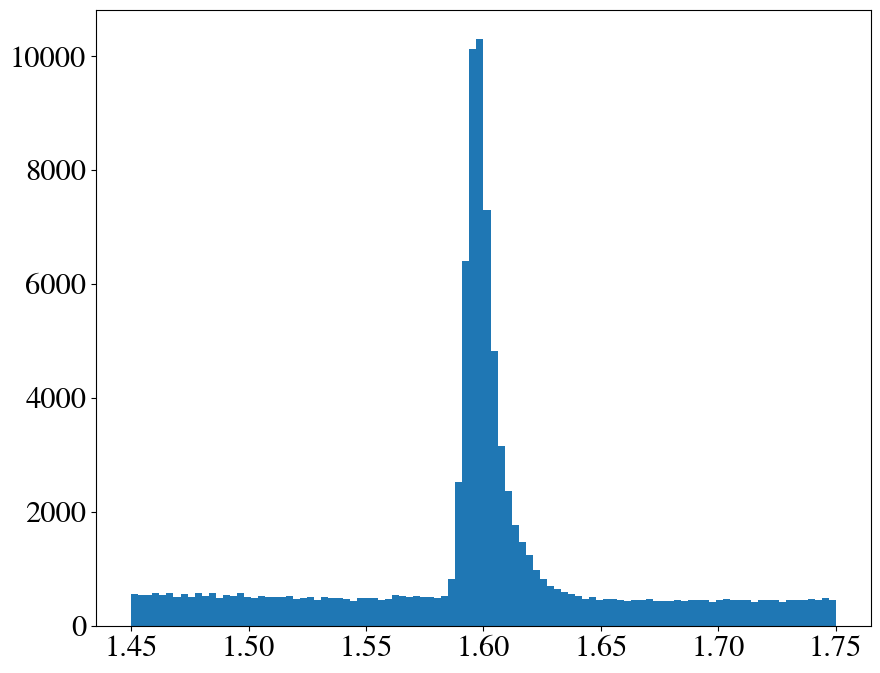

Optimized parameters (popt):
ns: 86.14619115940155
nb: 574.0820140786557
tau: 0.30530281552632454

Covariance matrix (pcov):
ns: [ 1.5364345  -3.93424659  0.00481157]
nb: [-3.93424659e+00  2.33271063e+05  2.53911125e+02]
tau: [4.81157411e-03 2.53911125e+02 2.77244290e-01]


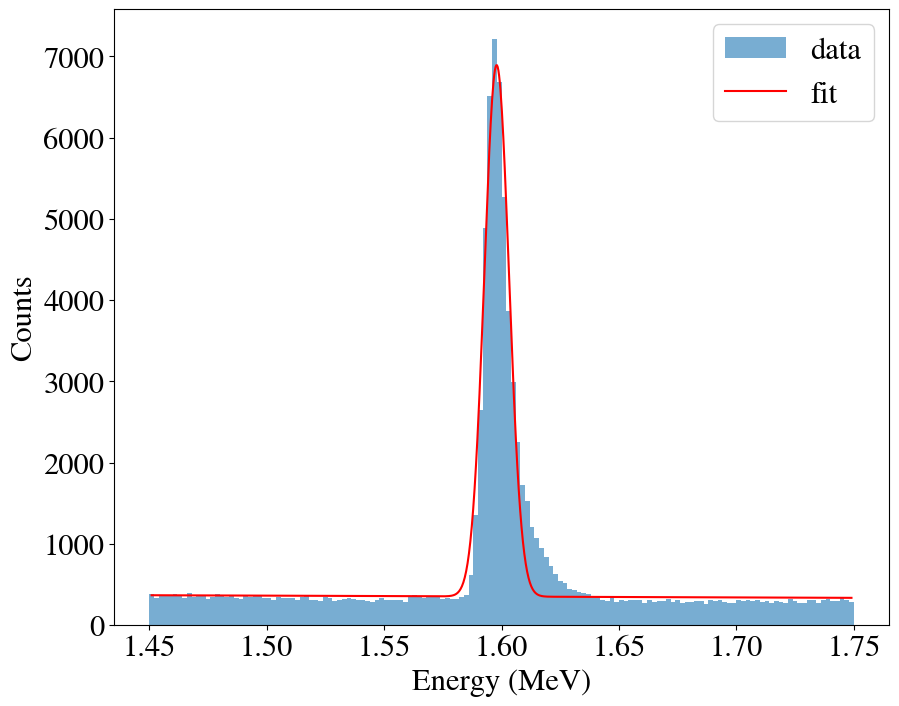

Signal events: 43074.25095457882
Background events: 52853.16506349925
Total Events by addition: 95927.41601807807
Total Events by row counting: 95926
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773, 0.007991523364243905, 0.00833999782794836]
ns_l: [43846.05332831623, 43846.05332831623, 43846.25272198082, 43838.5339

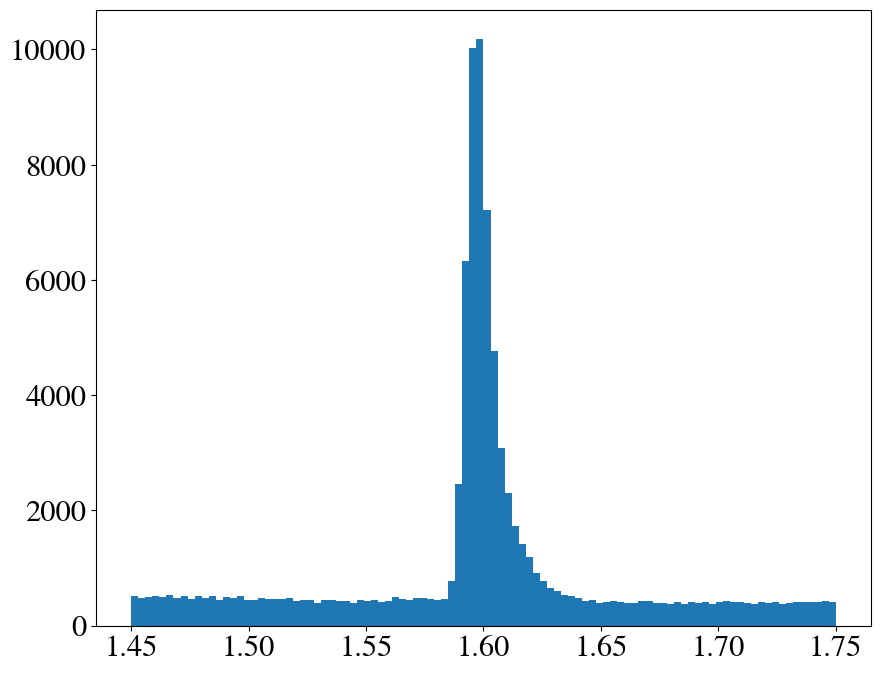

Optimized parameters (popt):
ns: 85.6518657805328
nb: 555.6069857419411
tau: 0.3403403001981927

Covariance matrix (pcov):
ns: [ 1.51658228 -3.13219831  0.00629024]
nb: [-3.13219831e+00  2.57481318e+05  2.89648020e+02]
tau: [6.29023979e-03 2.89648020e+02 3.26855484e-01]


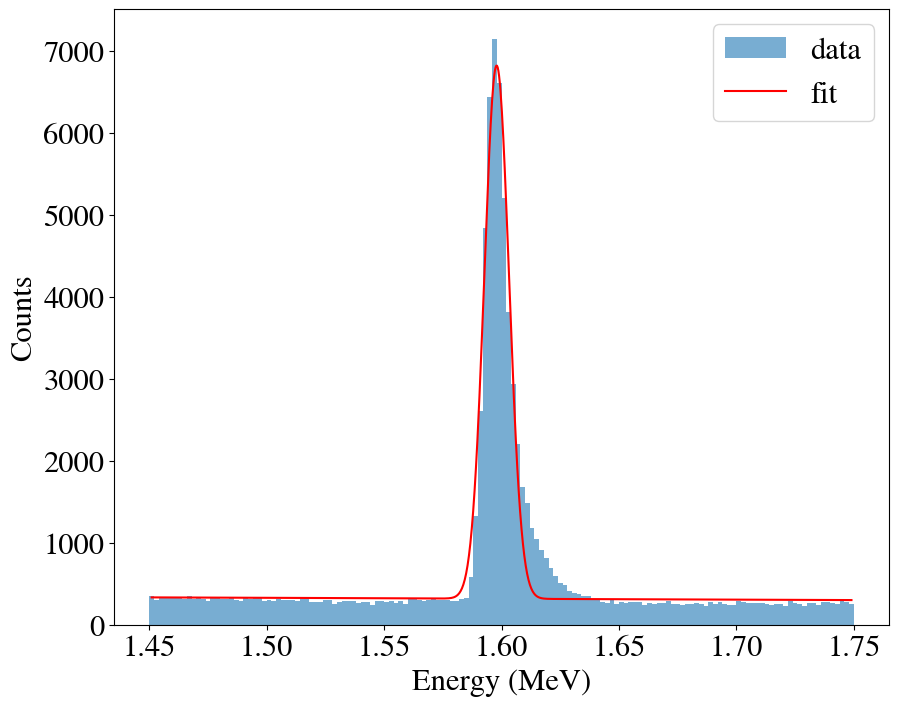

Signal events: 42827.081635354814
Background events: 48367.65910714946
Total Events by addition: 91194.74074250428
Total Events by row counting: 91193
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773, 0.007991523364243905, 0.00833999782794836, 0.008713686497351221]
ns_l: [43846.05332831623, 43846

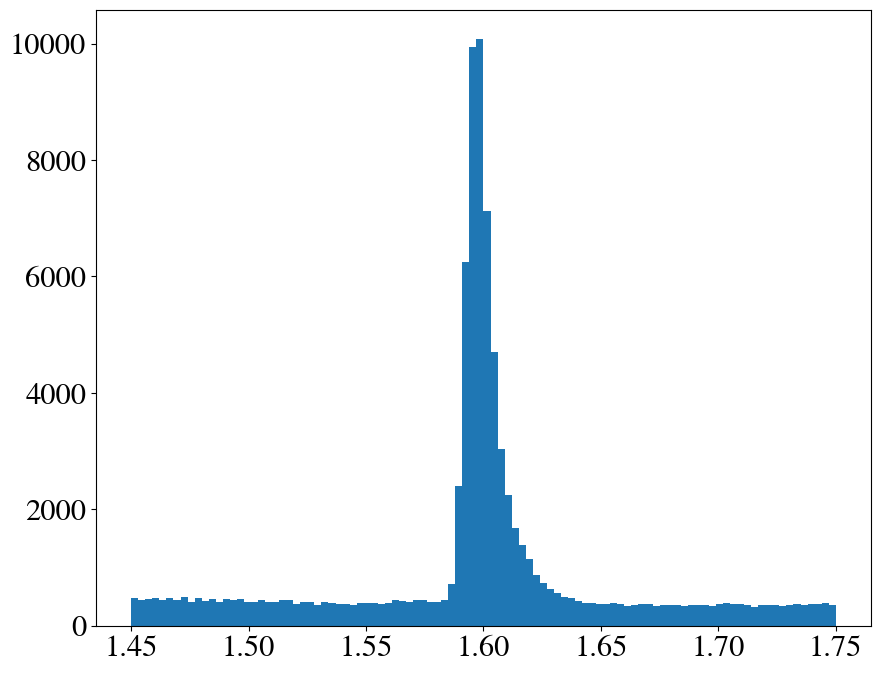

Optimized parameters (popt):
ns: 85.13759908464912
nb: 519.2387442166416
tau: 0.35607084673388467

Covariance matrix (pcov):
ns: [ 1.51395745 -2.75956223  0.00742976]
nb: [-2.75956223e+00  2.70242736e+05  3.25340468e+02]
tau: [7.42975753e-03 3.25340468e+02 3.92900560e-01]


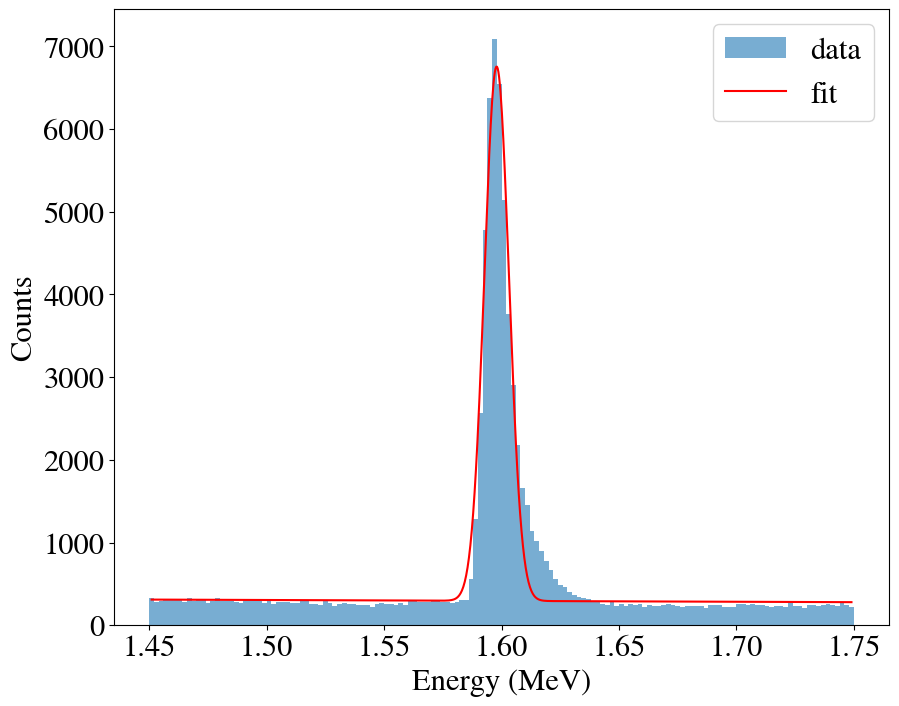

Signal events: 42569.94139017454
Background events: 44080.0017775933
Total Events by addition: 86649.94316776784
Total Events by row counting: 86648
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773, 0.007991523364243905, 0.00833999782794836, 0.008713686497351221, 0.00912589175

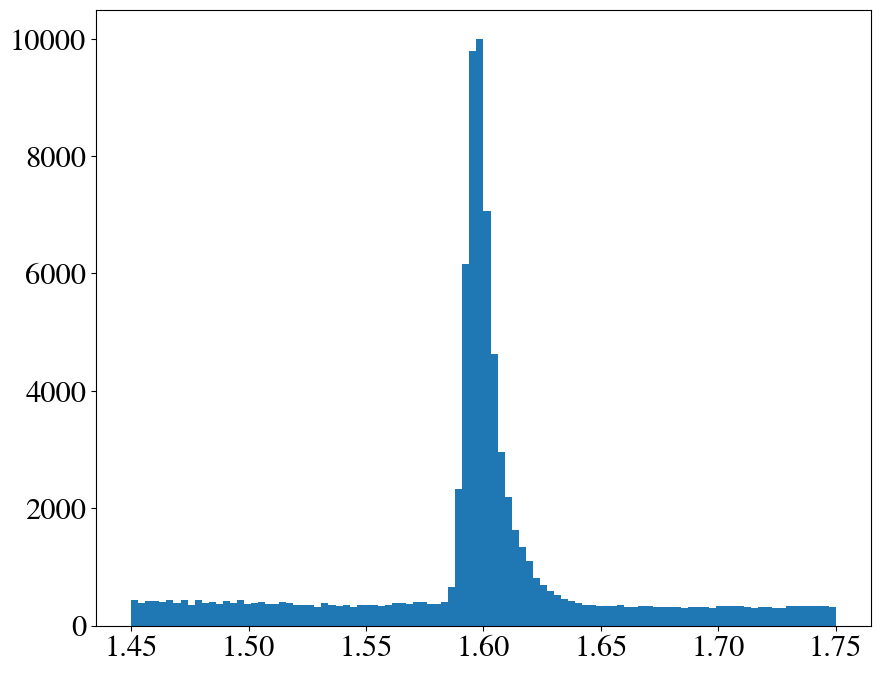

Optimized parameters (popt):
ns: 84.597659722899
nb: 478.2866165993862
tau: 0.3629135050955551

Covariance matrix (pcov):
ns: [ 1.48123897 -2.53830281  0.00822893]
nb: [-2.53830281e+00  2.70189350e+05  3.53173410e+02]
tau: [8.22892568e-03 3.53173410e+02 4.63093119e-01]


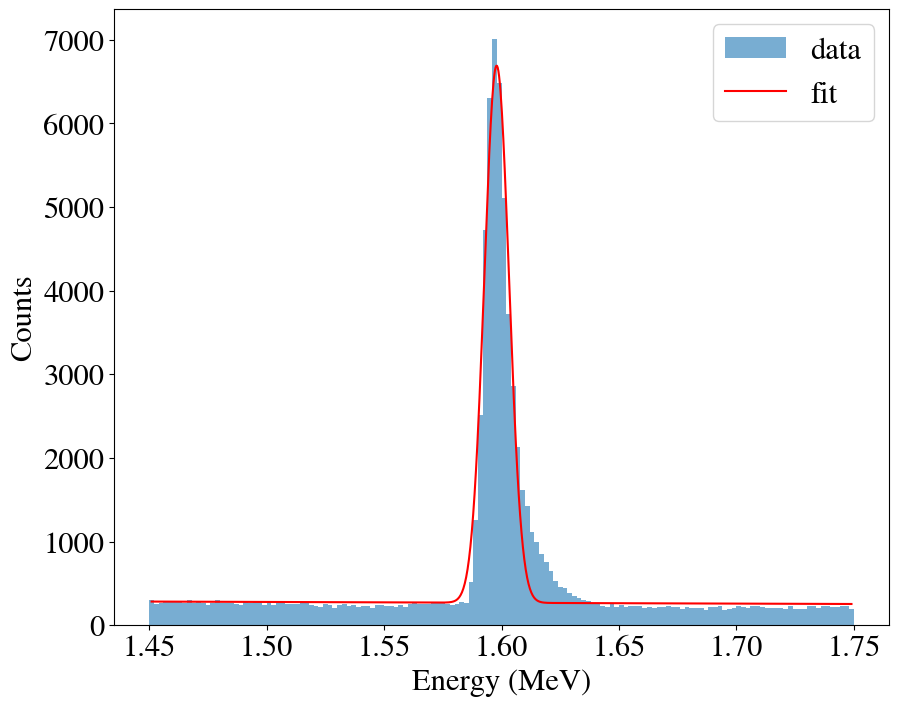

Signal events: 42299.964467744576
Background events: 40162.06073755353
Total Events by addition: 82462.02520529811
Total Events by row counting: 82460
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773, 0.007991523364243905, 0.00833999782794836, 0.00871368649

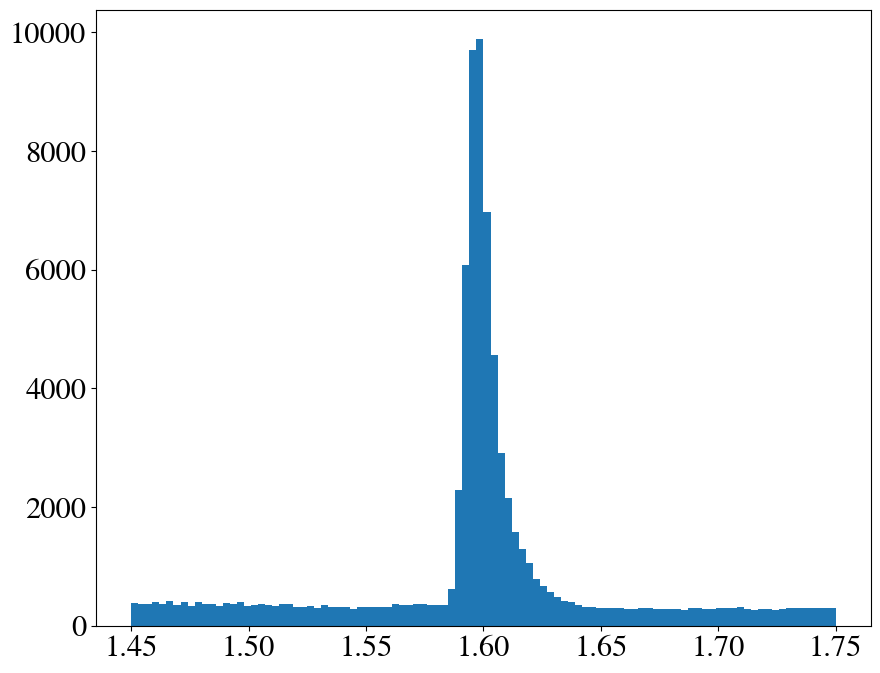

Optimized parameters (popt):
ns: 83.94713148776165
nb: 454.29760384395826
tau: 0.38666571905363545

Covariance matrix (pcov):
ns: [ 1.46440841 -1.91916675  0.0098455 ]
nb: [-1.91916675e+00  2.88160404e+05  3.96602885e+02]
tau: [9.84549766e-03 3.96602885e+02 5.47568124e-01]


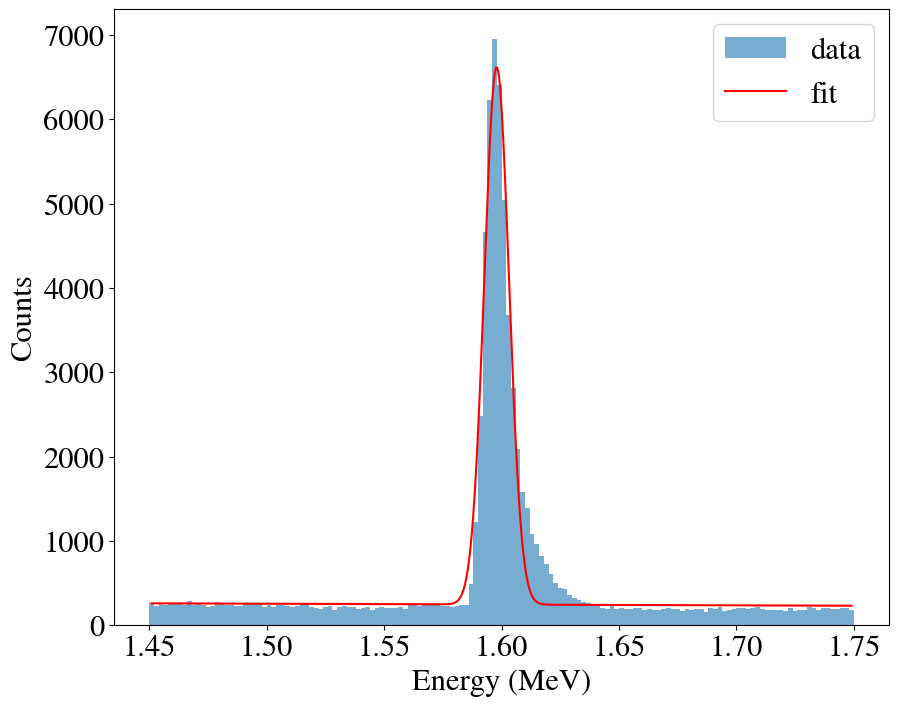

Signal events: 41974.6916254259
Background events: 36727.59381233076
Total Events by addition: 78702.28543775665
Total Events by row counting: 78700
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773, 0.007991523364243905, 0.00833999782794

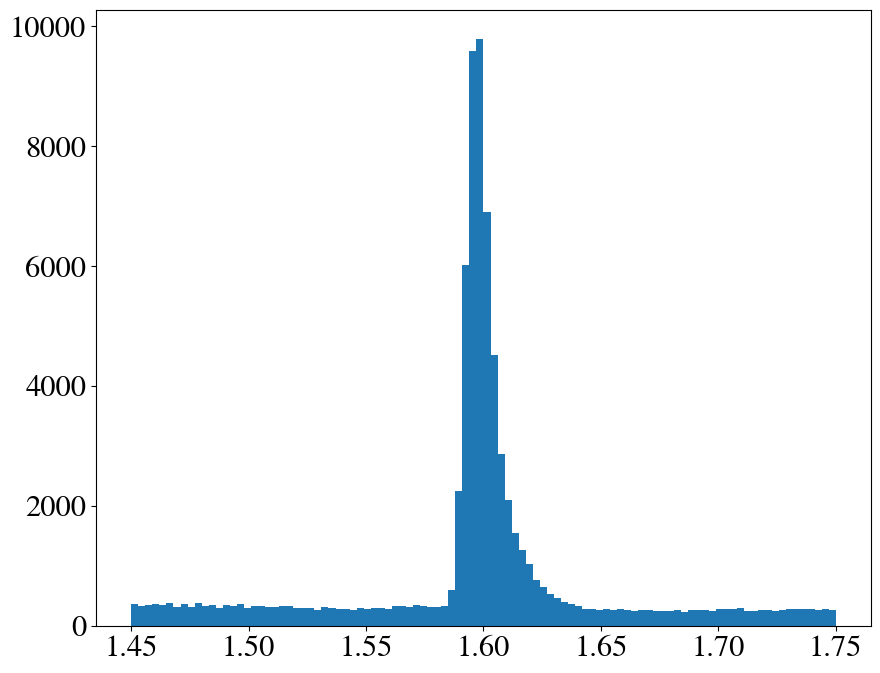

Optimized parameters (popt):
ns: 83.25077256380284
nb: 421.83305868144754
tau: 0.39296150084517867

Covariance matrix (pcov):
ns: [ 1.43736944 -1.72453212  0.01077746]
nb: [-1.72453212e+00  2.88520025e+05  4.27718436e+02]
tau: [1.07774596e-02 4.27718436e+02 6.36063891e-01]


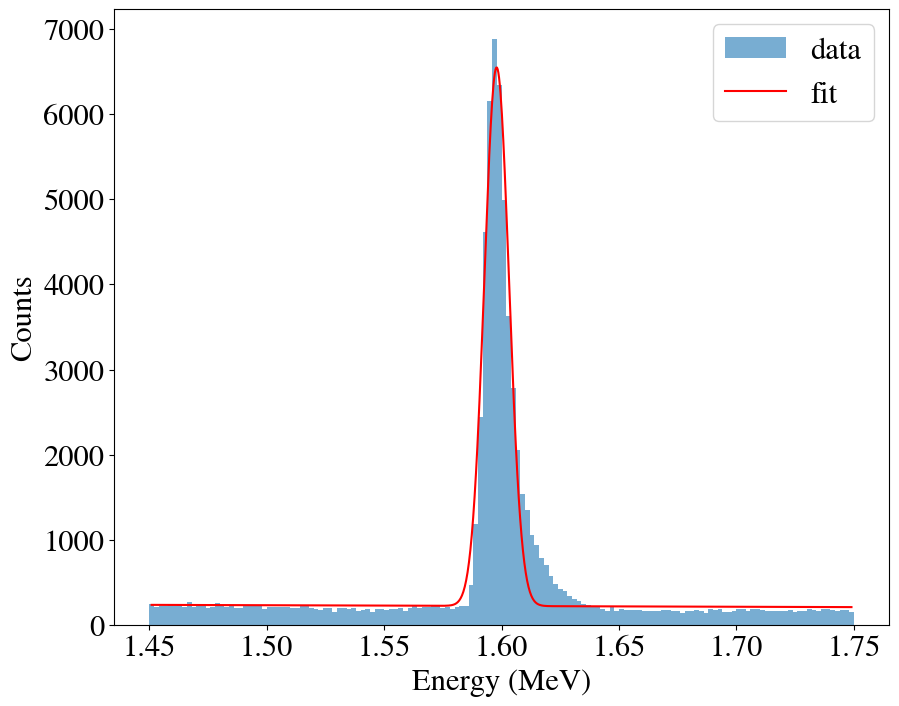

Signal events: 41626.5028240248
Background events: 33761.822303391265
Total Events by addition: 75388.32512741606
Total Events by row counting: 75386
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.007715986011841773, 0.007991523364243

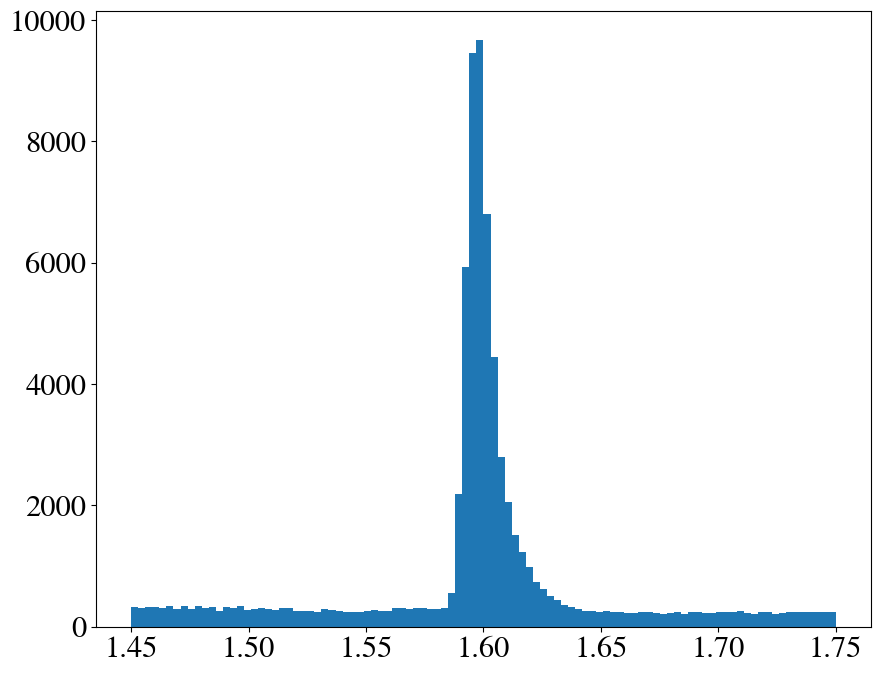

Optimized parameters (popt):
ns: 82.41559031924047
nb: 400.2367014147573
tau: 0.41182690399422506

Covariance matrix (pcov):
ns: [ 1.40621222 -1.19362308  0.01230741]
nb: [-1.19362308e+00  2.99782126e+05  4.68444818e+02]
tau: [1.23074103e-02 4.68444818e+02 7.34297428e-01]


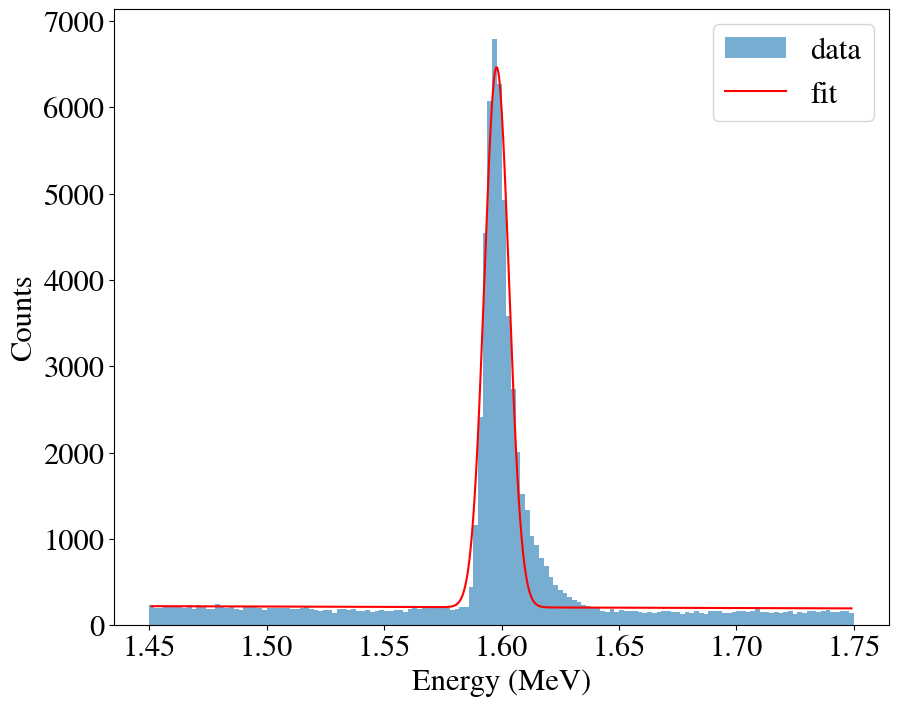

Signal events: 41208.900500452284
Background events: 31082.6387908321
Total Events by addition: 72291.53929128438
Total Events by row counting: 72289
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979, 0.00771598601184177

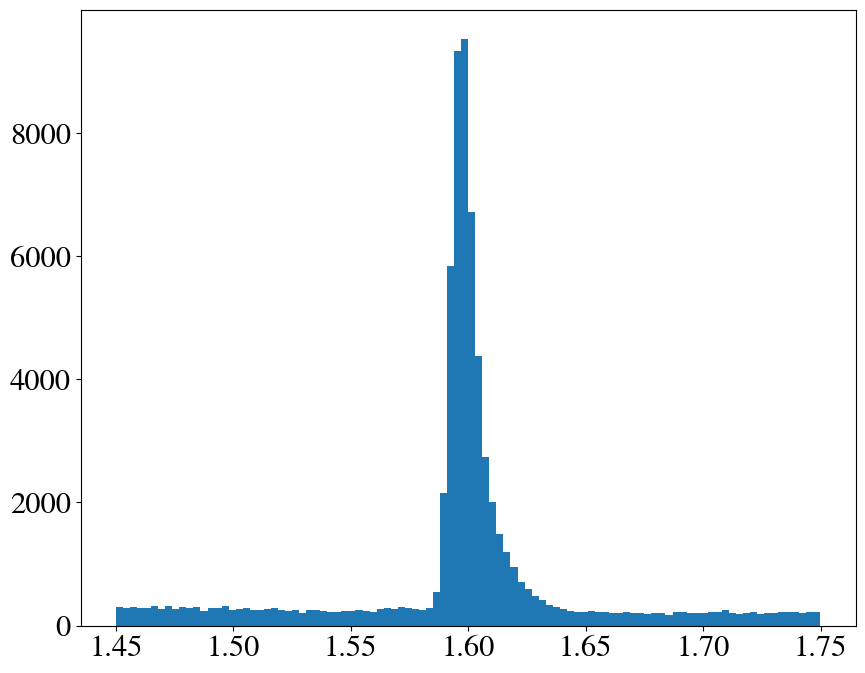

Optimized parameters (popt):
ns: 81.46496493838971
nb: 383.3934759379219
tau: 0.43379405348276256

Covariance matrix (pcov):
ns: [ 1.37715856 -0.56608069  0.01408704]
nb: [-5.66080689e-01  3.14912727e+05  5.13769070e+02]
tau: [1.40870400e-02 5.13769070e+02 8.40827012e-01]


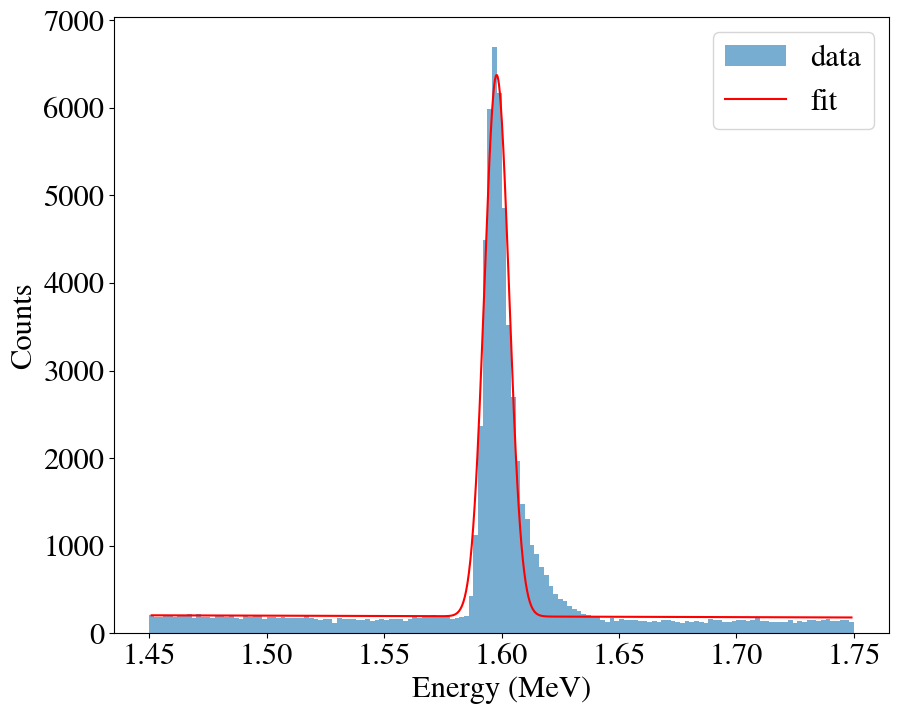

Signal events: 40733.57506043614
Background events: 28748.262626427622
Total Events by addition: 69481.83768686376
Total Events by row counting: 69479
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.007519253034644979,

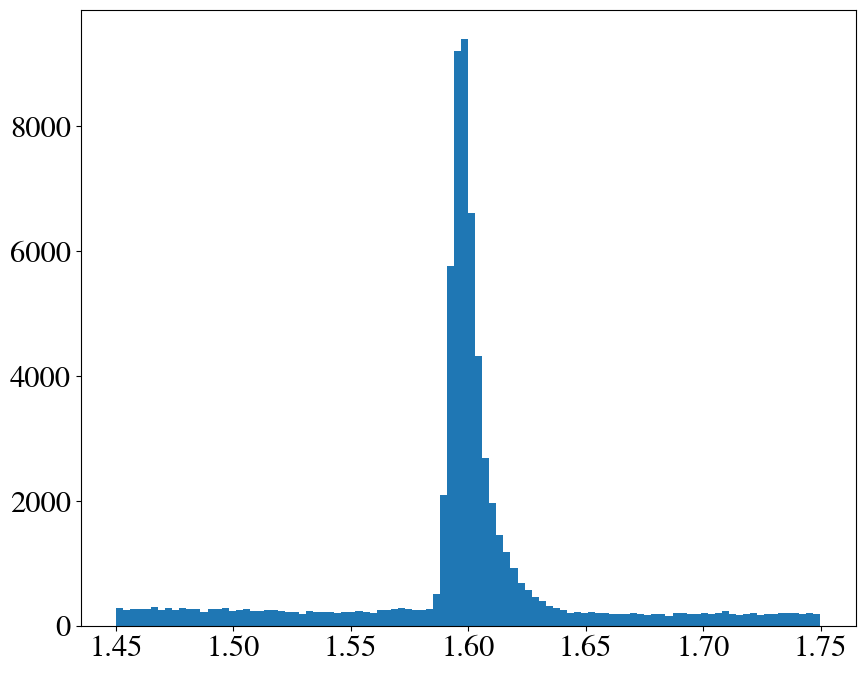

Optimized parameters (popt):
ns: 80.54177272362688
nb: 350.5451928141076
tau: 0.42373594740718507

Covariance matrix (pcov):
ns: [ 1.34984796 -0.83822015  0.01433723]
nb: [-8.38220150e-01  2.98651382e+05  5.33105429e+02]
tau: [1.43372271e-02 5.33105429e+02 9.54602568e-01]


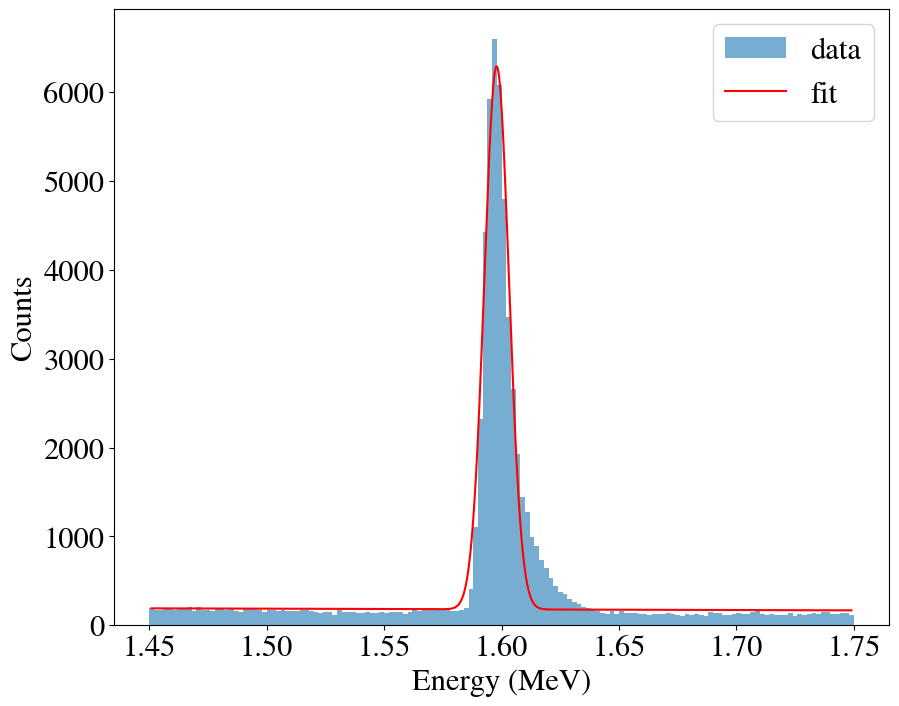

Signal events: 40271.9665713919
Background events: 26710.741358454048
Total Events by addition: 66982.70792984596
Total Events by row counting: 66980
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0.007394185070345705, 0.

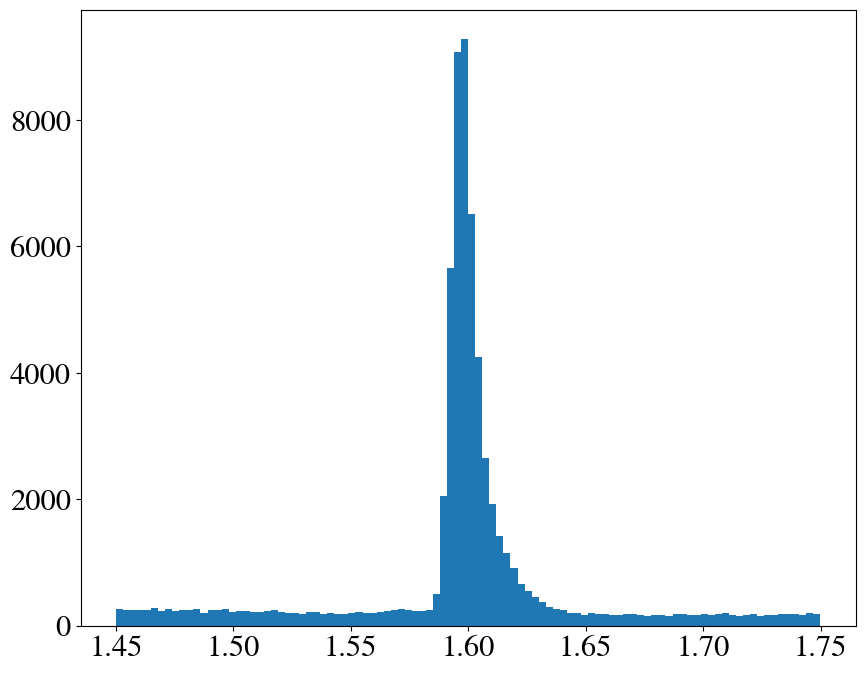

Optimized parameters (popt):
ns: 79.55967997704643
nb: 326.62742310121956
tau: 0.42389771710177665

Covariance matrix (pcov):
ns: [ 1.32193819 -0.82238169  0.01507001]
nb: [-8.22381688e-01  2.92416095e+05  5.60407449e+02]
tau: [1.50700074e-02 5.60407449e+02 1.07737636e+00]


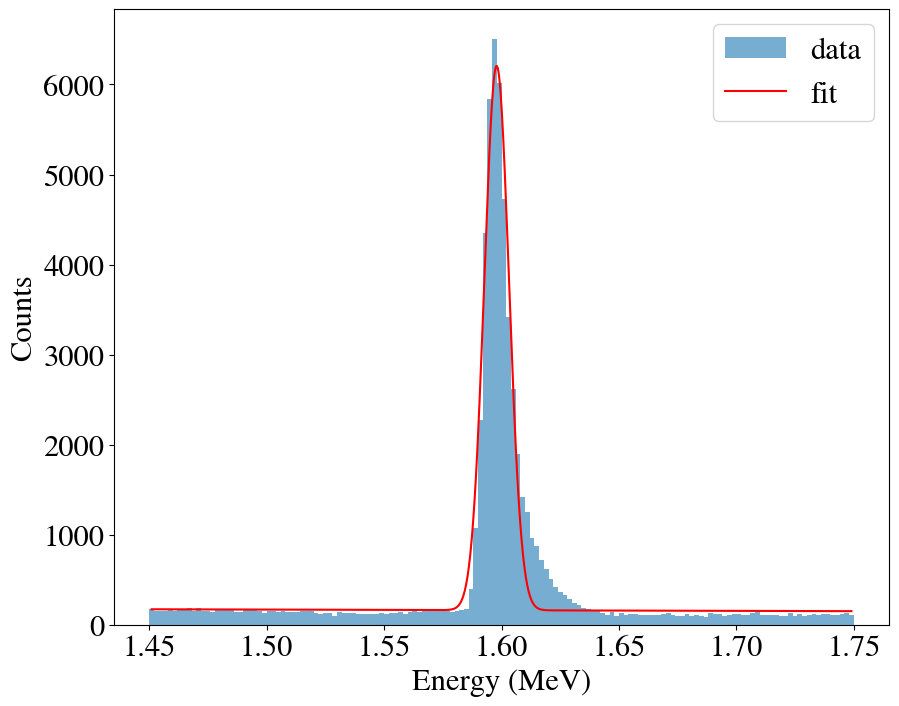

Signal events: 39780.907026477114
Background events: 24881.833811411594
Total Events by addition: 64662.740837888705
Total Events by row counting: 64660
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.007329498146801555, 0

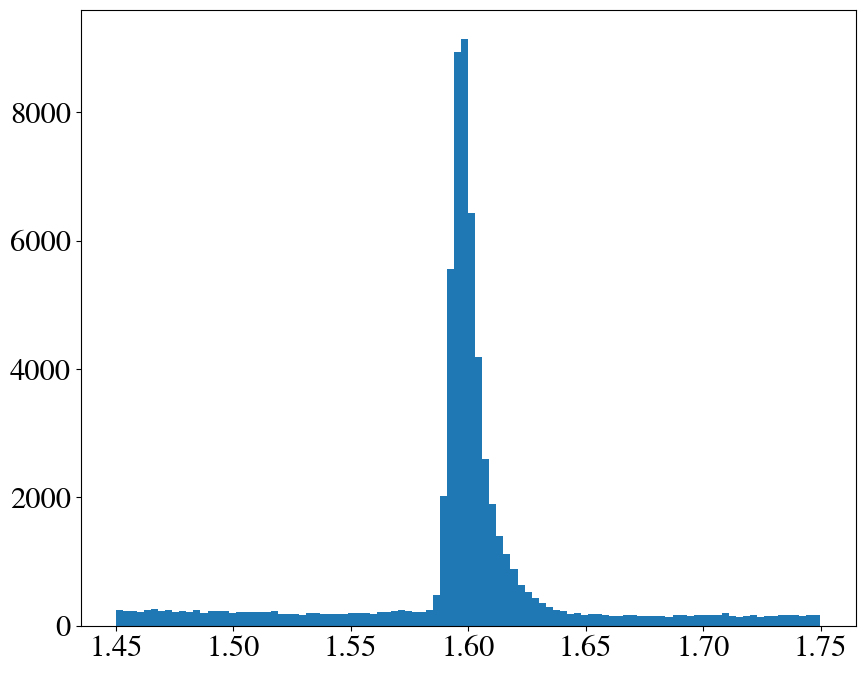

Optimized parameters (popt):
ns: 78.45288785543316
nb: 303.79210250100505
tau: 0.4184040901250719

Covariance matrix (pcov):
ns: [ 1.28480095 -0.94652317  0.01529061]
nb: [-9.46523167e-01  2.78983588e+05  5.75136579e+02]
tau: [1.52906145e-02 5.75136579e+02 1.18938981e+00]


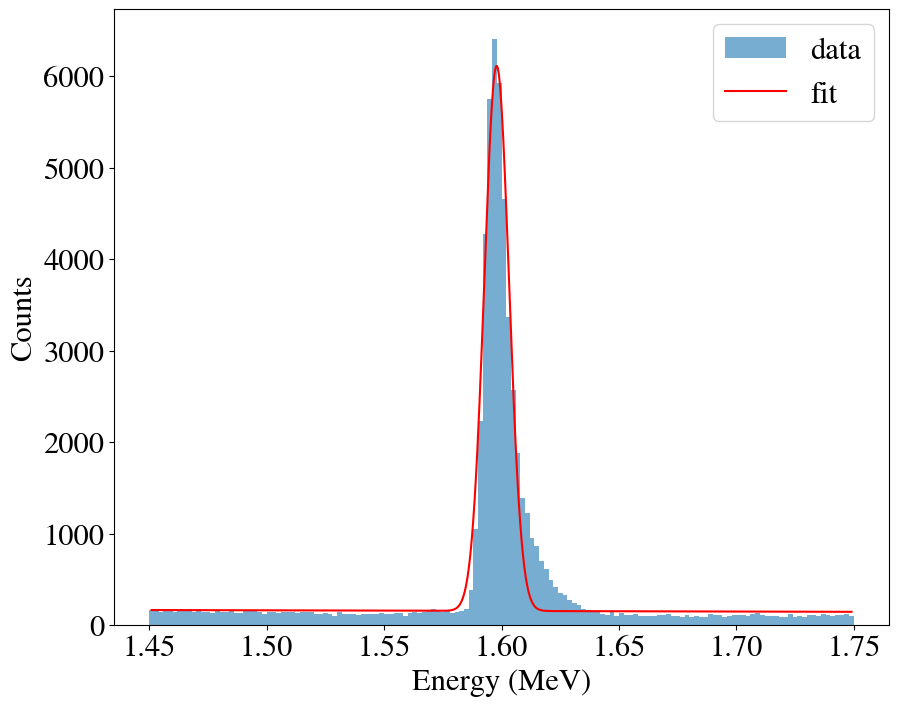

Signal events: 39227.496121603726
Background events: 23346.191679581083
Total Events by addition: 62573.68780118481
Total Events by row counting: 62571
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.00729132137440377, 0.00

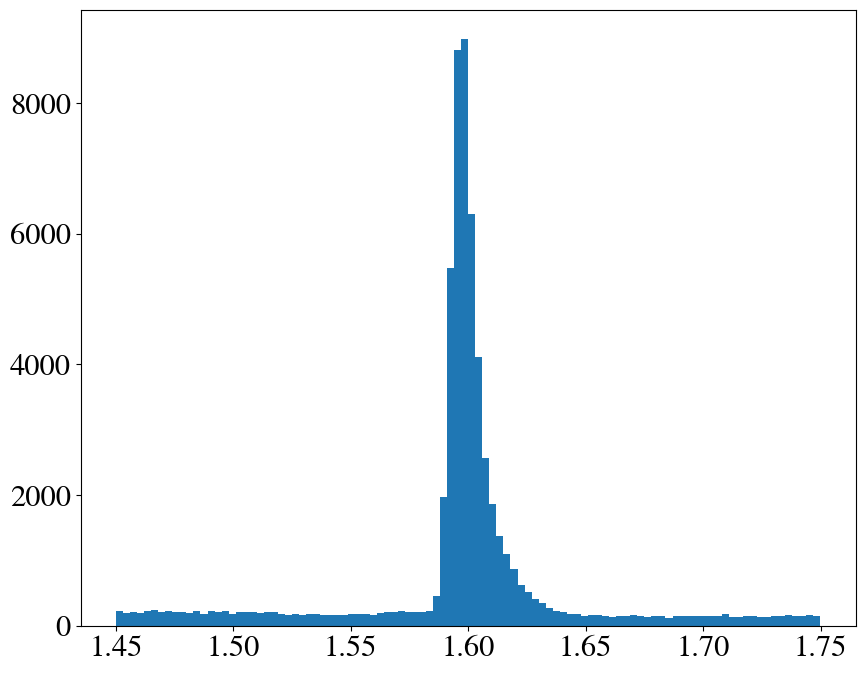

Optimized parameters (popt):
ns: 77.27938466511709
nb: 275.90106911555864
tau: 0.3998703283697855

Covariance matrix (pcov):
ns: [ 1.2671797  -1.39058226  0.01501652]
nb: [-1.39058226e+00  2.58957569e+05  5.88235693e+02]
tau: [1.50165192e-02 5.88235693e+02 1.34040158e+00]


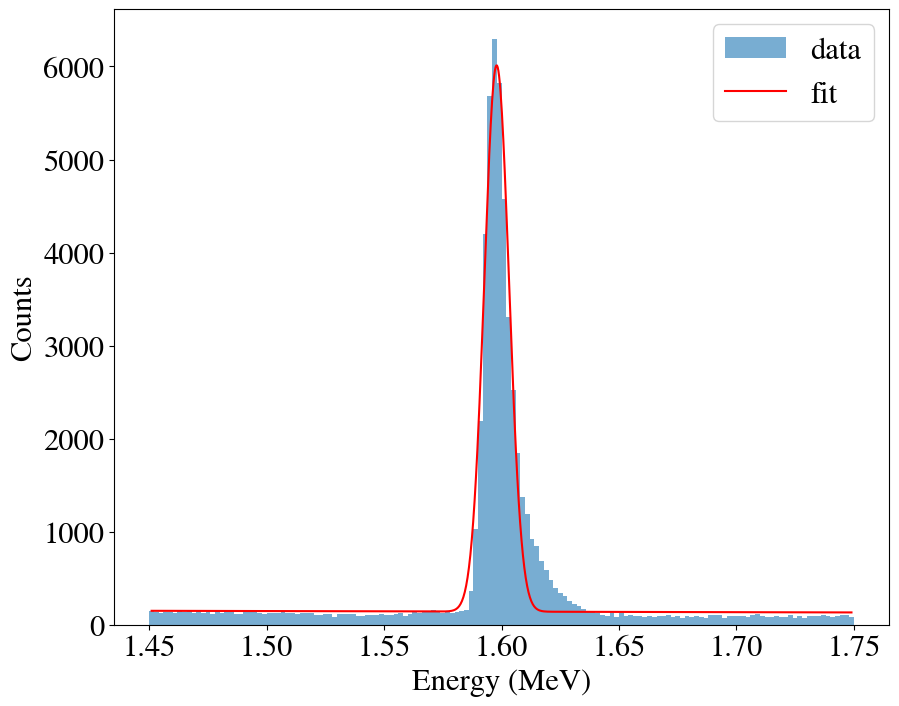

Signal events: 38640.72878766389
Background events: 21839.707995760324
Total Events by addition: 60480.436783424215
Total Events by row counting: 60478
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.007276178732202846, 0.007

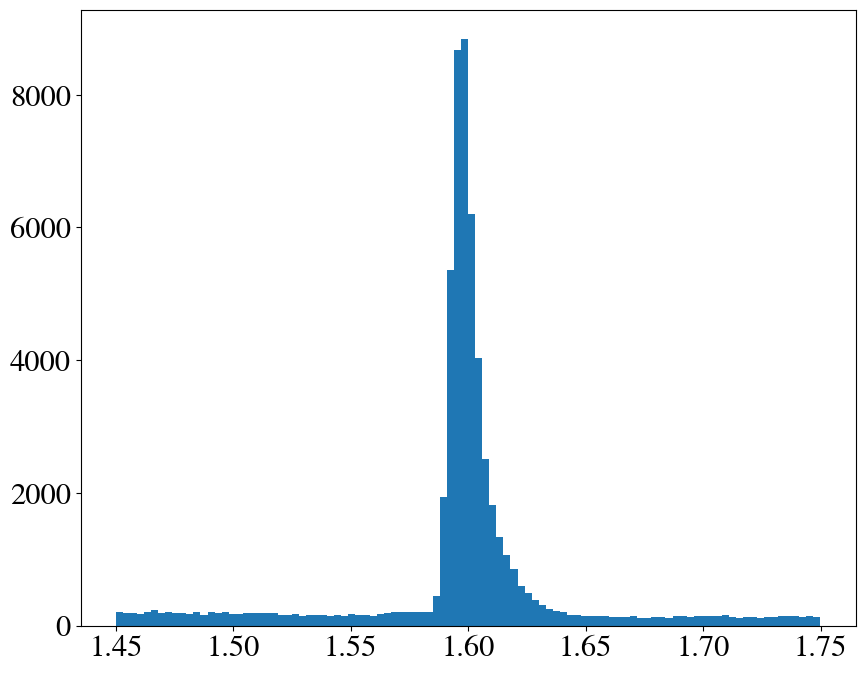

Optimized parameters (popt):
ns: 76.16407175008231
nb: 253.95236958225217
tau: 0.3887876587629874

Covariance matrix (pcov):
ns: [ 1.22900663 -1.56129314  0.01496819]
nb: [-1.56129314e+00  2.43602716e+05  5.99642491e+02]
tau: [1.49681861e-02 5.99642491e+02 1.48068750e+00]


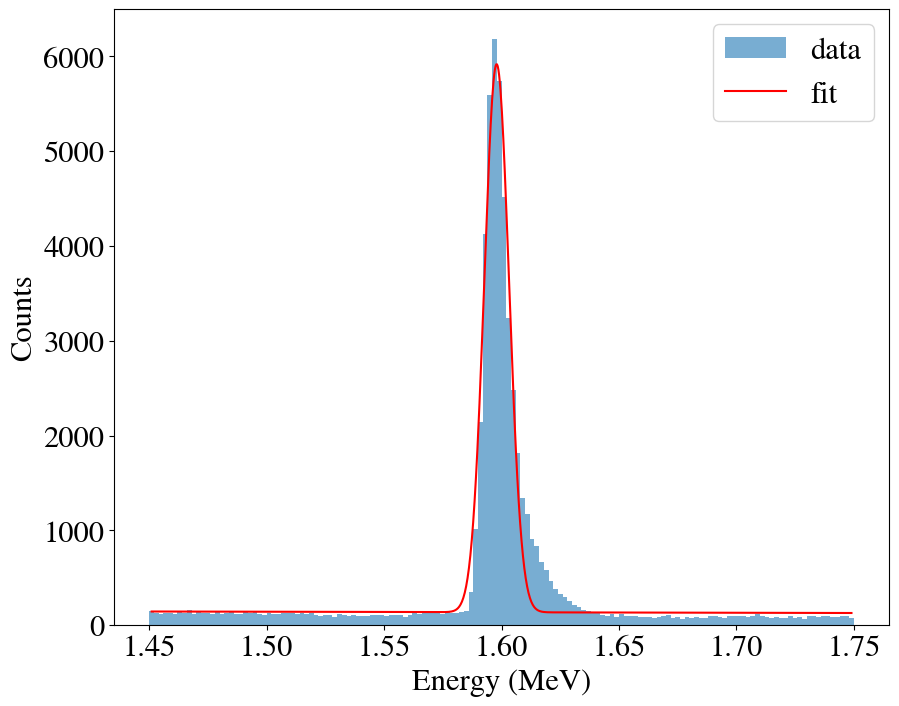

Signal events: 38083.05737180062
Background events: 20461.266191304978
Total Events by addition: 58544.3235631056
Total Events by row counting: 58542
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.007269408022760041, 0.00727617

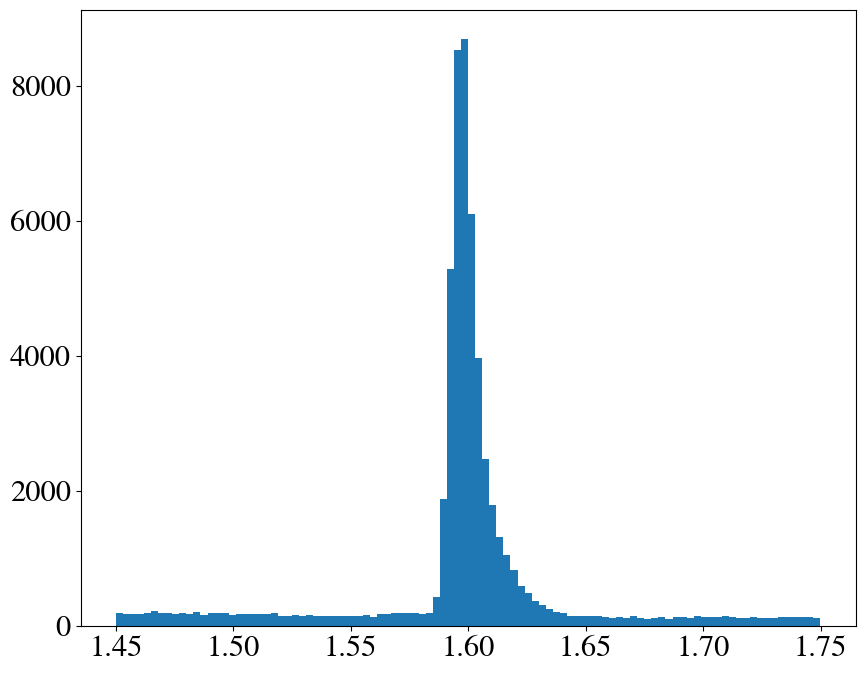

Optimized parameters (popt):
ns: 74.98968491548509
nb: 221.75858986616504
tau: 0.34590786682324204

Covariance matrix (pcov):
ns: [ 1.19885804 -2.36969853  0.0129361 ]
nb: [-2.36969853e+00  2.07386242e+05  5.84252546e+02]
tau: [1.29360956e-02 5.84252546e+02 1.65113166e+00]


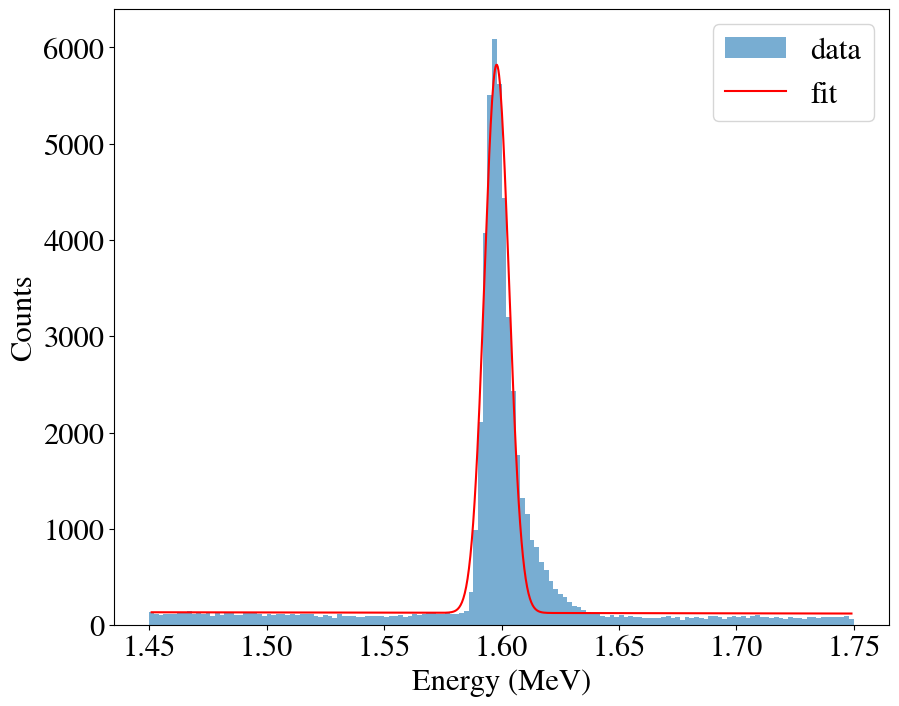

Signal events: 37495.848203868954
Background events: 19133.979520522316
Total Events by addition: 56629.827724391274
Total Events by row counting: 56628
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287330922, 0.0072694

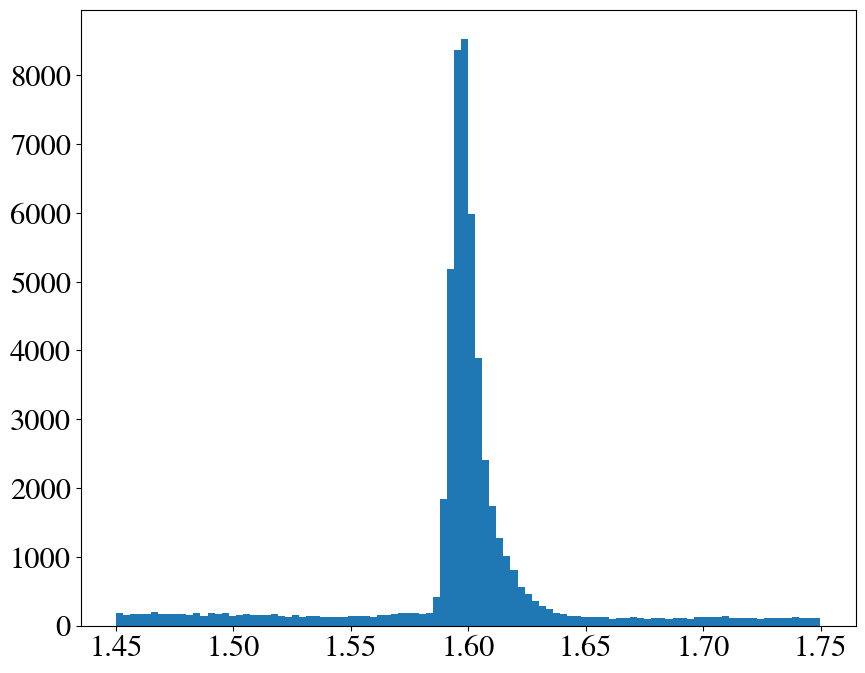

Optimized parameters (popt):
ns: 73.68303402476425
nb: 207.52000890070298
tau: 0.3437846519644154

Covariance matrix (pcov):
ns: [ 1.15230337 -2.31360244  0.01311121]
nb: [-2.31360244e+00  1.98051789e+05  5.96134813e+02]
tau: [1.31112103e-02 5.96134813e+02 1.79999212e+00]


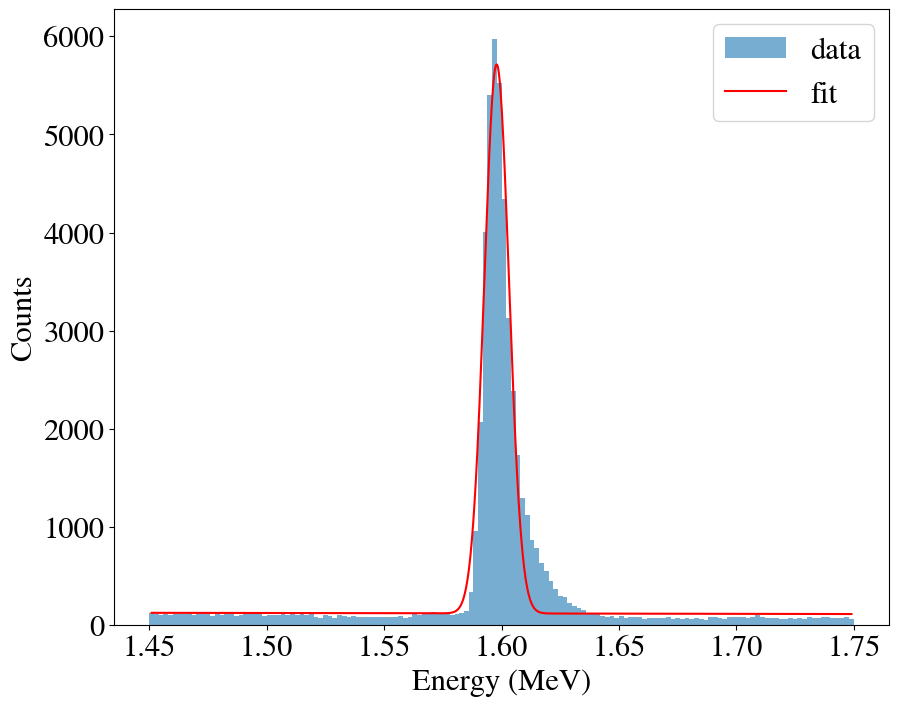

Signal events: 36842.50523397736
Background events: 17966.265213223705
Total Events by addition: 54808.77044720107
Total Events by row counting: 54807
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764638, 0.007263129287

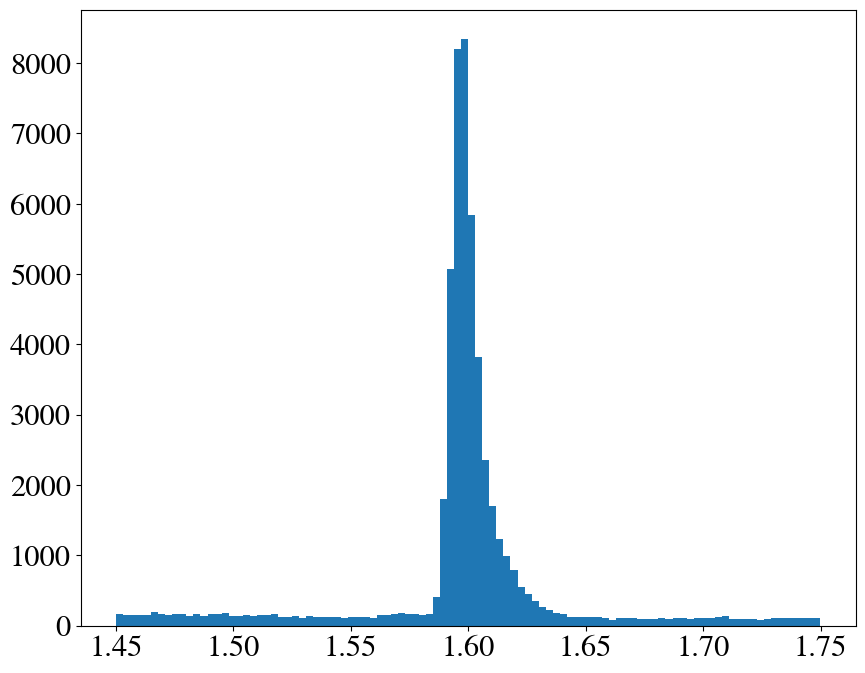

Optimized parameters (popt):
ns: 72.17626260912833
nb: 194.89873370150573
tau: 0.34444907811251063

Covariance matrix (pcov):
ns: [ 1.10355924 -2.20311358  0.01343311]
nb: [-2.20311358e+00  1.90129435e+05  6.09268068e+02]
tau: [1.34331077e-02 6.09268068e+02 1.95851944e+00]


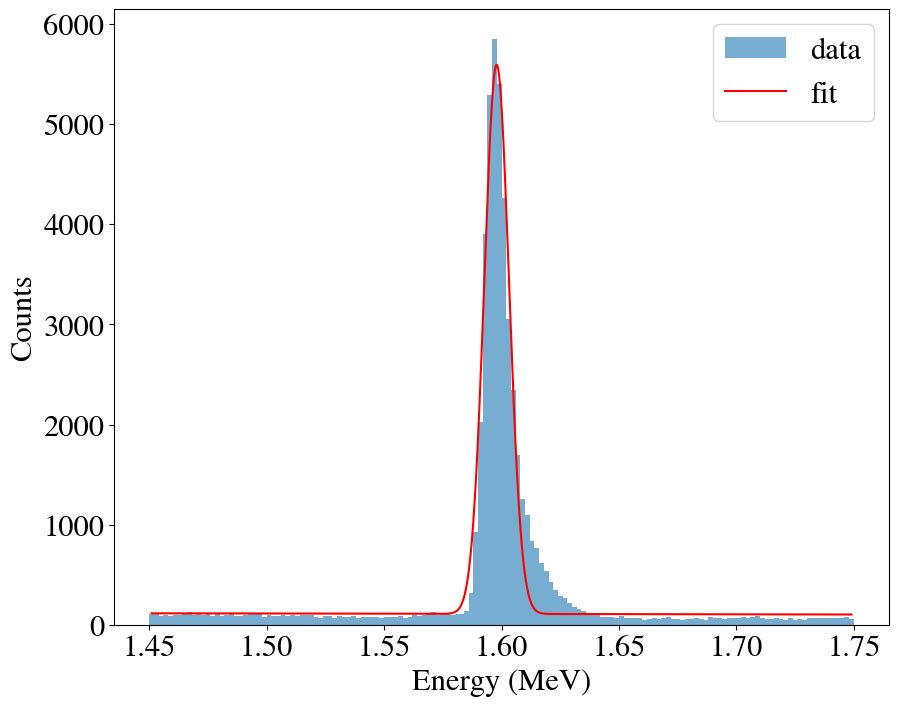

Signal events: 36089.09931765317
Background events: 16855.66536604224
Total Events by addition: 52944.76468369541
Total Events by row counting: 52943
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499641, 0.007261264858764

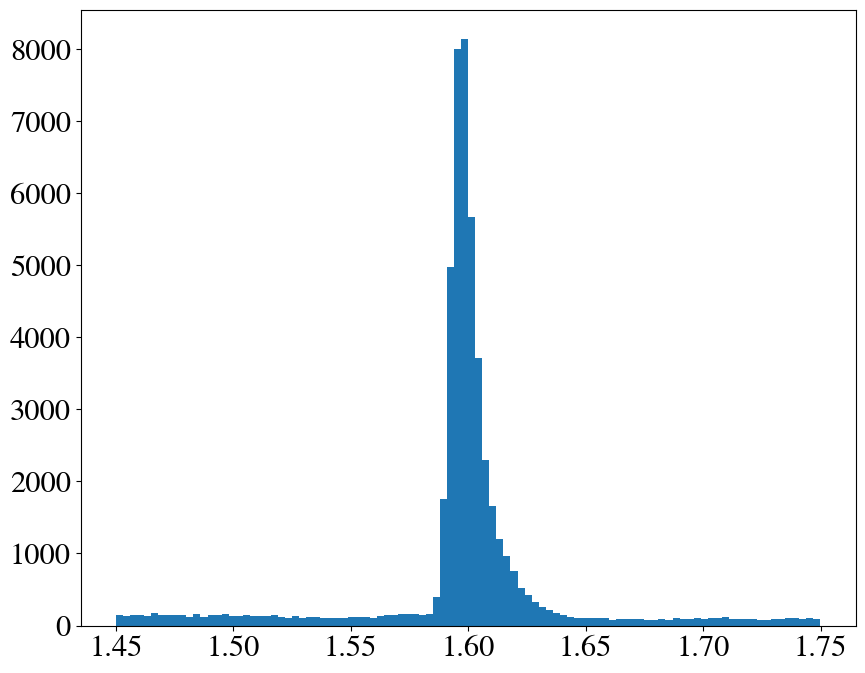

Optimized parameters (popt):
ns: 70.49114956663418
nb: 174.87957548117265
tau: 0.3161038216750308

Covariance matrix (pcov):
ns: [ 1.0595362  -2.54951367  0.01184723]
nb: [-2.54951367e+00  1.66835755e+05  5.95590790e+02]
tau: [1.18472281e-02 5.95590790e+02 2.13288264e+00]


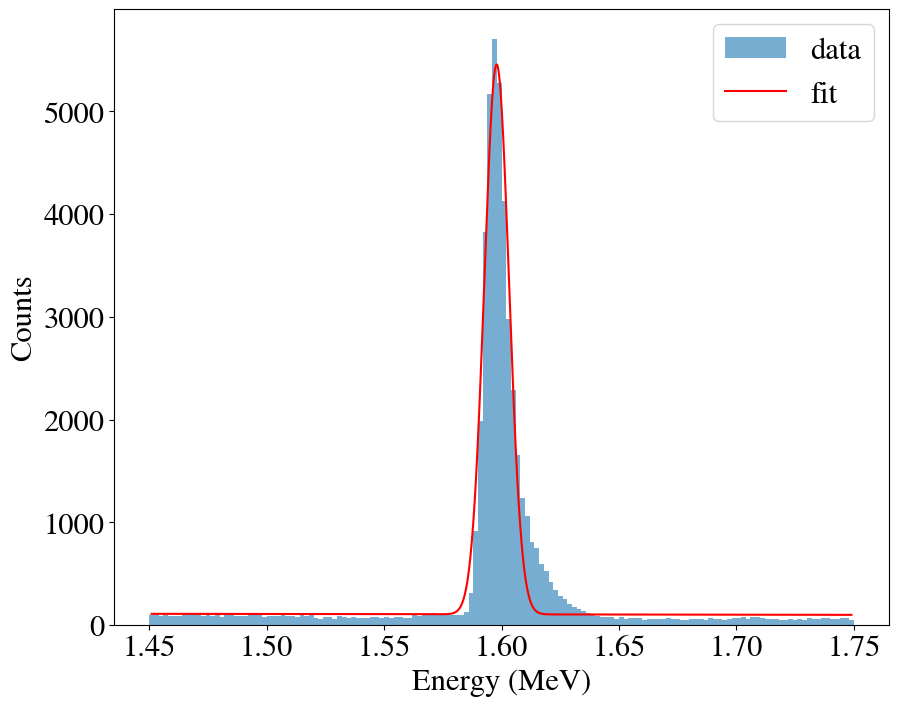

Signal events: 35246.520196018886
Background events: 15824.929188887176
Total Events by addition: 51071.44938490606
Total Events by row counting: 51070
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272, 0.007261310584499

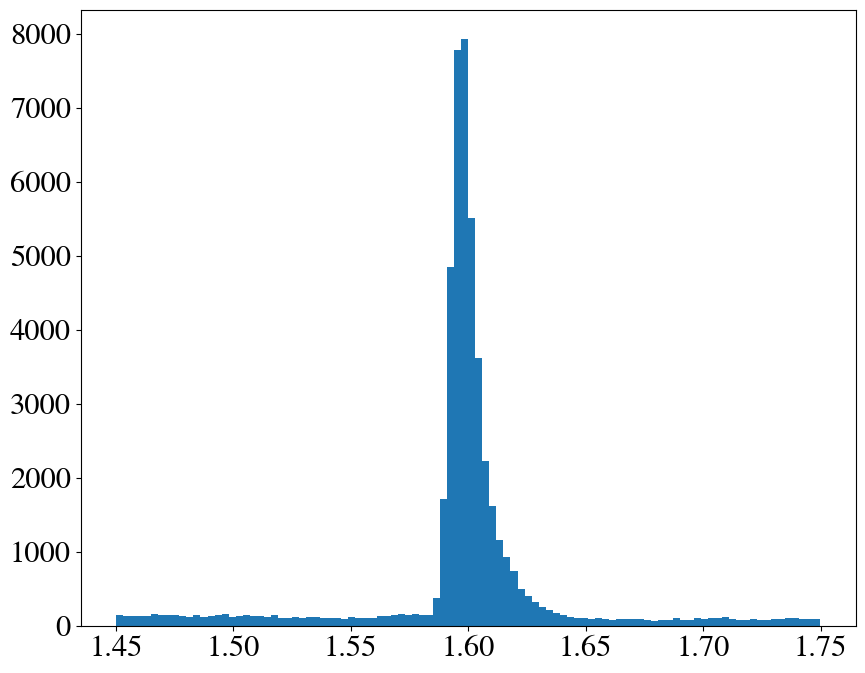

Optimized parameters (popt):
ns: 68.623892637826
nb: 153.27997514383802
tau: 0.2728361287318056

Covariance matrix (pcov):
ns: [ 1.00564033 -2.97404589  0.00904711]
nb: [-2.97404589e+00  1.37958155e+05  5.61705115e+02]
tau: [9.04710935e-03 5.61705115e+02 2.29418811e+00]


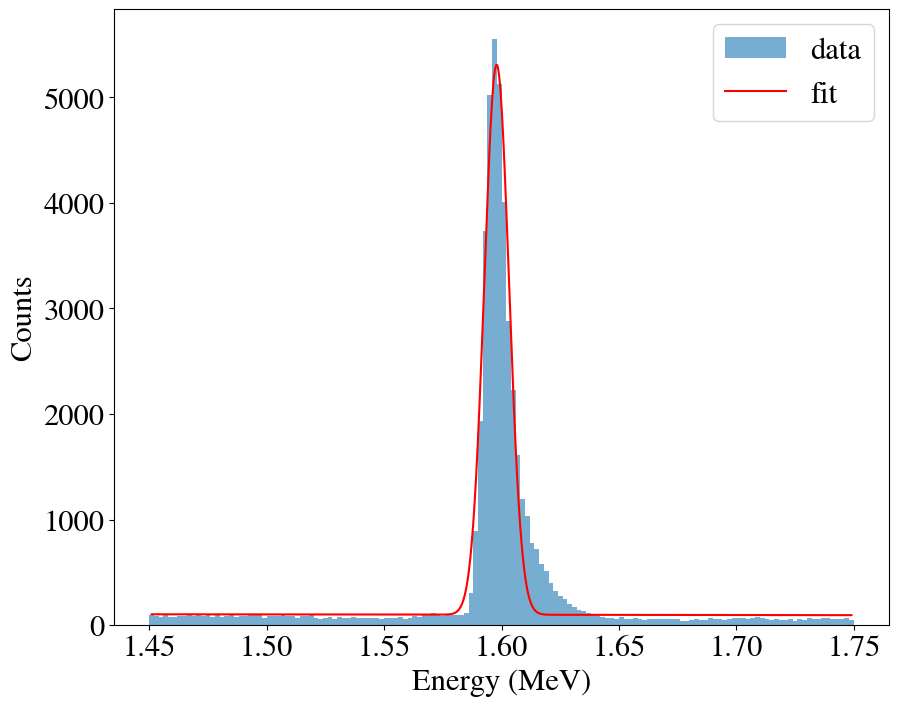

Signal events: 34312.86668835152
Background events: 14863.191252619987
Total Events by addition: 49176.05794097151
Total Events by row counting: 49175
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845, 0.007262013682190272,

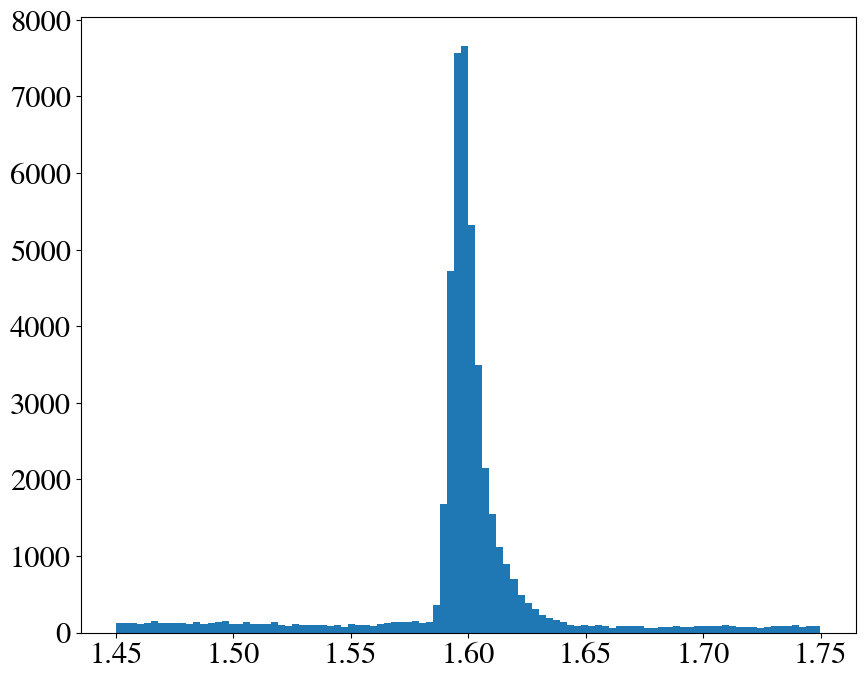

Optimized parameters (popt):
ns: 66.54913497237081
nb: 143.90127528769503
tau: 0.2716802166215164

Covariance matrix (pcov):
ns: [ 0.94944292 -2.82025381  0.00900614]
nb: [-2.82025381e+00  1.29795761e+05  5.62853981e+02]
tau: [9.00614325e-03 5.62853981e+02 2.44844643e+00]


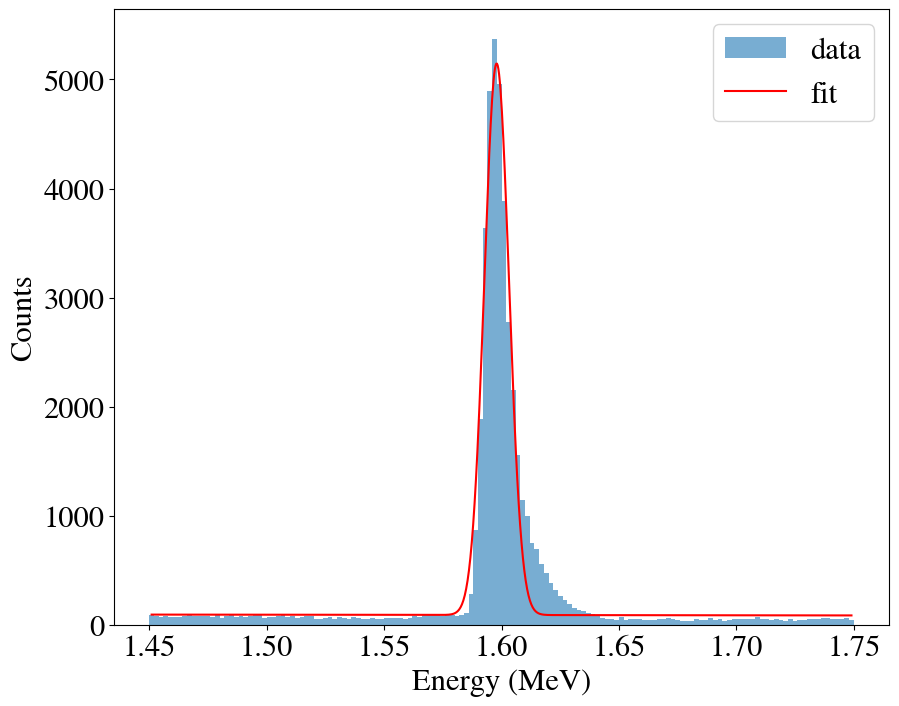

Signal events: 33275.460029403715
Background events: 13979.559026315188
Total Events by addition: 47255.019055718905
Total Events by row counting: 47254
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.007263198483424845,

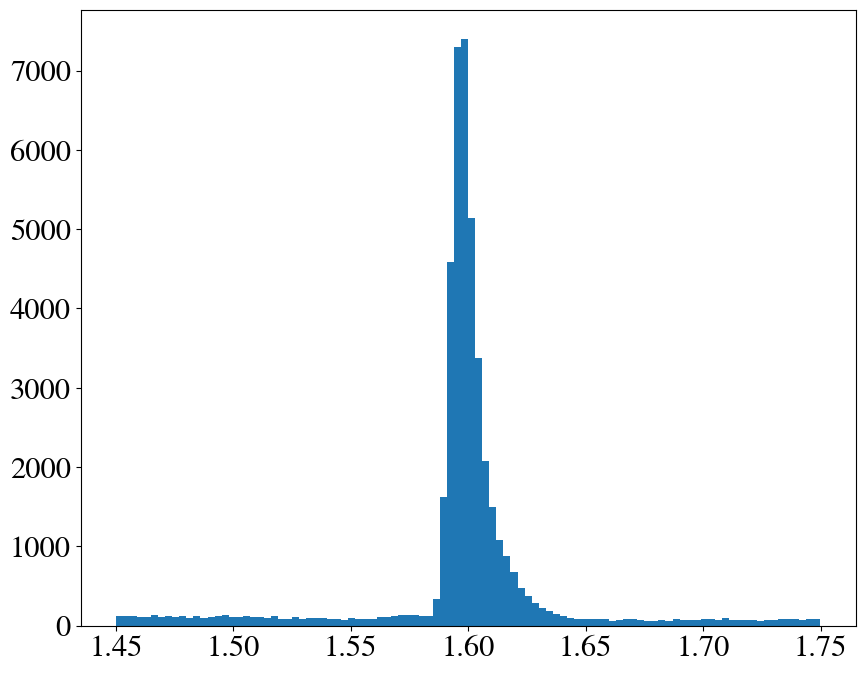

Optimized parameters (popt):
ns: 64.33652718995407
nb: 125.15749163938709
tau: 0.22671768663618597

Covariance matrix (pcov):
ns: [ 0.89232861 -3.10243413  0.0058153 ]
nb: [-3.10243413e+00  1.04857322e+05  5.24769253e+02]
tau: [5.81529959e-03 5.24769253e+02 2.63449246e+00]


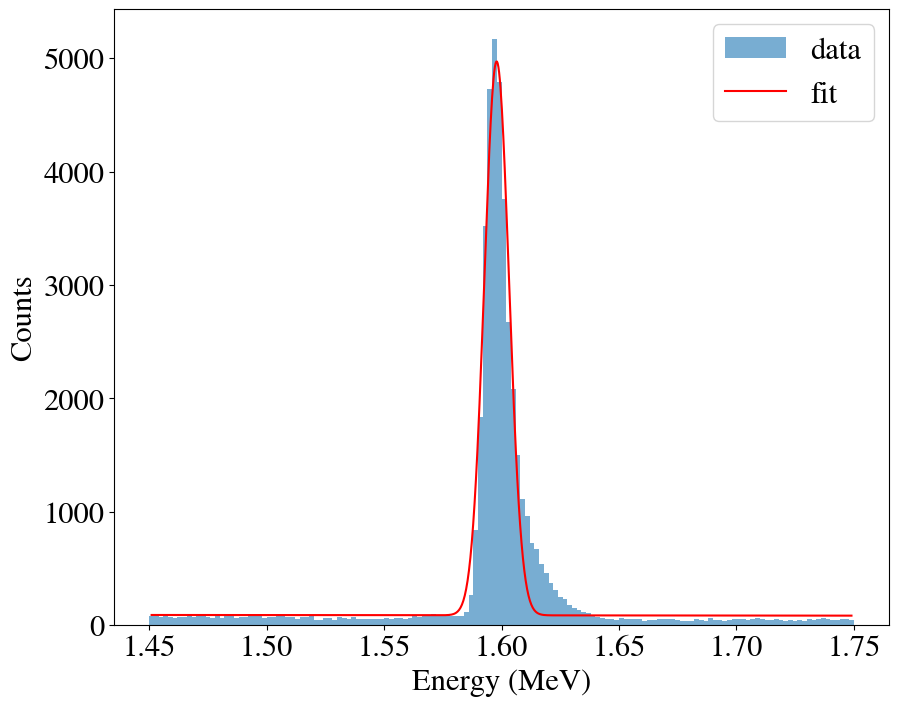

Signal events: 32169.12646315792
Background events: 13064.48620308117
Total Events by addition: 45233.61266623909
Total Events by row counting: 45233
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.007263173435209791, 0.00

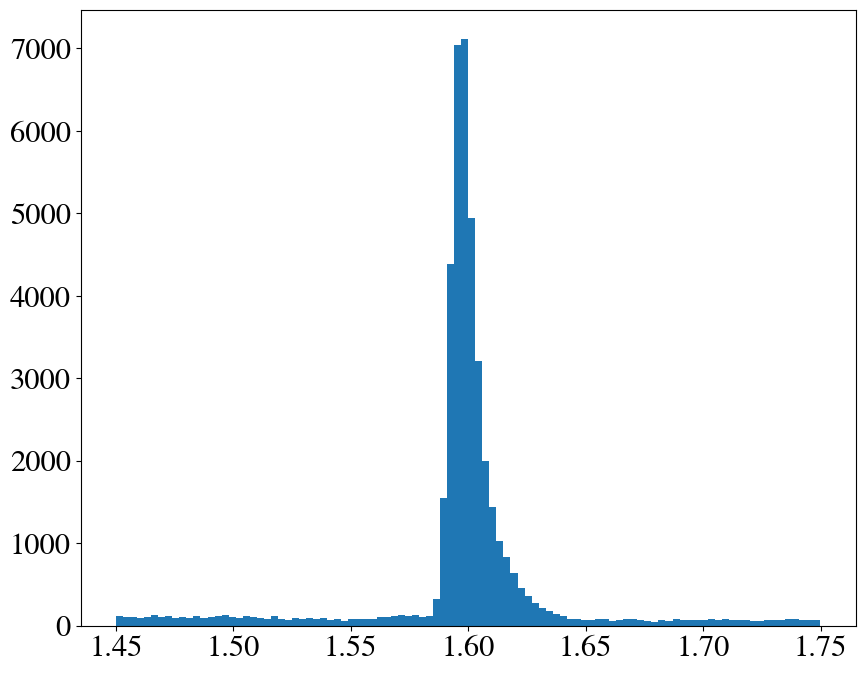

Optimized parameters (popt):
ns: 61.88875861905126
nb: 108.74751139997262
tau: 0.18650203316791986

Covariance matrix (pcov):
ns: [ 8.28089677e-01 -3.17027375e+00  3.13109844e-03]
nb: [-3.17027375e+00  8.58458246e+04  4.93585268e+02]
tau: [3.13109844e-03 4.93585268e+02 2.84684292e+00]


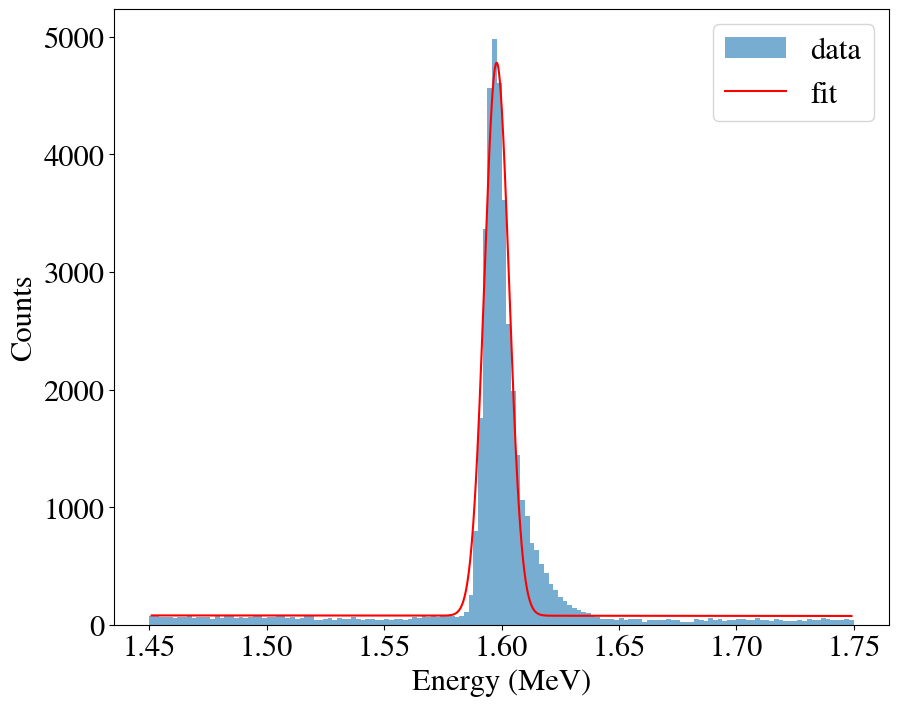

Signal events: 30945.20934874129
Background events: 12105.212844559399
Total Events by addition: 43050.42219330069
Total Events by row counting: 43050
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.007262942530493741, 0.0072

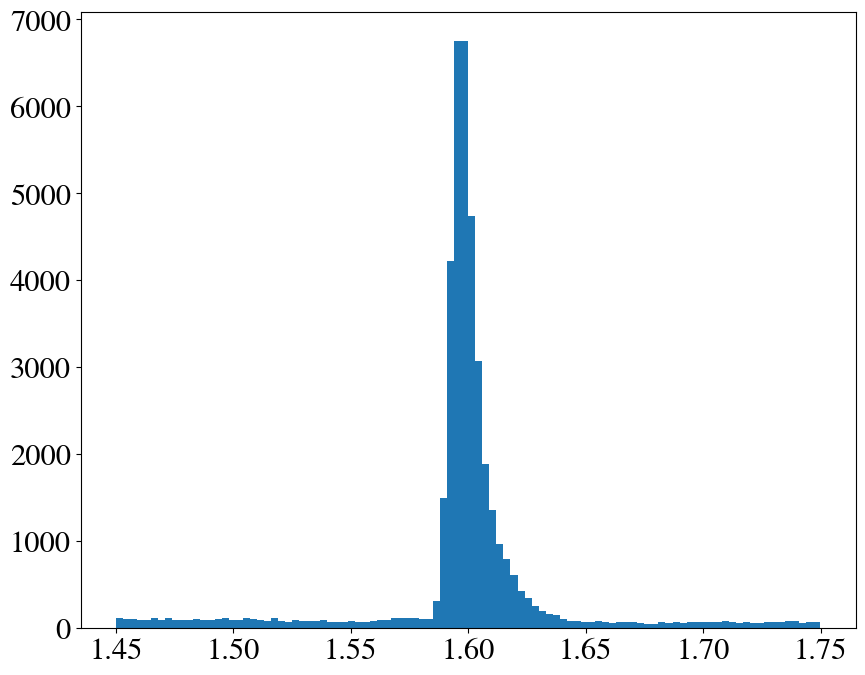

Optimized parameters (popt):
ns: 59.189970869510056
nb: 99.29025139332629
tau: 0.18097309186897828

Covariance matrix (pcov):
ns: [ 7.44437226e-01 -2.88248961e+00  2.69695828e-03]
nb: [-2.88248961e+00  7.58669229e+04  4.77606756e+02]
tau: [2.69695828e-03 4.77606756e+02 3.01610641e+00]


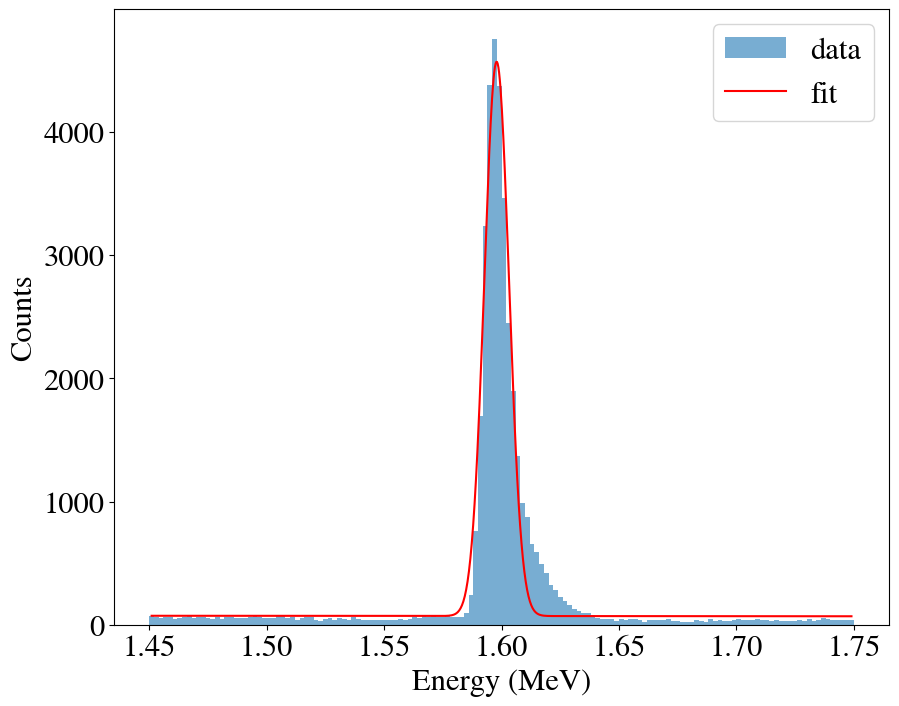

Signal events: 29595.779278388207
Background events: 11150.601718732158
Total Events by addition: 40746.38099712037
Total Events by row counting: 40746
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.007262712642893857, 0.00726

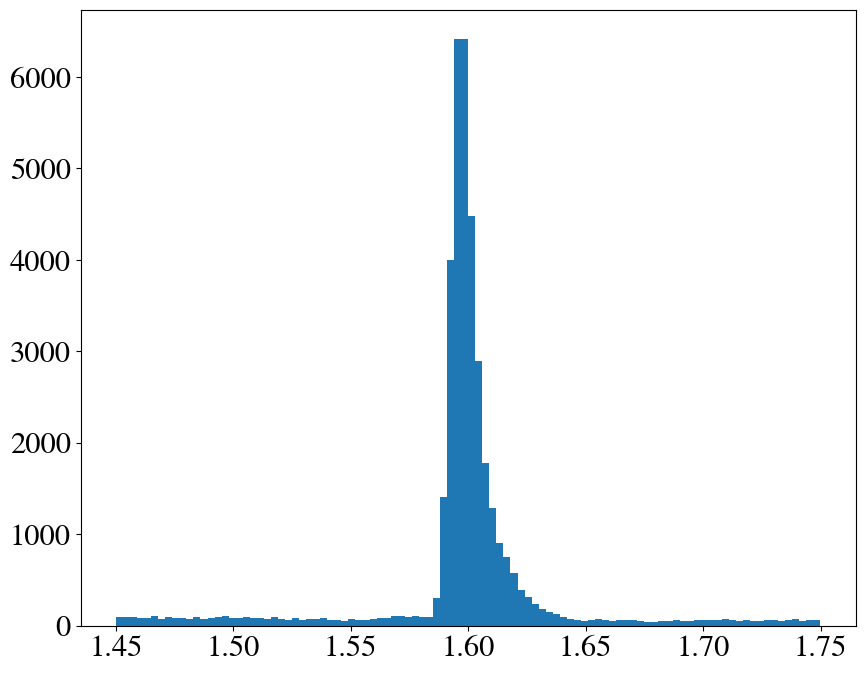

Optimized parameters (popt):
ns: 56.148242112053495
nb: 88.66065986182649
tau: 0.16218819372537796

Covariance matrix (pcov):
ns: [ 6.71384195e-01 -2.69439714e+00  1.44324271e-03]
nb: [-2.69439714e+00  6.45450742e+04  4.54633108e+02]
tau: [1.44324271e-03 4.54633108e+02 3.21230580e+00]


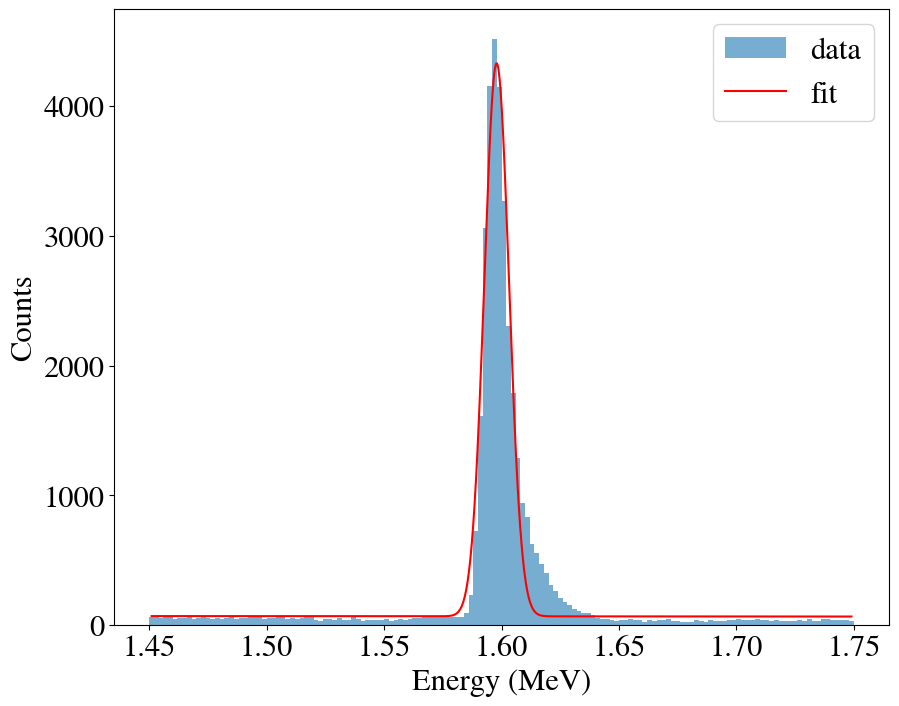

Signal events: 28074.87410462367
Background events: 10260.422180284166
Total Events by addition: 38335.29628490783
Total Events by row counting: 38335
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287]
fom_err: [0.007262509868846443, 0.007262509868846443, 0.00726271

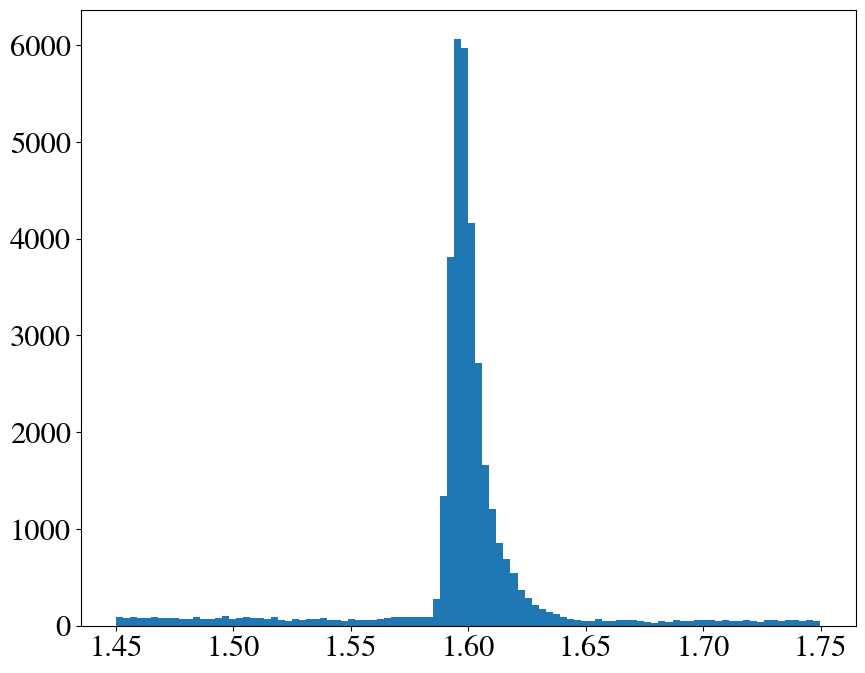

Optimized parameters (popt):
ns: 52.734443508827674
nb: 73.63922905378922
tau: 0.0997255526144446

Covariance matrix (pcov):
ns: [ 6.05985479e-01 -2.66741649e+00 -2.49098786e-03]
nb: [-2.66741649e+00  4.79996143e+04  4.05796955e+02]
tau: [-2.49098786e-03  4.05796955e+02  3.44141005e+00]


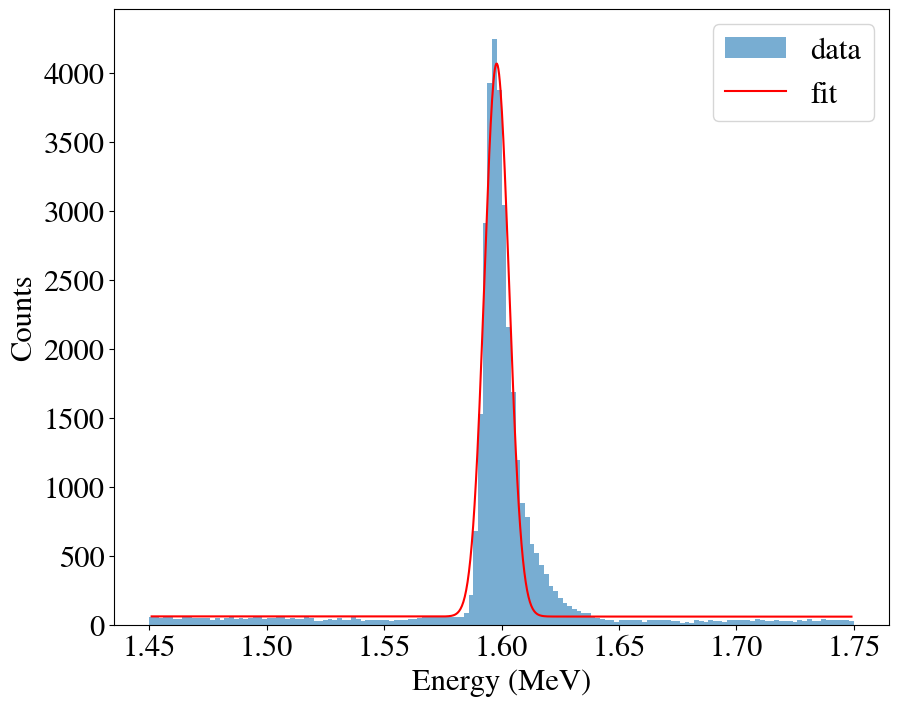

Signal events: 26367.92901785077
Background events: 9417.168098903507
Total Events by addition: 35785.097116754274
Total Events by row counting: 35785
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333]
fom_err: [0.007262509868846443, 0.0072625098

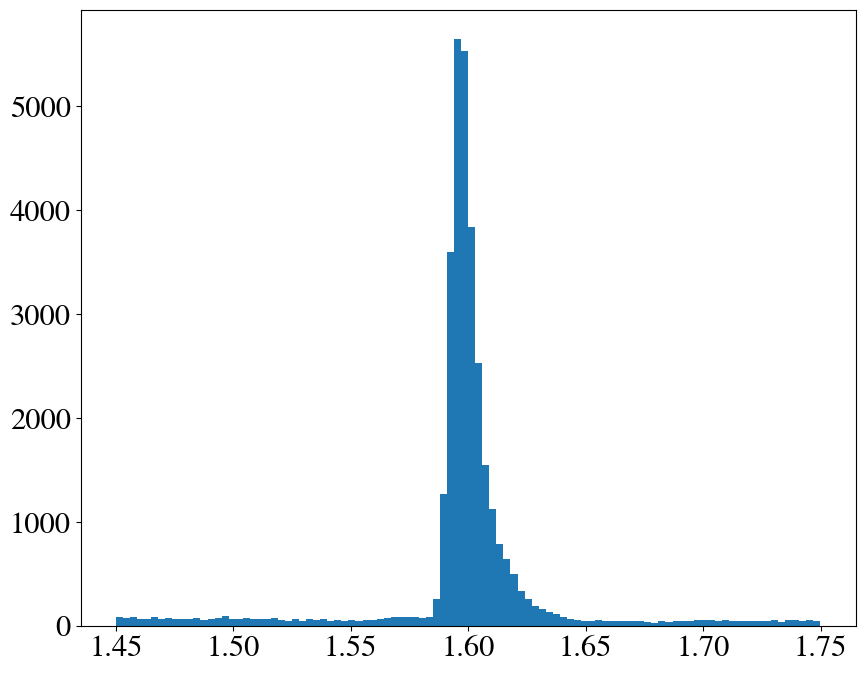

Optimized parameters (popt):
ns: 49.06229822997549
nb: 61.179485997730076
tau: 0.04567905940417226

Covariance matrix (pcov):
ns: [ 0.5369055  -2.50108778 -0.00584072]
nb: [-2.50108778e+00  3.58040055e+04  3.64181876e+02]
tau: [-5.84071754e-03  3.64181876e+02  3.71586856e+00]


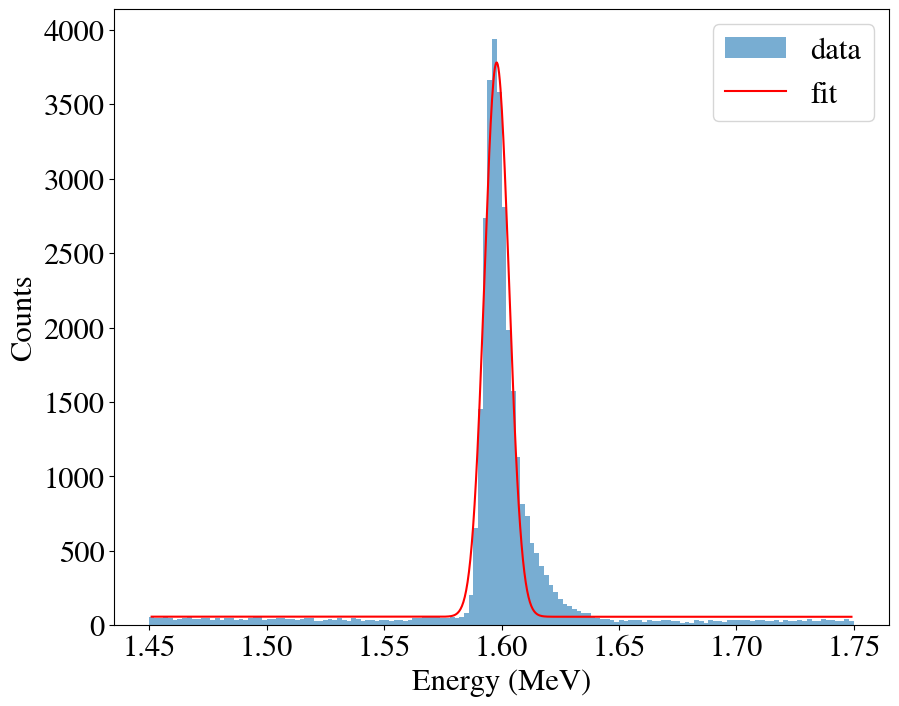

Signal events: 24531.80712837257
Background events: 8530.20445684003
Total Events by addition: 33062.011585212604
Total Events by row counting: 33062
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037]
fom_err: [0.0072625098688

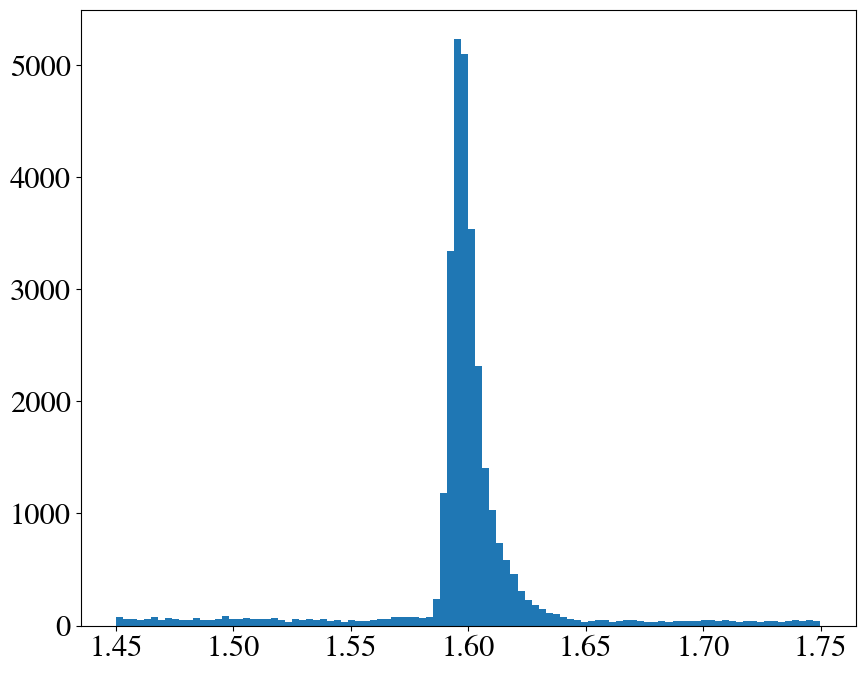

Optimized parameters (popt):
ns: 45.32740565801747
nb: 49.788067537487365
tau: -0.016800391264699684

Covariance matrix (pcov):
ns: [ 0.45462825 -2.21137737 -0.00922296]
nb: [-2.21137737e+00  2.48042774e+04  3.10139366e+02]
tau: [-9.22295857e-03  3.10139366e+02  3.88992111e+00]


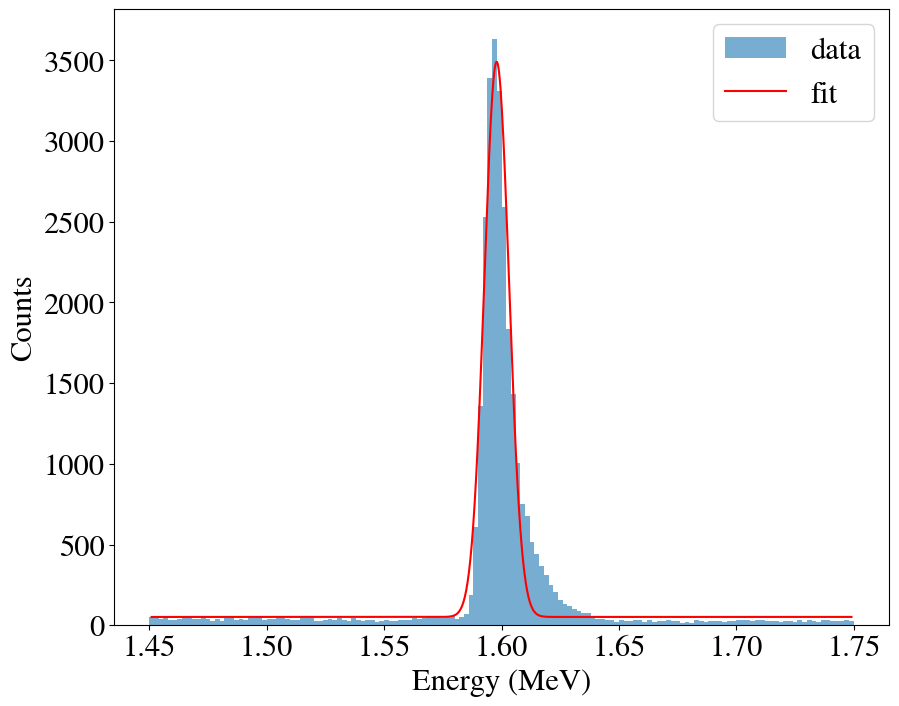

Signal events: 22664.310750787736
Background events: 7671.690760334279
Total Events by addition: 30336.001511122013
Total Events by row counting: 30336
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937]
fom

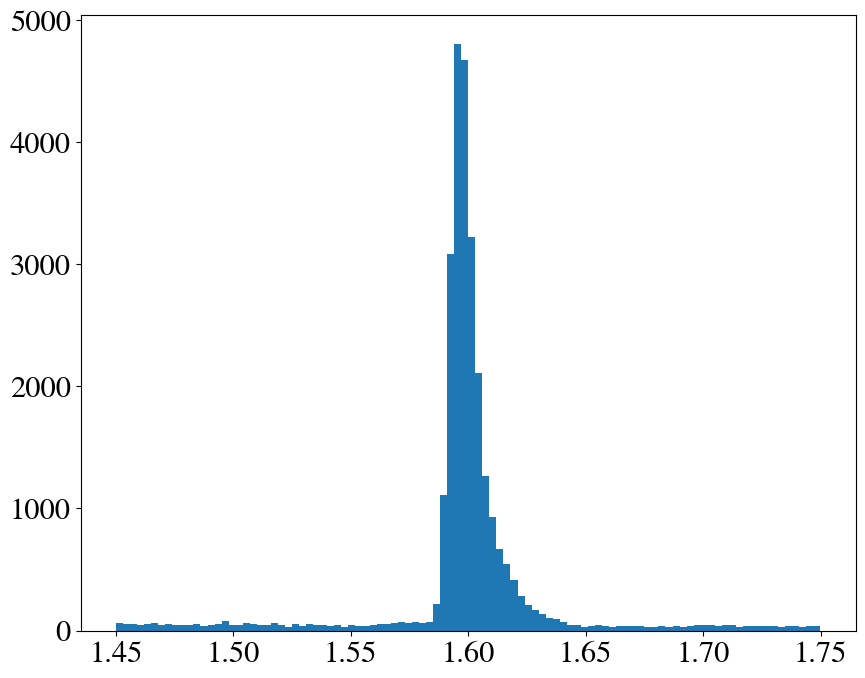

Optimized parameters (popt):
ns: 41.55887061575478
nb: 41.36548108607373
tau: -0.0659984550046619

Covariance matrix (pcov):
ns: [ 0.38284342 -1.90160557 -0.01126779]
nb: [-1.90160557e+00  1.79799663e+04  2.69587446e+02]
tau: [-1.12677852e-02  2.69587446e+02  4.05473619e+00]


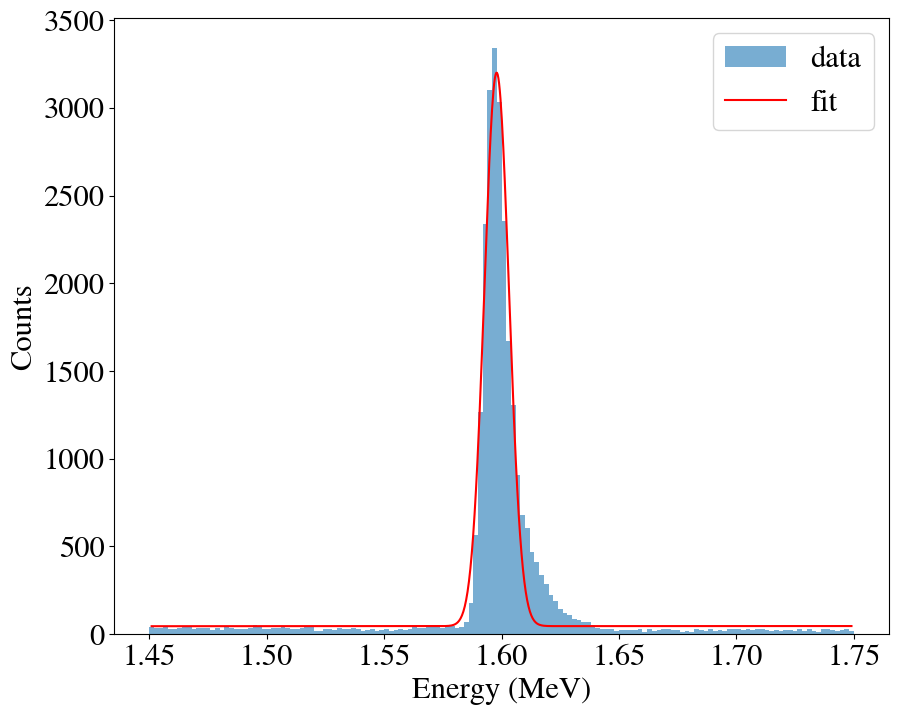

Signal events: 20779.992686844736
Background events: 6895.993209654715
Total Events by addition: 27675.985896499453
Total Events by row counting: 27676
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.5

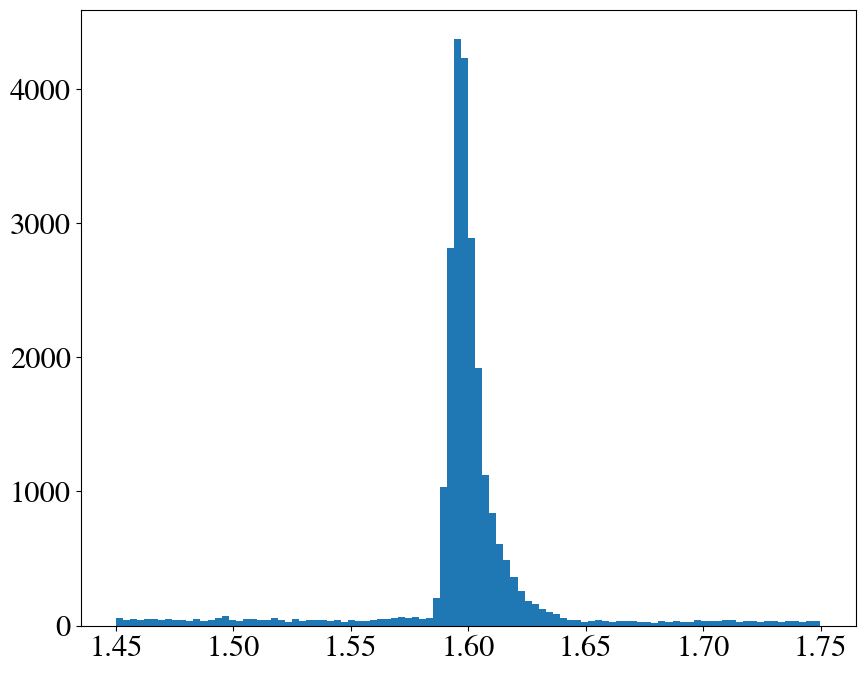

Optimized parameters (popt):
ns: 37.70939712308758
nb: 34.74044633057094
tau: -0.09901745378681134

Covariance matrix (pcov):
ns: [ 0.31948733 -1.60203083 -0.01252909]
nb: [-1.60203083e+00  1.33447375e+04  2.39623644e+02]
tau: [-1.25290856e-02  2.39623644e+02  4.31618695e+00]


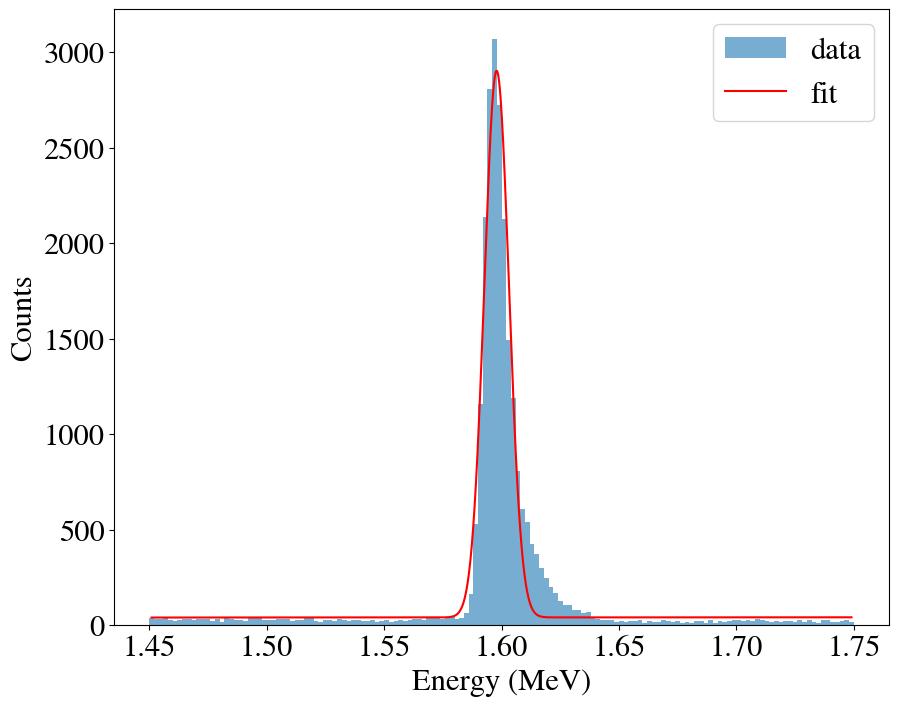

Signal events: 18855.204312169742
Background events: 6105.861480226559
Total Events by addition: 24961.0657923963
Total Events by row counting: 24961
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.511

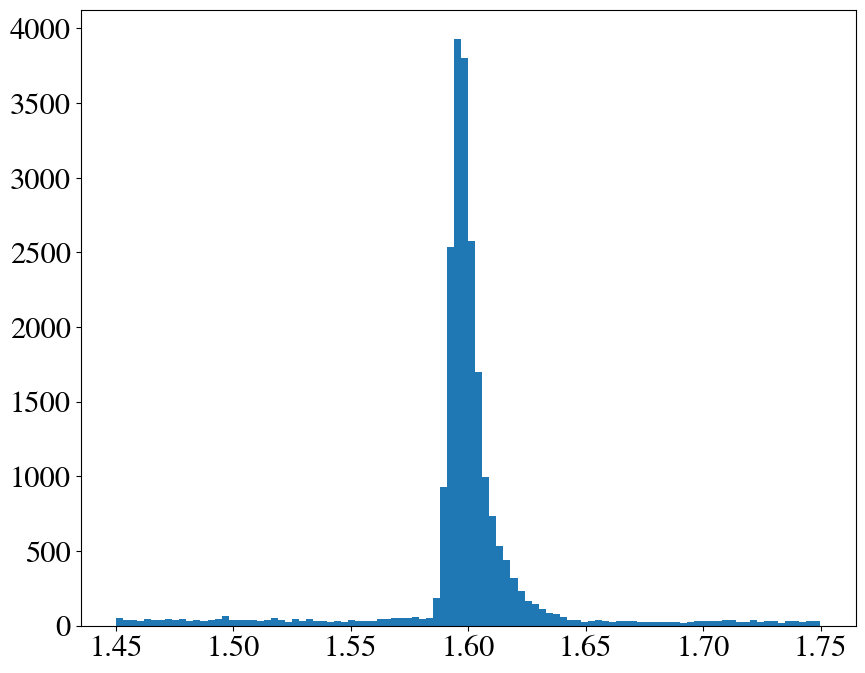

Optimized parameters (popt):
ns: 33.84148515540222
nb: 28.990254366365033
tau: -0.1291340511879729

Covariance matrix (pcov):
ns: [ 0.2558223  -1.28935728 -0.01292937]
nb: [-1.28935728e+00  9.68985980e+03  2.08664599e+02]
tau: [-1.29293720e-02  2.08664599e+02  4.50743980e+00]


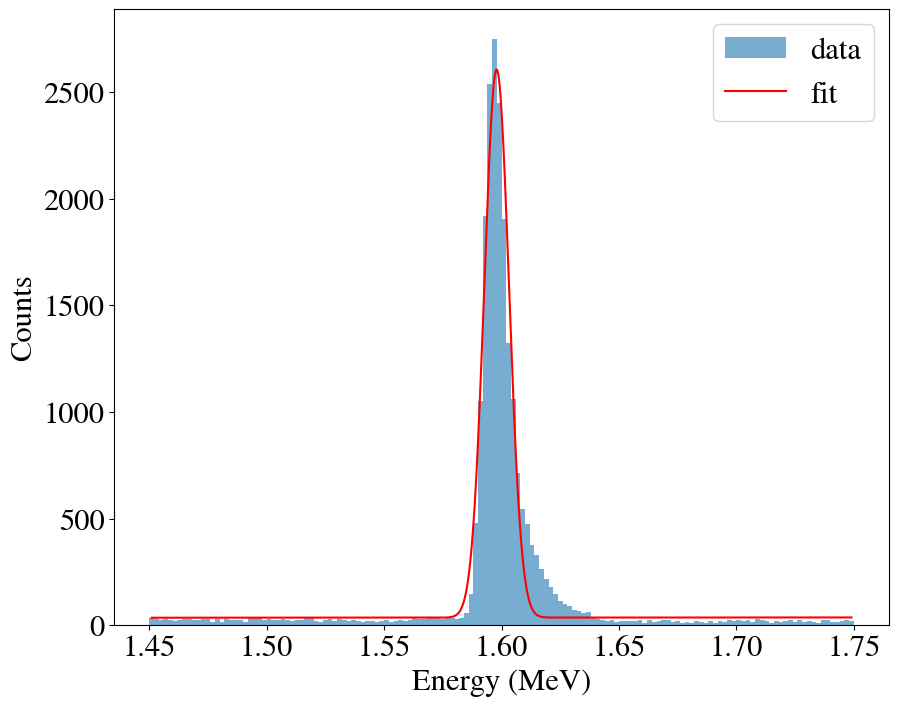

Signal events: 16921.196452692657
Background events: 5346.898137856066
Total Events by addition: 22268.094590548724
Total Events by row counting: 22268
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.5

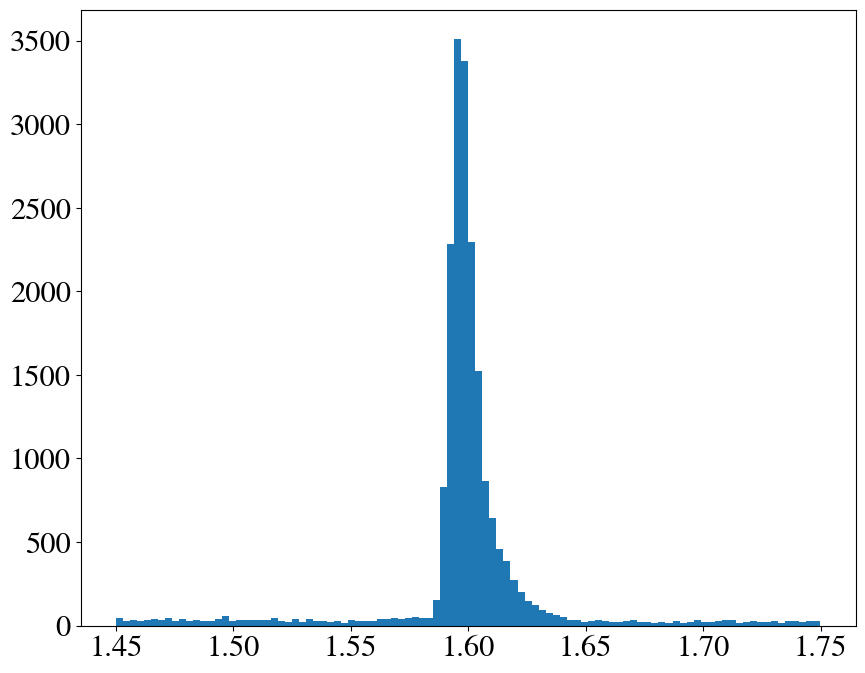

Optimized parameters (popt):
ns: 30.19869755997789
nb: 23.842887823360456
tau: -0.15580223482384198

Covariance matrix (pcov):
ns: [ 0.20537452 -1.03733993 -0.01331586]
nb: [-1.03733993e+00  7.13200019e+03  1.86887772e+02]
tau: [-1.33158577e-02  1.86887772e+02  4.91246329e+00]


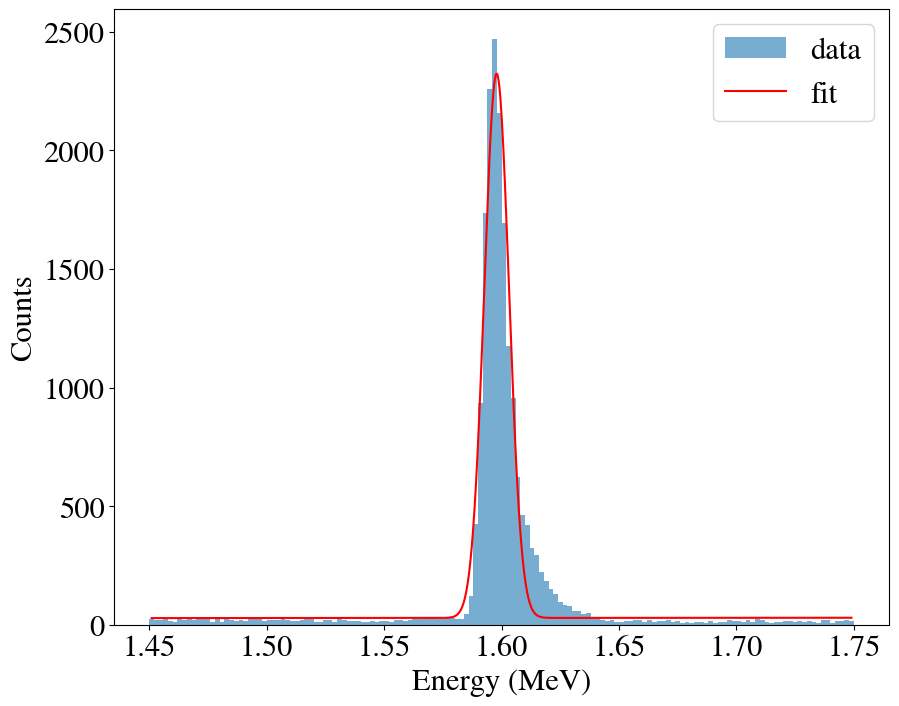

Signal events: 15099.753798667552
Background events: 4589.359238198796
Total Events by addition: 19689.11303686635
Total Events by row counting: 19689
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.51

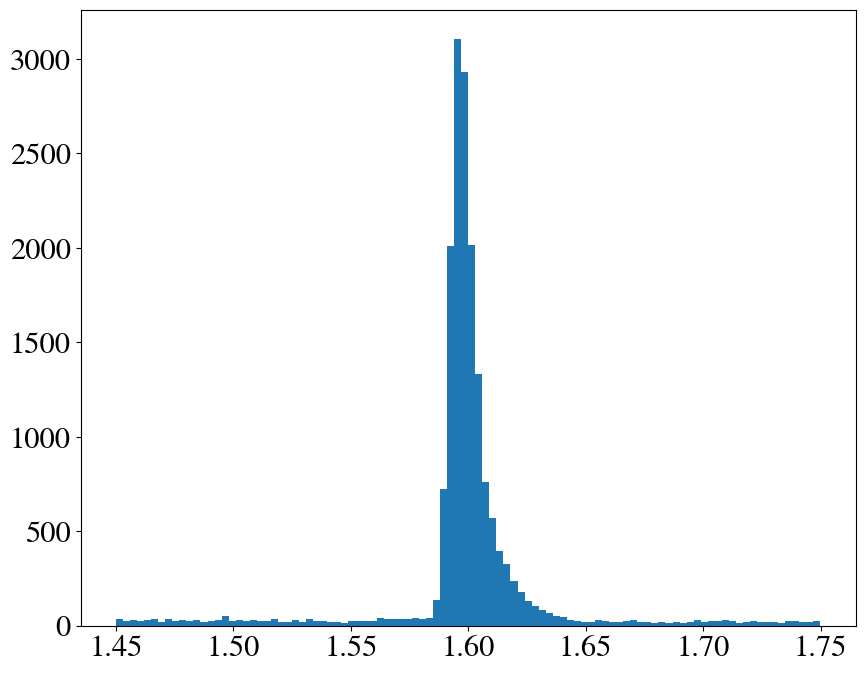

Optimized parameters (popt):
ns: 26.50654673675823
nb: 18.95571242453542
tau: -0.207030861845882

Covariance matrix (pcov):
ns: [ 0.163951   -0.82711106 -0.01426452]
nb: [-8.27111056e-01  4.89954435e+03  1.60381520e+02]
tau: [-1.42645191e-02  1.60381520e+02  5.26623269e+00]


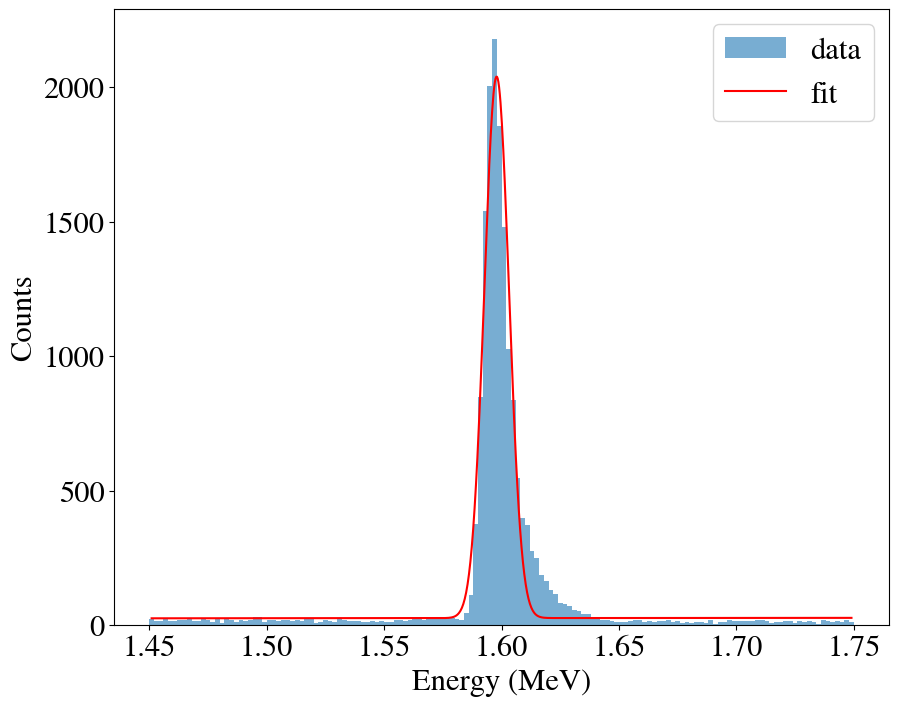

Signal events: 13253.628868695394
Background events: 3960.5987915524433
Total Events by addition: 17214.227660247838
Total Events by row counting: 17214
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.

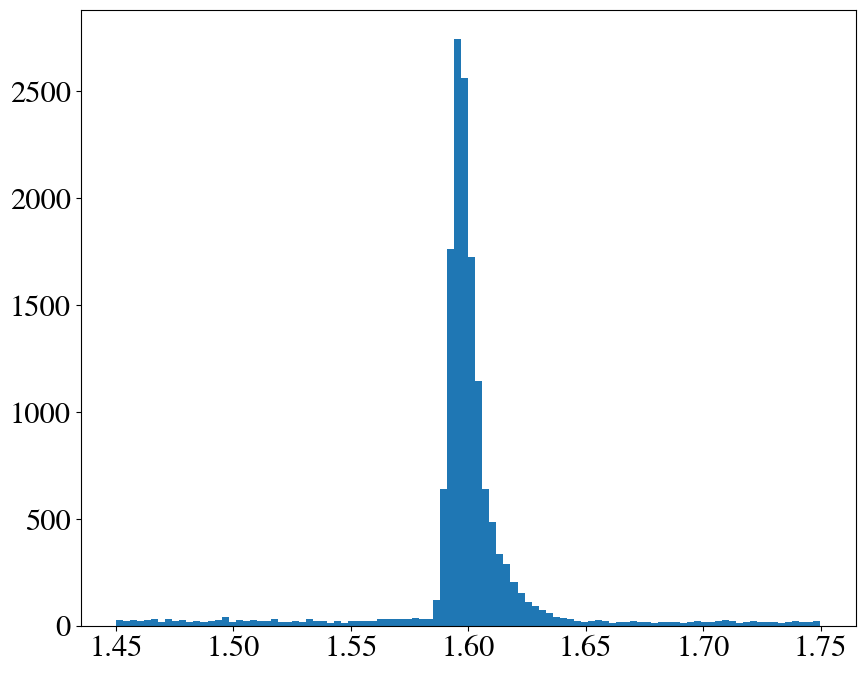

Optimized parameters (popt):
ns: 23.15234309537463
nb: 15.338856324356003
tau: -0.23351549378109357

Covariance matrix (pcov):
ns: [ 0.13250759 -0.66630738 -0.01480674]
nb: [-6.66307382e-01  3.60993315e+03  1.46605871e+02]
tau: [-1.48067367e-02  1.46605871e+02  5.97240816e+00]


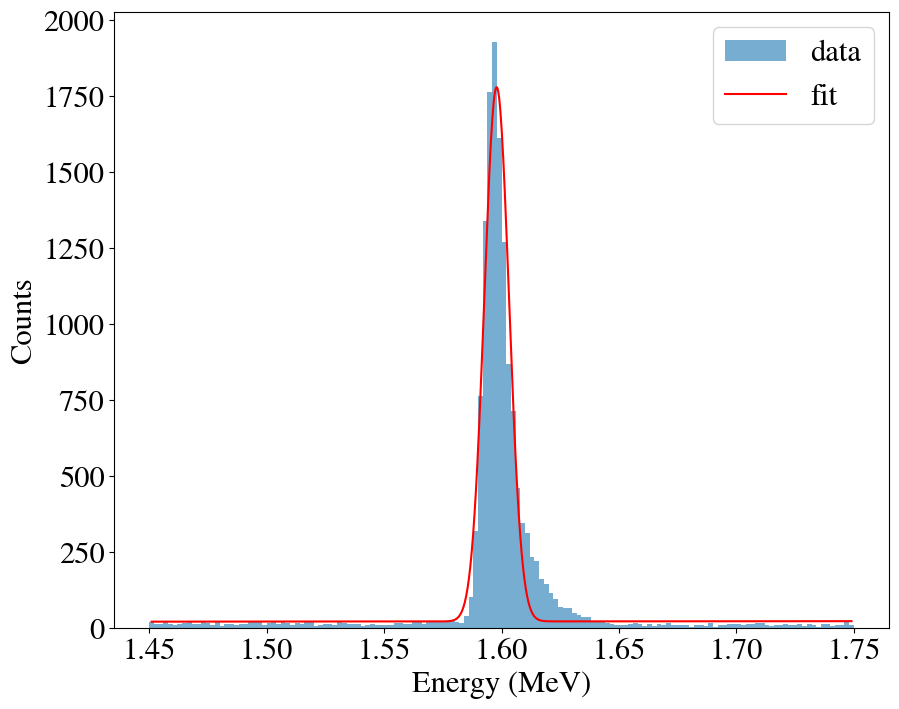

Signal events: 11576.482062118888
Background events: 3343.7678156120637
Total Events by addition: 14920.249877730952
Total Events by row counting: 14920
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.

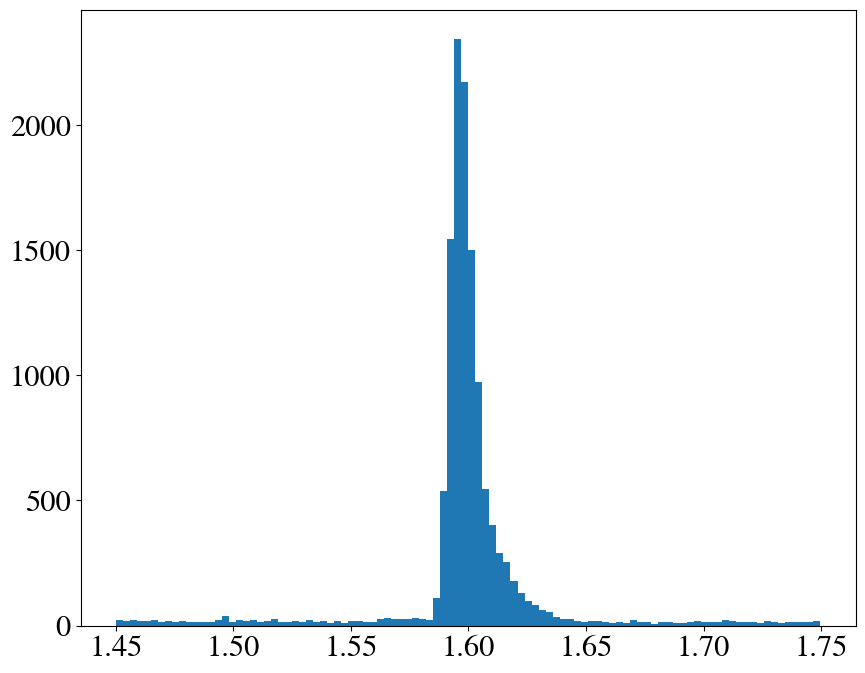

Optimized parameters (popt):
ns: 19.80196229403719
nb: 12.805437146729238
tau: -0.25408617443294457

Covariance matrix (pcov):
ns: [ 0.10382781 -0.52056915 -0.01409735]
nb: [-5.20569154e-01  2.66973433e+03  1.29322860e+02]
tau: [-1.40973461e-02  1.29322860e+02  6.28387756e+00]


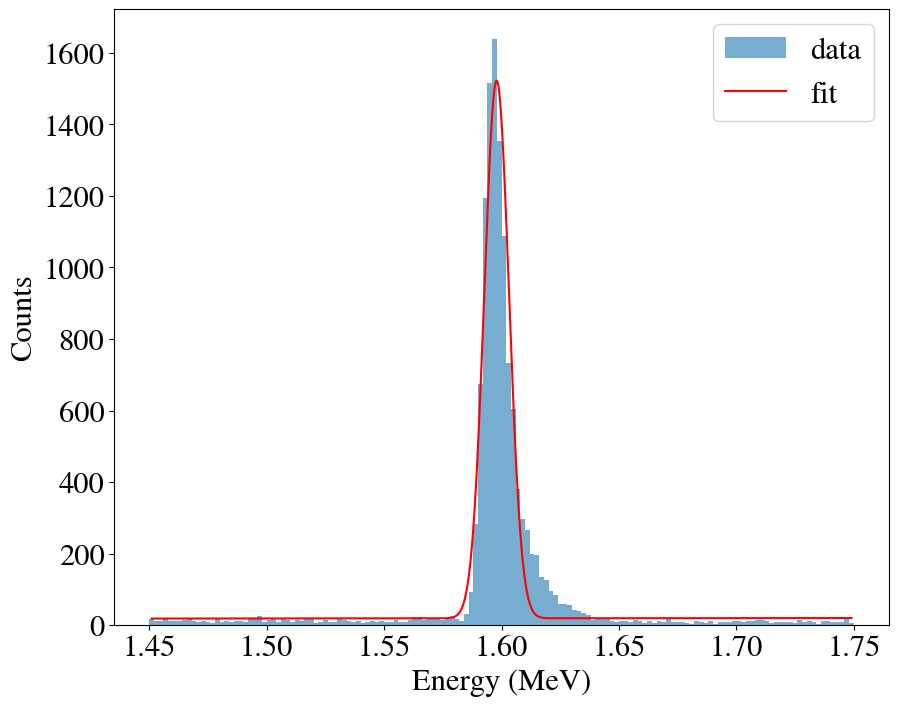

Signal events: 9901.246726836605
Background events: 2885.0134291099453
Total Events by addition: 12786.260155946551
Total Events by row counting: 12786
FOM: [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.5

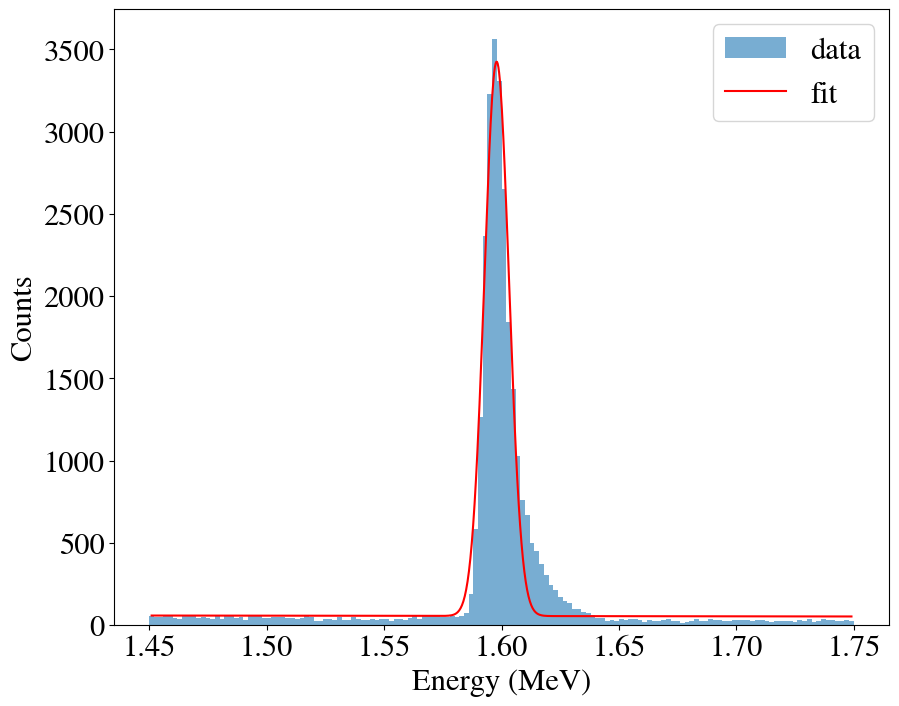

Signal events: 22193.66537138497
Background events: 8369.405781156427
Total Events by addition: 30563.071152541397
Total Events by row counting: 30562
FOM LINEAR REG: 1.4651908360307933
FOM:
[1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139

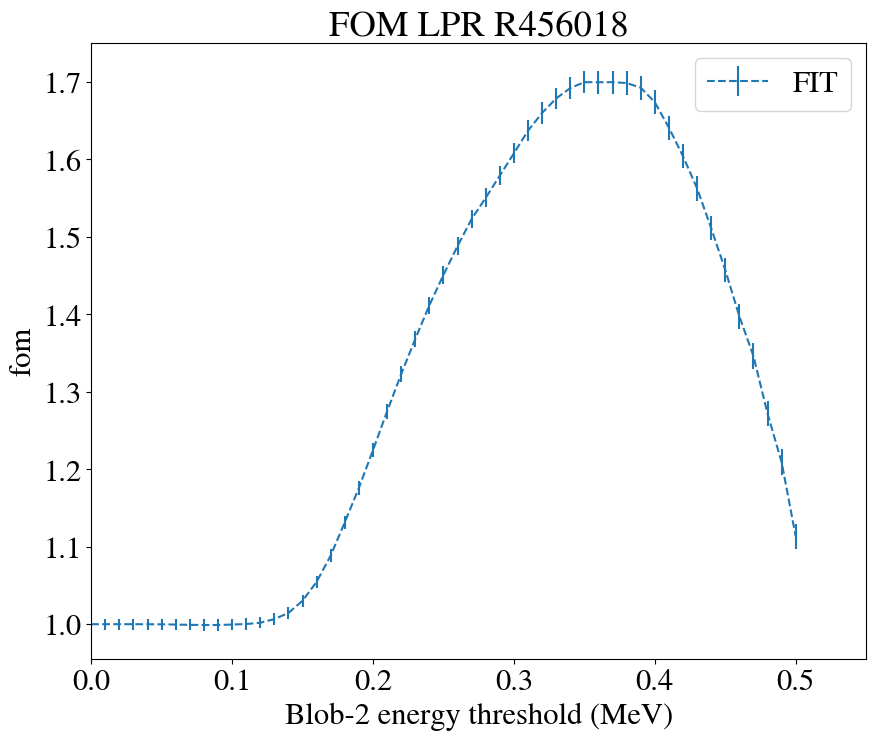

DISTRIBUTIONS AT CUT 0.35000000000000003


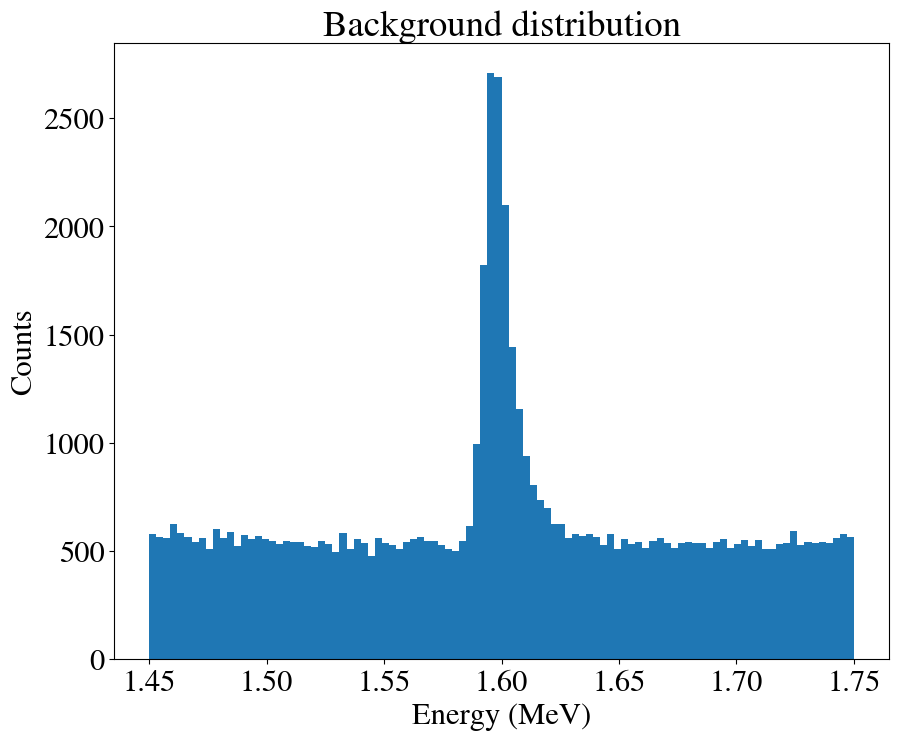

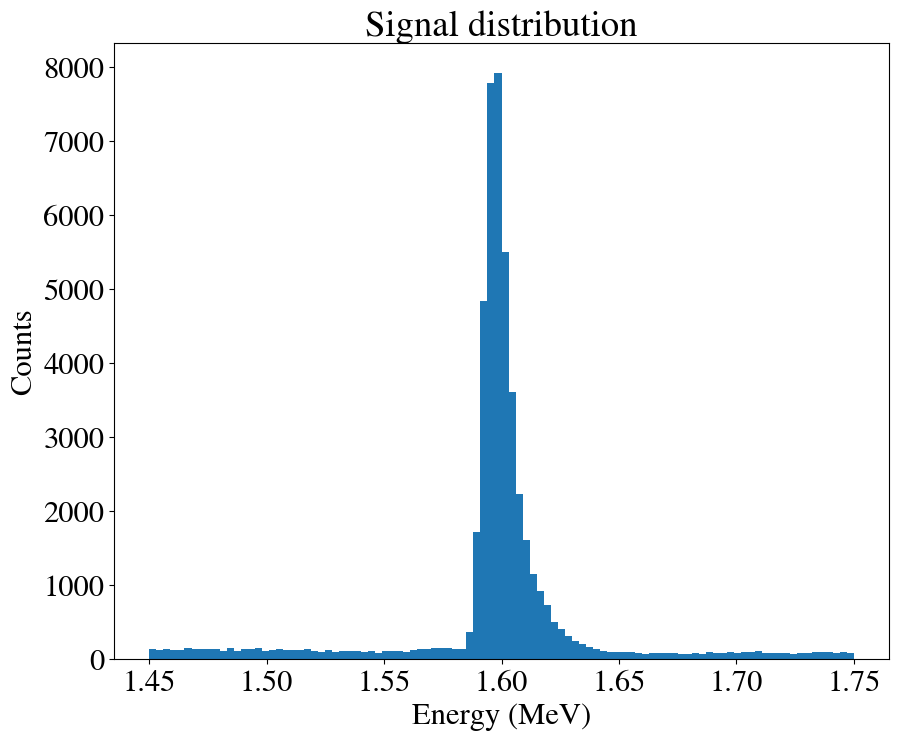

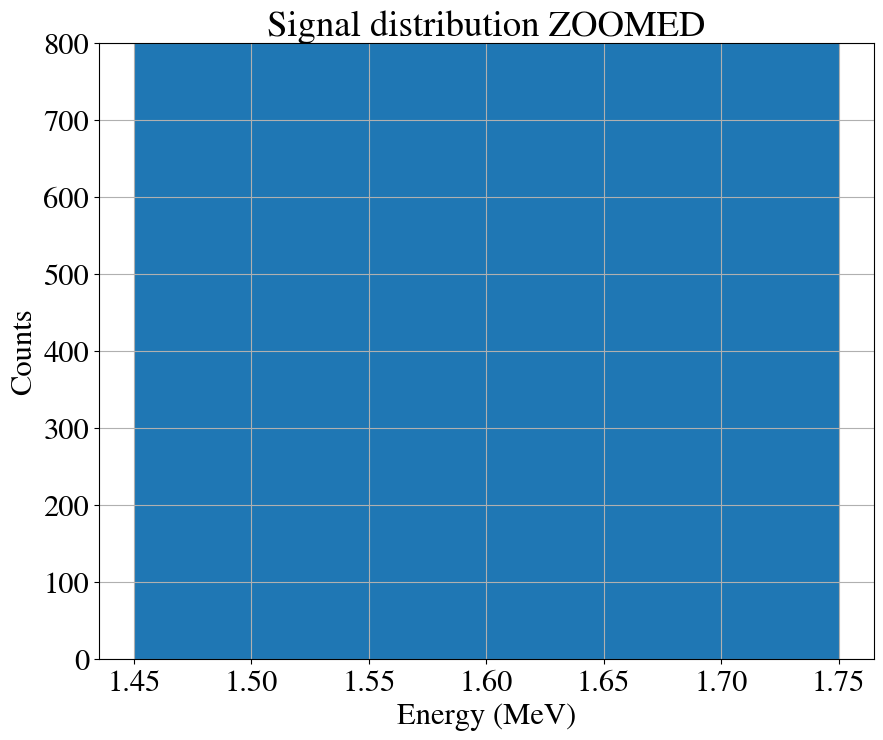

In [87]:
#RUN_NUMBER = '15589, 15590, 15591, 15592, 15593, 15594, 15596, 15597'
#RUN_NUMBER = '15589, 15590, 15591, 15592'
#RUN_NUMBER = '15589, 15590, 15591, 15592, 15593'
RUN_NUMBER = '250925'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
#TIMESTAMP  = '110725, 120725, 130725, 140725, 150725, 160725, 170725, 180725'
#TIMESTAMP  = [int(x) for x in TIMESTAMP.split(',')]
#TIMESTAMP = ['253015'] * len(RUN_NUMBER)
#TIMESTAMP = ['253015', '254015', '255015', '256015', '354015', '355015', '356015', '455015', '456015']

### TIMESTAMP IS ALWAYS blobR scanR voxelS
TIMESTAMP = ['456018']
CITY       = 'thekla'
#FOM_TS     = '253015'

    

# automate here for each FOM_TS

for TS in TIMESTAMP:
    true_TS = [TS] * len(RUN_NUMBER)
    print('=' * 20)
    print('=' * 20)
    print('\n' * 5)
    print(f'TIMESTAMP: {TS}')
    print('\n' * 5)
    print('=' * 20)
    print('=' * 20)
    main(RUN_NUMBER, true_TS, CITY, true_TS)

In [4]:
# plot the two distributions at the cut line 0.36 MeV for Blob-2 energy threshold.



In [5]:
print('Done!')

Done!


In [5]:
RUN_NUMBER = '15589, 15590, 15591'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
TIMESTAMP = ['456018']
TIMESTAMP  = TIMESTAMP * len(RUN_NUMBER)

# load
hdst_local = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    print(f'R{RN}: {TS}', flush = True)
    n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/{RN}/{TS}/'
    hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
    print(f'Loaded!', flush = True)
hdst = pd.concat(hdst_local)


# the cut you'd apply across these values
m = 0.5
c = 0.15
x = np.linspace(hdst['eblob1'].min(), hdst['eblob1'].max(), 1000)
y = m*x + c

# Define the paraboloid equation
#a, b, c = 7, -7, 2.1  # Example coefficients for the paraboloid
#y = a * x**2 + b * x + c

# blob 2dhist
#plt.figure(figsize=(12,8))
plt.hist2d(hdst['eblob1'], hdst['eblob2'], bins=(60, 60), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
#plt.plot(x,y, c = 'red', linewidth = 5, linestyle = '-.', label = f'a = {a}\nb = {b}\nc = {c}')
plt.plot(x,y, c = 'red', linewidth = 5, linestyle = '-.', label = f'm = {m}\nc = {c}')
plt.legend()
#plt.title(f'{blob_2dhits_title}')
plt.show()

R15589: 456018


FileNotFoundError: File /scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/15589/456018/cut_hdst.h5 does not exist